<a href="https://colab.research.google.com/github/Hyshubham2504/Clustering-Project/blob/main/First_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**1. Import libraries**

In [42]:
import yfinance as yf
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, homogeneity_score, completeness_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

###**2. Get the latest list of S&P 500 companies from Slickcharts**

In [7]:
# Get the latest S&P 500 components symbols (list of companies' ticker symbols)
# Reference: https://www.reddit.com/r/algotrading/comments/mtgakn/free_api_to_get_up_to_date_list_of_all_sp_500/
url = 'https://www.slickcharts.com/sp500'
request = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
soup = bs(request.text, "lxml")
stats = soup.find('table',class_='table table-hover table-borderless table-sm')

df =pd.read_html(str(stats))[0]

SP500_tickers = df['Symbol']

In [8]:
# Check if we got the ticker symbol correctly
print(SP500_tickers.head(), "\n")
print(SP500_tickers.describe())

0    MSFT
1    AAPL
2    NVDA
3    AMZN
4    META
Name: Symbol, dtype: object 

count      503
unique     503
top       MSFT
freq         1
Name: Symbol, dtype: object


###**3. Get the daily return data of the 500 companies from Yahoo Finance**
For the 20-year period 2004-01-01 — 2024-01-01 (YYYY-MM-dd).

In [9]:
# Temporary fix: Yahoo Finance uses "BRK-B" instead of "BRK.B" and "BF-B" instead of "BF.B"
# Replace these 2 tickers in the SP500_tickers list so that we can get their data from Yahoo Finance
SP500_tickers = list(map(lambda x: x.replace('BRK.B', 'BRK-B'), SP500_tickers))
SP500_tickers = list(map(lambda x: x.replace('BF.B', 'BF-B'), SP500_tickers))

In [10]:
# This can take 3-4 minutes
SP500_dict = {}

for ticker in SP500_tickers:
    ticker_yahoo = yf.Ticker(ticker)
    adj_close_data = ticker_yahoo.history(start="2004-01-01",  end="2024-01-01", auto_adjust=False, actions=False)["Adj Close"]
    SP500_dict[ticker] = adj_close_data.pct_change().dropna()

ERROR:yfinance:GEV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200
ERROR:yfinance:SOLV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200


In [11]:
daily_return_df = pd.DataFrame(SP500_dict)
descriptive_data = daily_return_df.describe()
descriptive_data

MSFT         AAPL         NVDA         AMZN         META  \
count  5032.000000  5032.000000  5032.000000  5032.000000  2922.000000   
mean      0.000758     0.001487     0.001600     0.001101     0.001082   
std       0.017031     0.020802     0.030844     0.024294     0.025280   
min      -0.147390    -0.179195    -0.352336    -0.218220    -0.263901   
25%      -0.007240    -0.008436    -0.013788    -0.010354    -0.010045   
50%       0.000401     0.001137     0.001511     0.000567     0.000999   
75%       0.008788     0.012002     0.016473     0.012433     0.012825   
max       0.186047     0.139050     0.298067     0.269497     0.296115   

             GOOGL         GOOG        BRK-B          LLY         AVGO  ...  \
count  4874.000000  4874.000000  5032.000000  5032.000000  3624.000000  ...   
mean      0.001011     0.001014     0.000457     0.000662     0.001505  ...   
std       0.019349     0.019367     0.013367     0.015634     0.022169  ...   
min      -0.116342    -0.116091    -0.109440    -0.123483    -0.199129  ...   
25%      -0.007991    -0.007862    -0.005608    -0.006768    -0.010266  ...   
50%       0.000769     0.000701     0.000170     0.000655     0.001441  ...   
75%       0.010137     0.010139     0.006389     0.007805     0.012933  ...   
max       0.199915     0.199915     0.192641     0.156797     0.158337  ...   

              ETSY           RL         PAYC          IVZ          BEN  \
count  2192.000000  5032.000000  2444.000000  5032.000000  5032.000000   
mean      0.001178     0.000644     0.001520     0.000526     0.000458   
std       0.038176     0.023349     0.029803     0.026851     0.021777   
min      -0.283411    -0.221616    -0.384863    -0.211329    -0.152757   
25%      -0.018437    -0.010497    -0.012396    -0.011485    -0.009611   
50%       0.000000     0.000527     0.002680     0.000340     0.000693   
75%       0.020372     0.011526     0.015996     0.012414     0.011021   
max       0.306001     0.198007     0.192893     0.280510     0.161147   

               BIO          MHK         PARA          FOX          NWS  
count  5032.000000  5032.000000  4547.000000  1209.000000  2651.000000  
mean      0.000514     0.000369     0.000367    -0.000008     0.000407  
std       0.018676     0.024270     0.028343     0.021045     0.018604  
min      -0.167247    -0.242460    -0.283530    -0.104065    -0.145523  
25%      -0.008106    -0.010356    -0.012083    -0.010882    -0.009032  
50%       0.000415     0.000144     0.000289    -0.000632     0.000000  
75%       0.008629     0.010918     0.012249     0.010762     0.009425  
max       0.205034     0.295611     0.307624     0.132469     0.132930  

[8 rows x 503 columns]

In [12]:
pd.set_option('display.max_rows', None)
descriptive_data.loc['count'].value_counts()

count
5032.0    385
2651.0      2
0.0         2
2137.0      2
4165.0      2
2370.0      2
952.0       2
4874.0      2
4922.0      1
1885.0      1
4792.0      1
4651.0      1
3554.0      1
1820.0      1
4658.0      1
3409.0      1
4901.0      1
2063.0      1
3047.0      1
4072.0      1
3281.0      1
2203.0      1
4306.0      1
2332.0      1
1739.0      1
60.0        1
4223.0      1
2314.0      1
3442.0      1
3949.0      1
4329.0      1
4642.0      1
3520.0      1
4505.0      1
4547.0      1
2444.0      1
2192.0      1
4595.0      1
4819.0      1
1429.0      1
2755.0      1
2334.0      1
1210.0      1
3494.0      1
5009.0      1
3215.0      1
2545.0      1
2992.0      1
2263.0      1
1794.0      1
2144.0      1
4535.0      1
4767.0      1
4627.0      1
2925.0      1
2956.0      1
4186.0      1
3287.0      1
1801.0      1
1508.0      1
2948.0      1
489.0       1
3223.0      1
767.0       1
3372.0      1
3388.0      1
4479.0      1
4559.0      1
2746.0      1
4512.0      1
2408.0      1


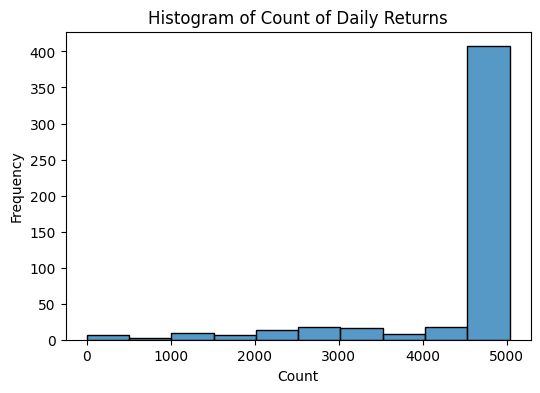

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(descriptive_data.loc['count'], bins=10, kde=False)
plt.title('Histogram of Count of Daily Returns')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Check if it's GEV and SOLV that have count = 0
daily_return_df[['GEV', 'SOLV']].describe()

GEV  SOLV
count  0.0   0.0
mean   NaN   NaN
std    NaN   NaN
min    NaN   NaN
25%    NaN   NaN
50%    NaN   NaN
75%    NaN   NaN
max    NaN   NaN

GEV: Founded on April 2, 2024 \
SOLV: Spun off from 3M (and hence founded) on April 1, 2024

In [15]:
# Check for missing values
daily_return_df.isnull().sum()

MSFT        0
AAPL        0
NVDA        0
AMZN        0
META     2110
GOOGL     158
GOOG      158
BRK-B       0
LLY         0
AVGO     1408
JPM         0
TSLA     1633
XOM         0
UNH         0
V        1059
PG          0
COST        0
MA        603
JNJ         0
HD          0
MRK         0
ABBV     2265
NFLX        0
WMT         0
CVX         0
BAC         0
AMD         0
KO          0
CRM       118
ADBE        0
PEP         0
ORCL        0
QCOM        0
LIN         0
TMO         0
WFC         0
AMAT        0
CSCO        0
ACN         0
DIS         0
MCD         0
INTU        0
ABT         0
TXN         0
GE          0
VZ          0
AMGN        0
DHR         0
CAT         0
NOW      2139
ISRG        0
PM       1057
PFE         0
IBM         0
NEE         0
CMCSA       0
UBER     3864
MU          0
GS          0
SPGI        0
HON         0
LRCX        0
UNP         0
BKNG        0
T           0
RTX         0
COP         0
AXP         0
INTC        0
LOW         0
ETN         0
TJX   

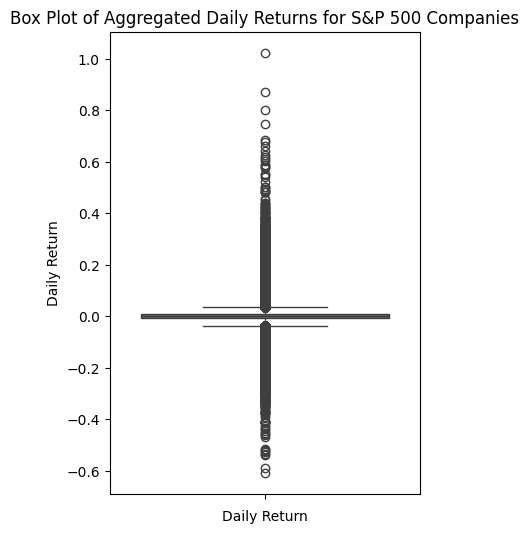

In [16]:
# aggregated_return: daily return of all companies combined into one list
aggregated_return = daily_return_df.stack()

plt.figure(figsize=(4, 6))
sns.boxplot(aggregated_return)
plt.title('Box Plot of Aggregated Daily Returns for S&P 500 Companies')
plt.xlabel('Daily Return')
plt.ylabel('Daily Return')
plt.show()

In [17]:
summary_statistics = aggregated_return.describe()
summary_statistics

count    2.301822e+06
mean     6.891330e-04
std      2.199504e-02
min     -6.079076e-01
25%     -8.536598e-03
50%      6.375000e-04
75%      9.849454e-03
max      1.023579e+00
dtype: float64

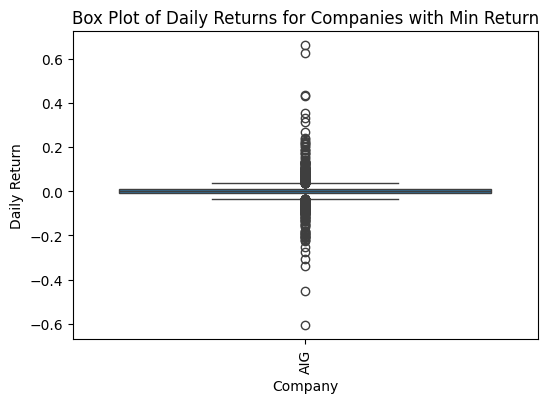

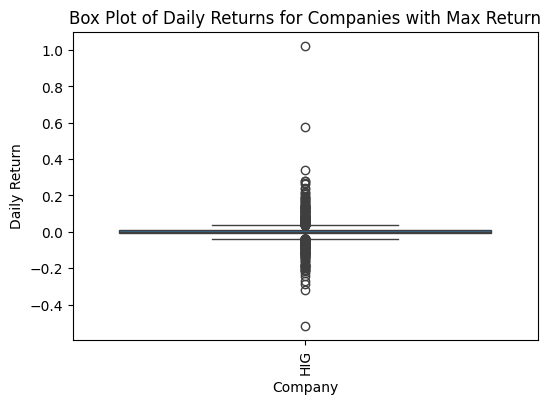

In [18]:
companies_min = daily_return_df.loc[:, (daily_return_df == summary_statistics['min']).any()].columns
companies_max = daily_return_df.loc[:, (daily_return_df == summary_statistics['max']).any()].columns

plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_min])
plt.title('Box Plot of Daily Returns for Companies with Min Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_max])
plt.title('Box Plot of Daily Returns for Companies with Max Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()

In [19]:
daily_return_df.index[daily_return_df['AIG'] == summary_statistics['min']]

Index([2008-09-15 00:00:00-04:00], dtype='object', name='Date')

In [20]:
daily_return_df.index[daily_return_df['HIG'] == summary_statistics['max']]

Index([2008-12-05 00:00:00-05:00], dtype='object', name='Date')

<Figure size 2000x600 with 0 Axes>

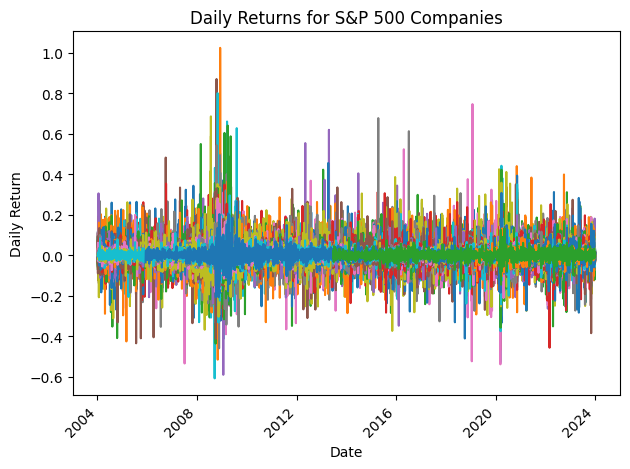

In [21]:
plt.figure(figsize=(20, 6))

daily_return_df.plot(legend=False)
plt.title('Daily Returns for S&P 500 Companies')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

AIG: American Internation Group Inc. \
AIG, a global company with about \$1 trillion in assets prior to the crisis, lost \$99.2 billion in 2008. On September 16 of that year, the Federal Reserve Bank of New York stepped in with an $85 billion loan to keep the failing company from going under.
https://insight.kellogg.northwestern.edu/article/what-went-wrong-at-aig#:~:text=AIG%2C%20a%20global%20company%20with,failing%20company%20from%20going%20under.
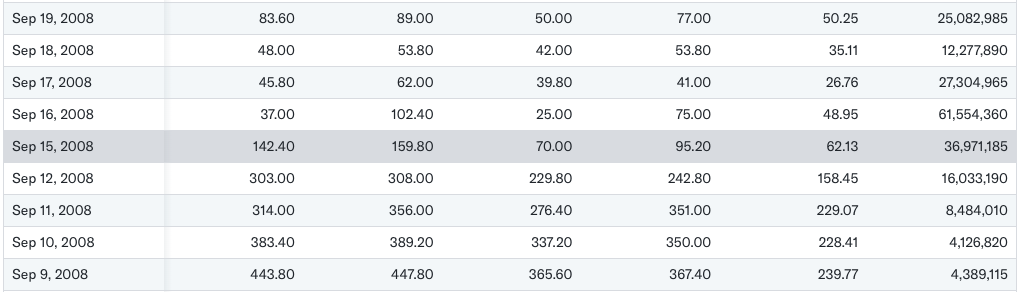

HIG: Hartford Financial Services Group Inc.
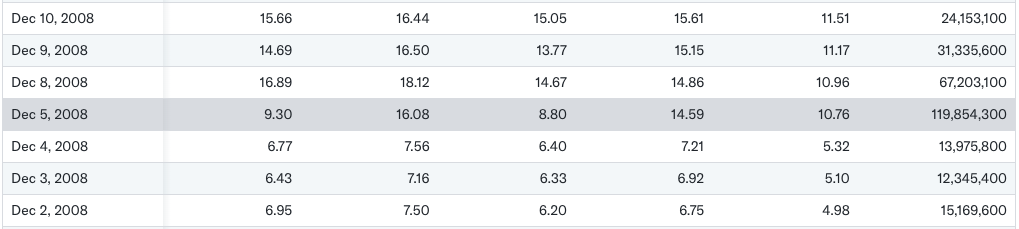

In [22]:
# Double check AIG's return on Setptember 15, 2008
(62.13-158.45)/158.45

-0.6078889239507731

In [23]:
# Double check HIG's return on December 5, 2008
(10.76-5.32)/5.32

1.0225563909774436

In [24]:
# Drop stocks (columns, hence axis = 1) with null values within this 10-year period
daily_return_cleaned_df = daily_return_df.dropna(axis=1)
daily_return_cleaned_df.isnull().sum()

MSFT     0
AAPL     0
NVDA     0
AMZN     0
BRK-B    0
LLY      0
JPM      0
XOM      0
UNH      0
PG       0
COST     0
JNJ      0
HD       0
MRK      0
NFLX     0
WMT      0
CVX      0
BAC      0
AMD      0
KO       0
ADBE     0
PEP      0
ORCL     0
QCOM     0
LIN      0
TMO      0
WFC      0
AMAT     0
CSCO     0
ACN      0
DIS      0
MCD      0
INTU     0
ABT      0
TXN      0
GE       0
VZ       0
AMGN     0
DHR      0
CAT      0
ISRG     0
PFE      0
IBM      0
NEE      0
CMCSA    0
MU       0
GS       0
SPGI     0
HON      0
LRCX     0
UNP      0
BKNG     0
T        0
RTX      0
COP      0
AXP      0
INTC     0
LOW      0
ETN      0
TJX      0
ELV      0
PGR      0
VRTX     0
MS       0
C        0
SYK      0
NKE      0
BSX      0
ADI      0
REGN     0
KLAC     0
SCHW     0
BLK      0
CB       0
BA       0
MDT      0
MMC      0
PLD      0
LMT      0
UPS      0
DE       0
ADP      0
CI       0
AMT      0
SNPS     0
SBUX     0
MDLZ     0
FI       0
GILD     0
SO       0
BMY      0

In [25]:
# See how many stocks are left after dropping stocks with null values
len(daily_return_cleaned_df.columns)

385

###**4. Get the correlation matrix**

In [26]:
correlation_matrix = daily_return_cleaned_df.corr()
correlation_matrix

MSFT      AAPL      NVDA      AMZN     BRK-B       LLY       JPM  \
MSFT   1.000000  0.515875  0.511252  0.513598  0.456937  0.397548  0.449748   
AAPL   0.515875  1.000000  0.457382  0.445228  0.366614  0.290833  0.395235   
NVDA   0.511252  0.457382  1.000000  0.415434  0.353807  0.263925  0.355184   
AMZN   0.513598  0.445228  0.415434  1.000000  0.331856  0.278473  0.347681   
BRK-B  0.456937  0.366614  0.353807  0.331856  1.000000  0.349591  0.595031   
LLY    0.397548  0.290833  0.263925  0.278473  0.349591  1.000000  0.350960   
JPM    0.449748  0.395235  0.355184  0.347681  0.595031  0.350960  1.000000   
XOM    0.413685  0.342901  0.318555  0.284270  0.480736  0.365668  0.481012   
UNH    0.401533  0.342861  0.293262  0.288249  0.403912  0.406178  0.395930   
PG     0.443251  0.333419  0.270190  0.264903  0.414461  0.445079  0.398160   
COST   0.474555  0.399349  0.368124  0.395421  0.392283  0.363945  0.391020   
JNJ    0.437819  0.324062  0.259752  0.293379  0.452258  0.543589  0.389526   
HD     0.513042  0.437741  0.419567  0.427354  0.490536  0.385856  0.544058   
MRK    0.354761  0.272717  0.234063  0.234946  0.365969  0.502272  0.359778   
NFLX   0.308203  0.285967  0.311394  0.387075  0.215339  0.167527  0.210372   
WMT    0.368883  0.295633  0.255678  0.279487  0.332654  0.356446  0.320335   
CVX    0.439914  0.362174  0.341244  0.294614  0.510441  0.365502  0.508004   
BAC    0.406236  0.355395  0.329331  0.311129  0.564155  0.309543  0.831071   
AMD    0.397004  0.371567  0.516852  0.343096  0.309295  0.223150  0.323042   
KO     0.447291  0.331875  0.279667  0.288912  0.453074  0.414868  0.405247   
ADBE   0.609636  0.471358  0.516510  0.475971  0.406386  0.358186  0.415143   
PEP    0.471047  0.341651  0.289902  0.302571  0.437893  0.446072  0.386427   
ORCL   0.557312  0.446305  0.438990  0.396123  0.440119  0.382898  0.464053   
QCOM   0.502872  0.473218  0.497033  0.424127  0.372853  0.291949  0.406378   
LIN    0.535151  0.452720  0.442697  0.379382  0.528621  0.393803  0.535080   
TMO    0.495921  0.407549  0.421152  0.417475  0.443130  0.423458  0.416178   
WFC    0.404137  0.339233  0.313530  0.310546  0.552182  0.324103  0.820263   
AMAT   0.549452  0.473032  0.595566  0.421340  0.435759  0.311997  0.466390   
CSCO   0.564022  0.467732  0.478750  0.414762  0.459508  0.391715  0.490534   
ACN    0.544575  0.410247  0.440900  0.409366  0.482448  0.372758  0.443646   
DIS    0.506830  0.414696  0.404775  0.410830  0.522243  0.348351  0.544584   
MCD    0.438804  0.372280  0.315011  0.315739  0.424378  0.325749  0.422161   
INTU   0.586742  0.449469  0.479062  0.456229  0.424366  0.359901  0.423563   
ABT    0.441392  0.332709  0.304246  0.302931  0.405289  0.477075  0.373240   
TXN    0.540875  0.476425  0.587405  0.423072  0.442193  0.336836  0.454502   
GE     0.393187  0.370335  0.343550  0.315641  0.517396  0.330267  0.591356   
VZ     0.399503  0.304212  0.267869  0.294631  0.396496  0.391972  0.431870   
AMGN   0.416652  0.334103  0.282084  0.310429  0.374337  0.452947  0.333662   
DHR    0.459822  0.391147  0.390378  0.368125  0.412594  0.367410  0.416032   
CAT    0.453275  0.402077  0.400840  0.352621  0.537276  0.334929  0.537191   
ISRG   0.398487  0.379260  0.380893  0.347012  0.342028  0.309072  0.346298   
PFE    0.392249  0.303153  0.273253  0.286233  0.409222  0.517837  0.418652   
IBM    0.493990  0.423260  0.379447  0.356245  0.499031  0.360912  0.510494   
NEE    0.411269  0.305006  0.273363  0.266747  0.390079  0.384195  0.324126   
CMCSA  0.472283  0.382056  0.378168  0.362515  0.465966  0.388296  0.524414   
MU     0.437601  0.390787  0.517663  0.353517  0.423089  0.270083  0.443329   
GS     0.478272  0.425991  0.399399  0.383776  0.582776  0.348622  0.757446   
SPGI   0.537685  0.427078  0.432553  0.400642  0.495223  0.408734  0.515897   
HON    0.532165  0.437817  0.426653  0.382913  0.572099  0.420004  0.589485   
LRCX   0.511189  0.462823  0.585565  0.417813  0.409234  0.28

pandas.DataFrame.corr() here uses Pearson correlation coefficient.
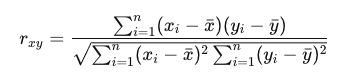

In [27]:
correlation_matrix[correlation_matrix < 0].stack()

Series([], dtype: float64)

###**5. Perform K-means clustering**

K-Means from Scikitlearn \

Default method of initialization of centroids: K-means++
1. Choose one center uniformly at random among the data points.
2. For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)^2.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering. \

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html \
https://en.wikipedia.org/wiki/K-means%2B%2B

####**5.1 Try out different n_cluster**

#####**5.1.1 Metrics (inertia, silhouette score, etc.)**

In [28]:
import warnings
warnings.filterwarnings("ignore")

Obtained sector data from

*   https://www.barchart.com/stocks/indices/sp-sector/consumer-discretionary
*   https://www.spglobal.com/spdji/en/index-family/equity/us-equity/sp-sectors/#indices



In [57]:
industry_sector_url = "https://raw.githubusercontent.com/Hyshubham2504/Clustering-Project/main/Industry.csv"
industry_sector = pd.read_csv(industry_sector_url)

# Original company list order
company_order = correlation_matrix.columns

# Reorder industry_sector to match the original order
industry_sector_ordered = industry_sector.set_index('Ticker Symbol').reindex(company_order).reset_index()

industry_sector_ordered.head(10)

index         Industry Sector
0   MSFT  Information Technology
1   AAPL  Information Technology
2   NVDA  Information Technology
3   AMZN  Consumer Discretionary
4  BRK-B              Financials
5    LLY             Health Care
6    JPM              Financials
7    XOM                  Energy
8    UNH             Health Care
9     PG        Customer Staples

In [82]:
# Check the number of tickers that fall into each industry sector among these 388 tickers
industry_sector_ordered['Industry Sector'].value_counts()

Industry Sector
Financials                56
Industrials               56
Health Care               53
Information Technology    48
Consumer Discretionary    38
Customer Staples          32
Utilities                 28
Real Estate               26
Materials                 21
Energy                    17
Communication Services    10
Name: count, dtype: int64

In [66]:
true_labels = industry_sector_ordered['Industry Sector']

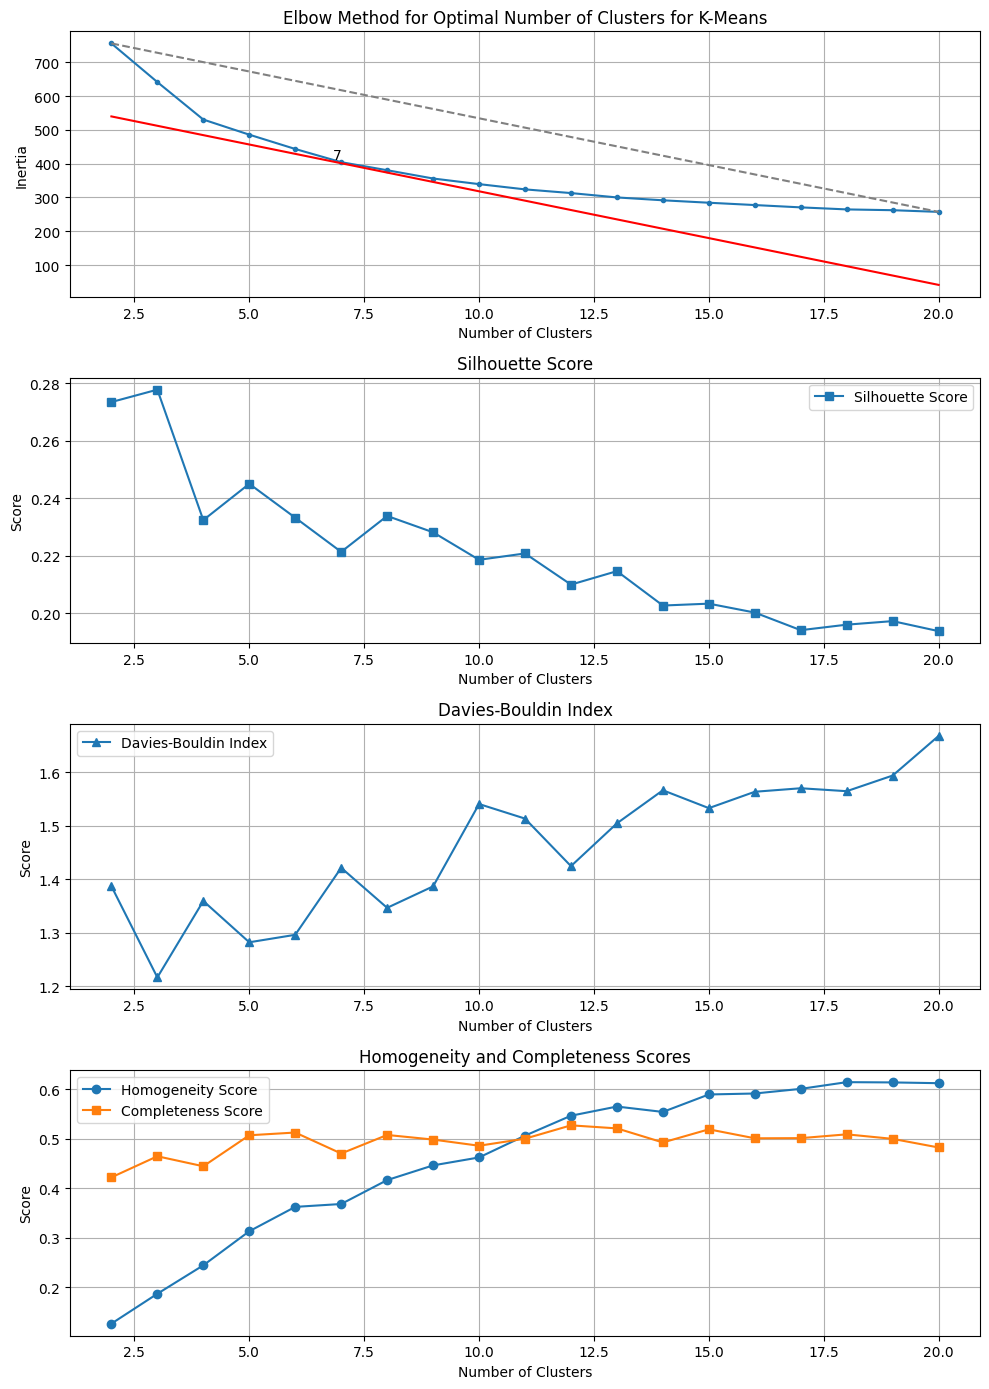

In [90]:
# Test out different values of n_clusters using the elbow method
# Try the numbers between 2 to 20
n_cluster_options = range(2, 21)

# inertia_: Sum of squared distances of samples to their closest cluster center
inertia_array = []
silhouette_scores = []
db_scores = []
homogeneity_scores = []
completeness_scores = []
kmeans_results = {}

for n_cluster in n_cluster_options:
    kmeans = KMeans(n_clusters=n_cluster, random_state=123)
    kmeans.fit(correlation_matrix)
    kmeans_labels = kmeans.labels_
    kmeans_results[n_cluster] = kmeans_labels

    # Record the metrics
    inertia_array.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(correlation_matrix, kmeans_labels))
    db_scores.append(davies_bouldin_score(correlation_matrix, kmeans_labels))
    homogeneity_scores.append(homogeneity_score(true_labels, kmeans_labels))
    completeness_scores.append(completeness_score(true_labels, kmeans_labels))

start_point = (n_cluster_options[0], inertia_array[0])
end_point = (n_cluster_options[-1], inertia_array[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(2, 20)
y_values = slope * x_values + 595

#plot subplots
fig, ax = plt.subplots(4, 1, figsize=(10, 14))

# Plot elbow method (inertia)
ax[0].plot(n_cluster_options, inertia_array, marker='.')
ax[0].plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
ax[0].plot(x_values, y_values, color='red')
ax[0].text(n_cluster_options[5], inertia_array[5], f'{n_cluster_options[5]}', ha='right', va='bottom')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method for Optimal Number of Clusters for K-Means')
ax[0].grid(True)

# Plot the silhoutte score and davies-bouldin index
ax[1].plot(n_cluster_options, silhouette_scores, marker='s', label='Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Score')
ax[1].set_title('Silhouette Score')
ax[1].legend()
ax[1].grid(True)

ax[2].plot(n_cluster_options, db_scores, marker='^', label='Davies-Bouldin Index')
ax[2].set_xlabel('Number of Clusters')
ax[2].set_ylabel('Score')
ax[2].set_title('Davies-Bouldin Index')
ax[2].legend()
ax[2].grid(True)

ax[3].plot(n_cluster_options, homogeneity_scores, marker='o', label='Homogeneity Score')
ax[3].plot(n_cluster_options, completeness_scores, marker='s', label='Completeness Score')
ax[3].set_xlabel('Number of Clusters')
ax[3].set_ylabel('Score')
ax[3].set_title('Homogeneity and Completeness Scores')
ax[3].legend()
ax[3].grid(True)

plt.tight_layout()
plt.show()

Potential candidates of n_cluster: 3, 5

#####**5.1.2 Percentage of industry sector in each cluster**

In [83]:
sector_percentage_dfs = {}

for n_cluster in n_cluster_options:
    cluster_labels = kmeans_results[n_cluster]
    sector_counts = pd.DataFrame({'Cluster': cluster_labels, 'Industry Sector': true_labels}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages = sector_counts.div(sector_counts.sum(axis=1), axis=0) * 100
    sector_percentage_dfs[n_cluster] = sector_percentages

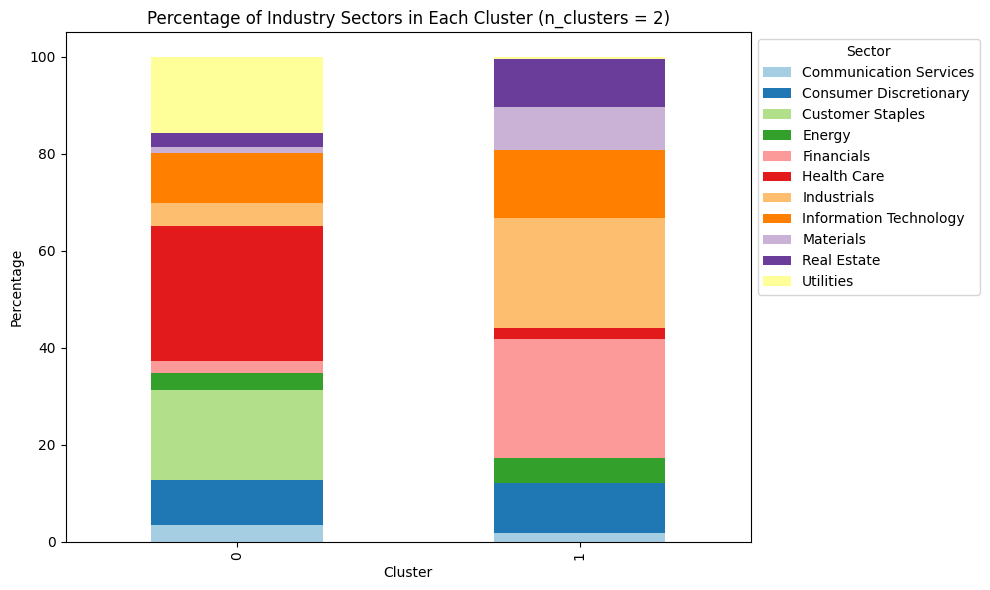

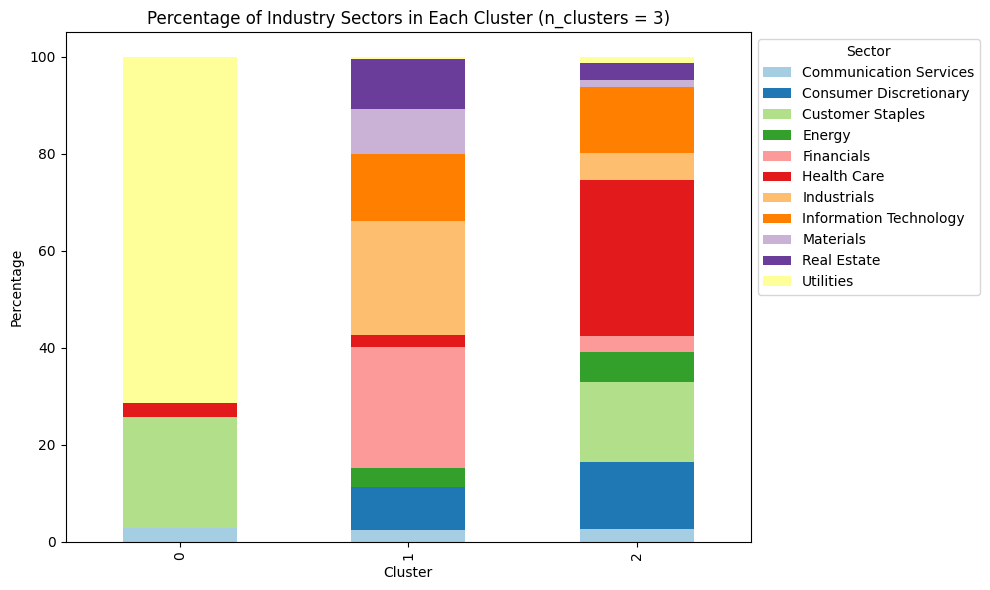

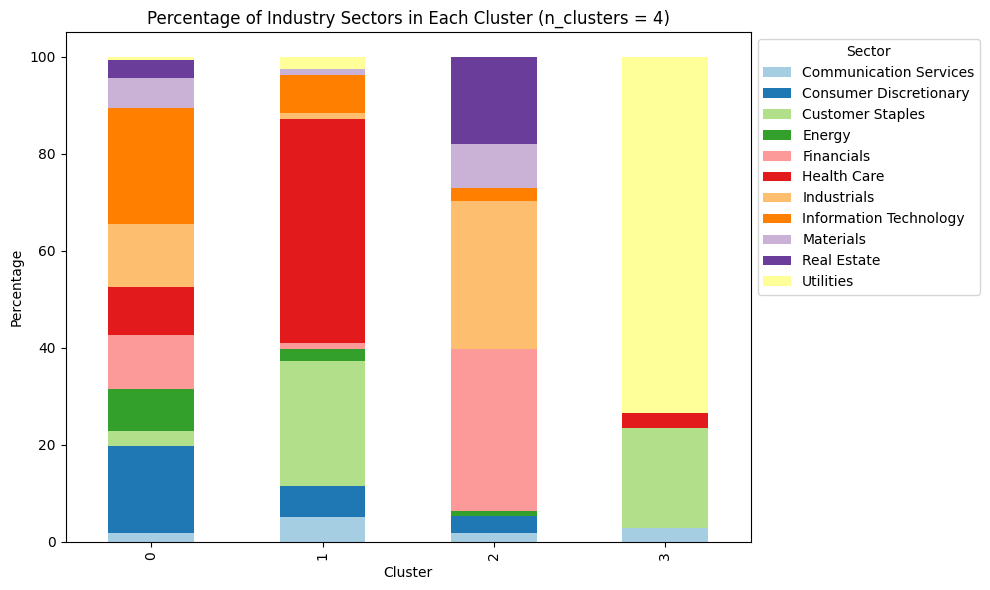

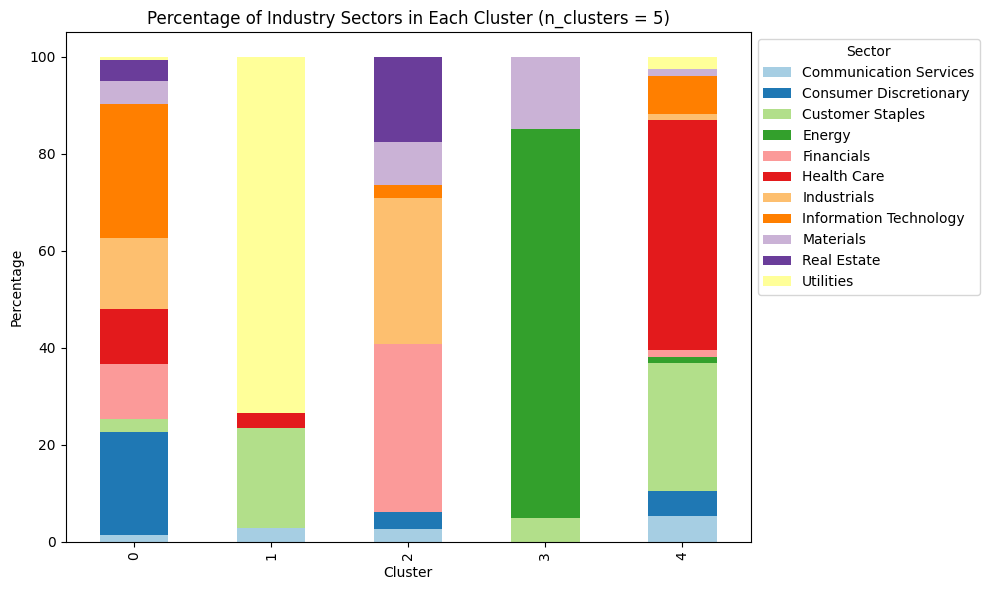

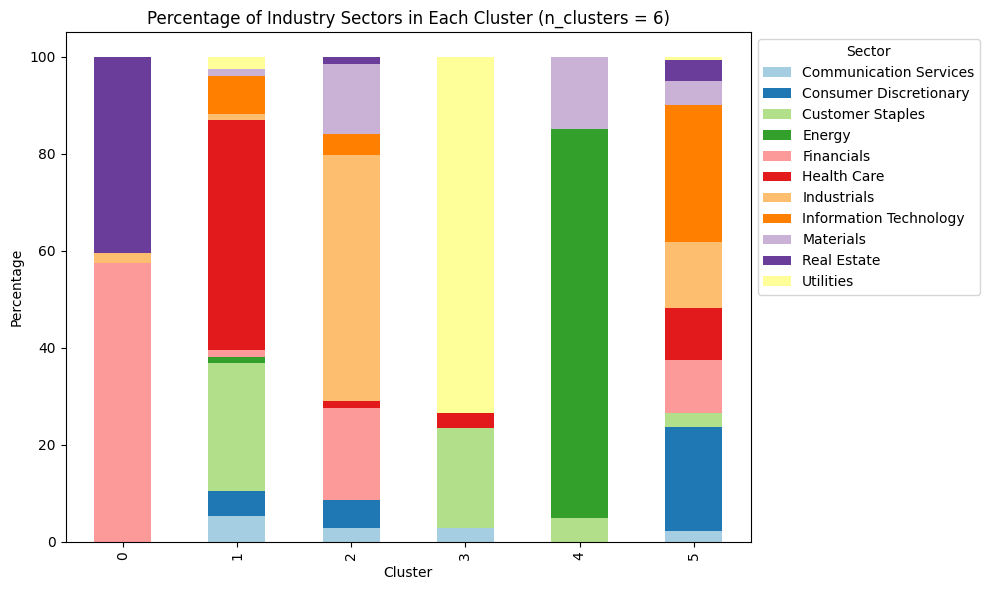

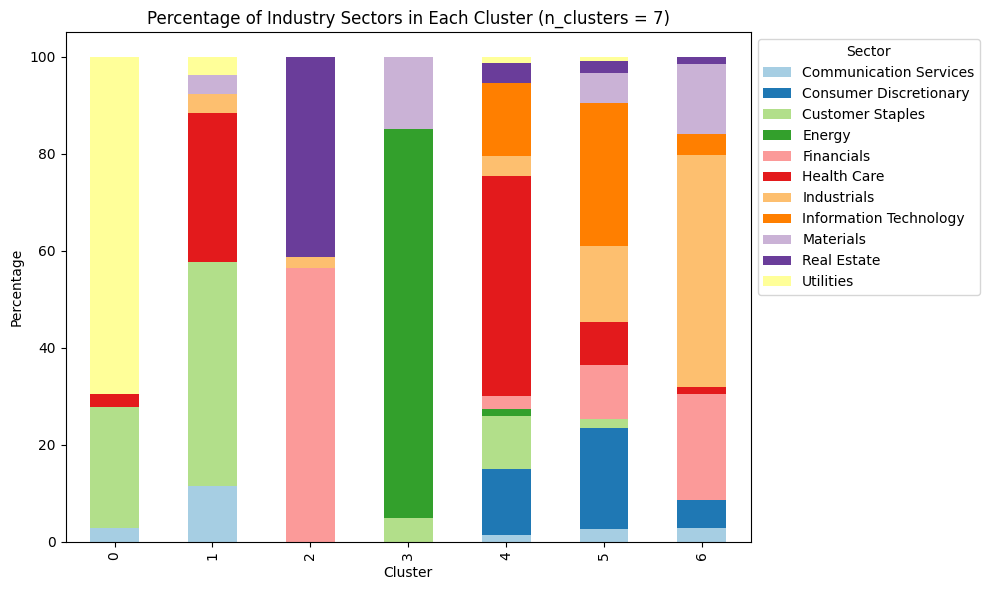

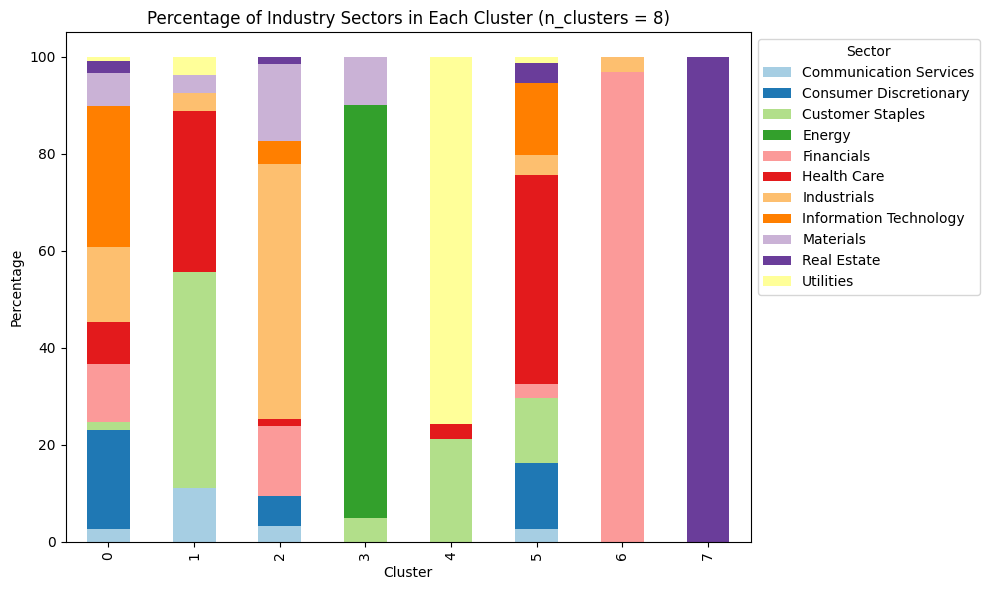

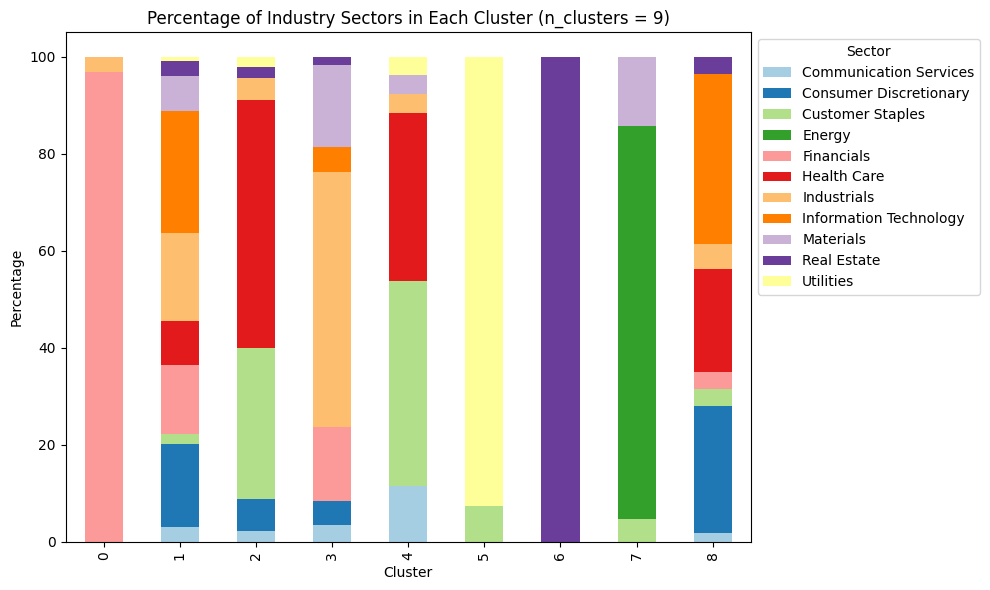

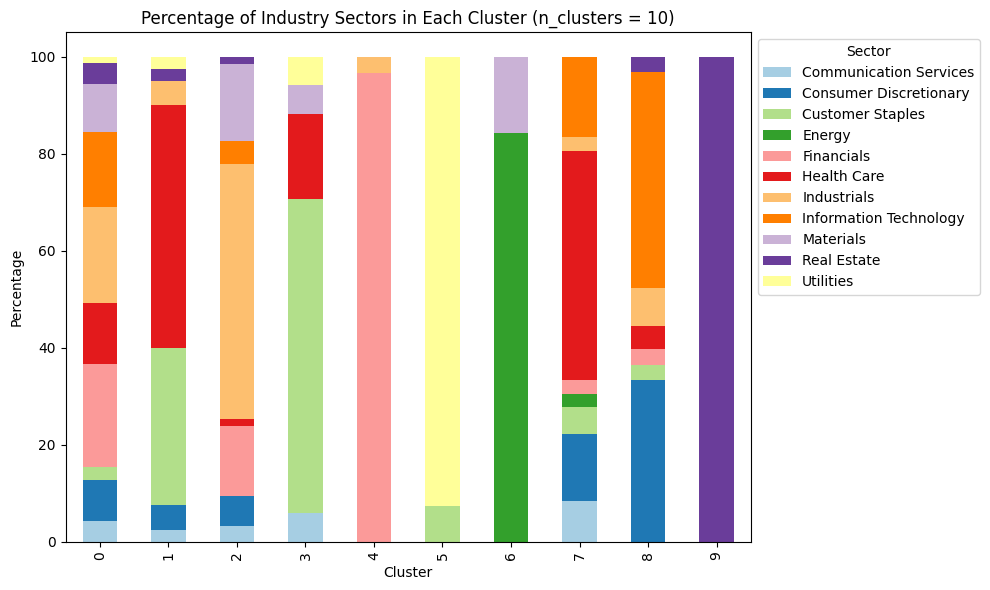

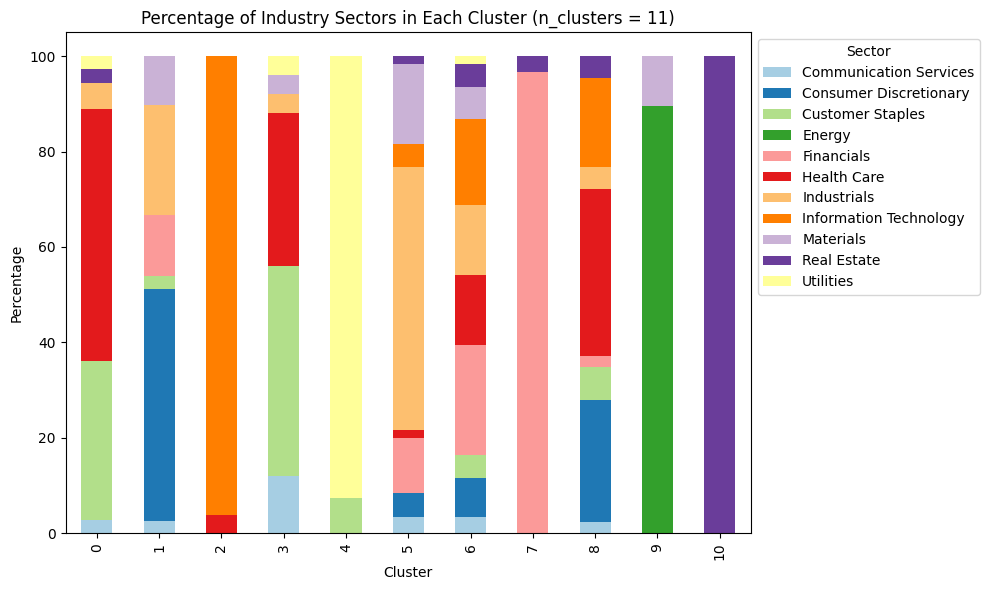

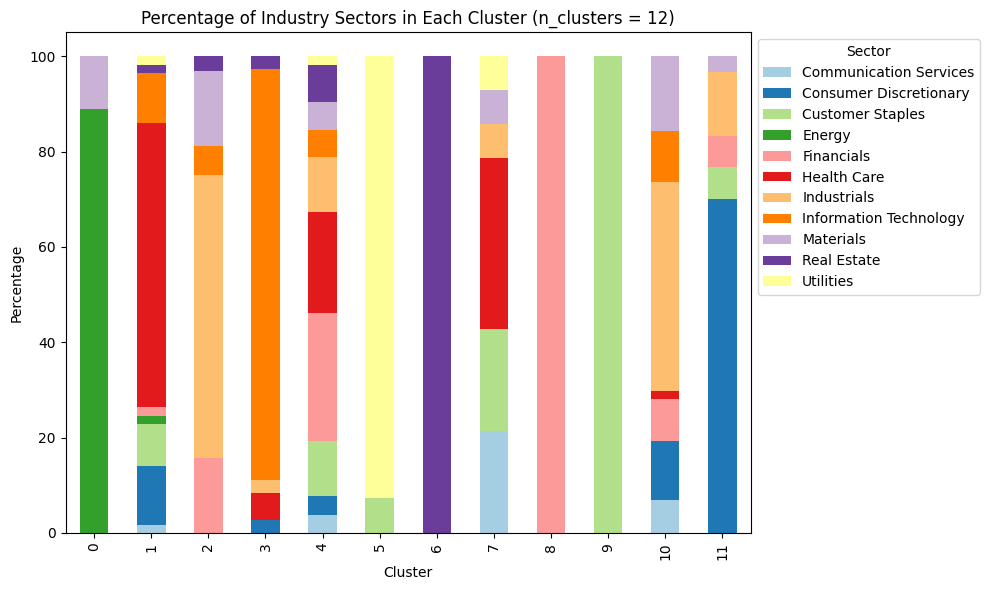

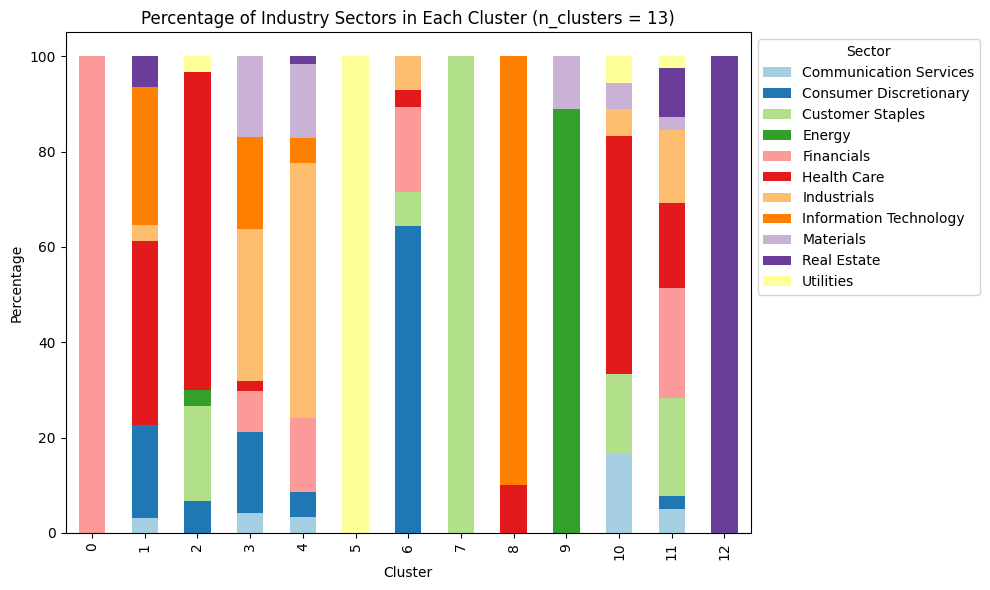

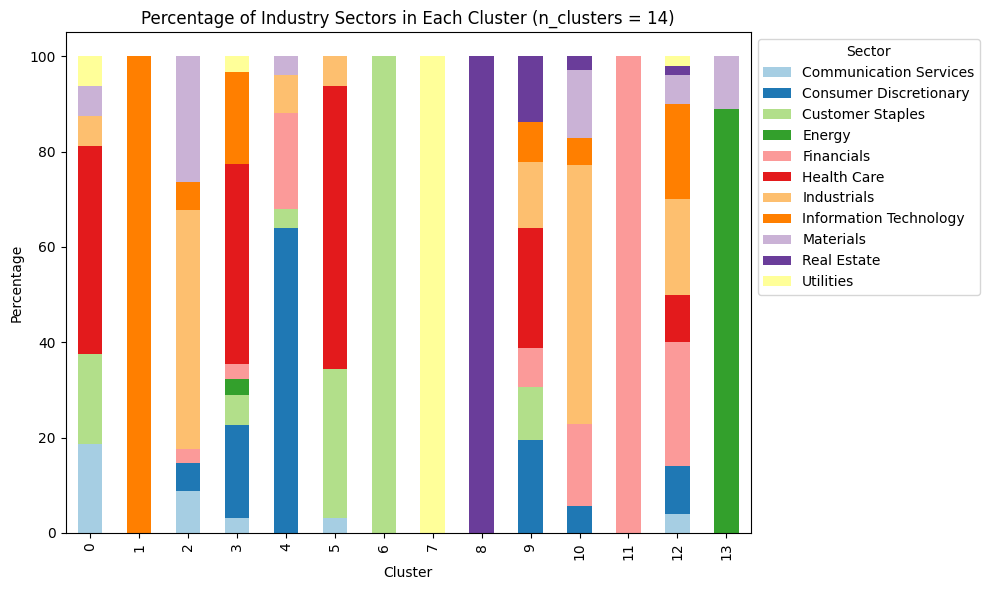

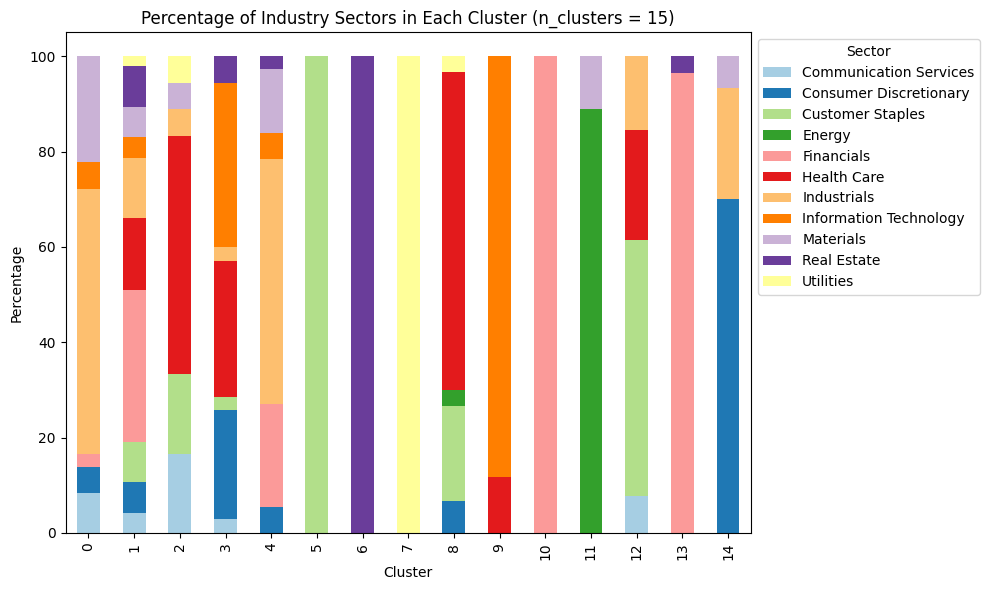

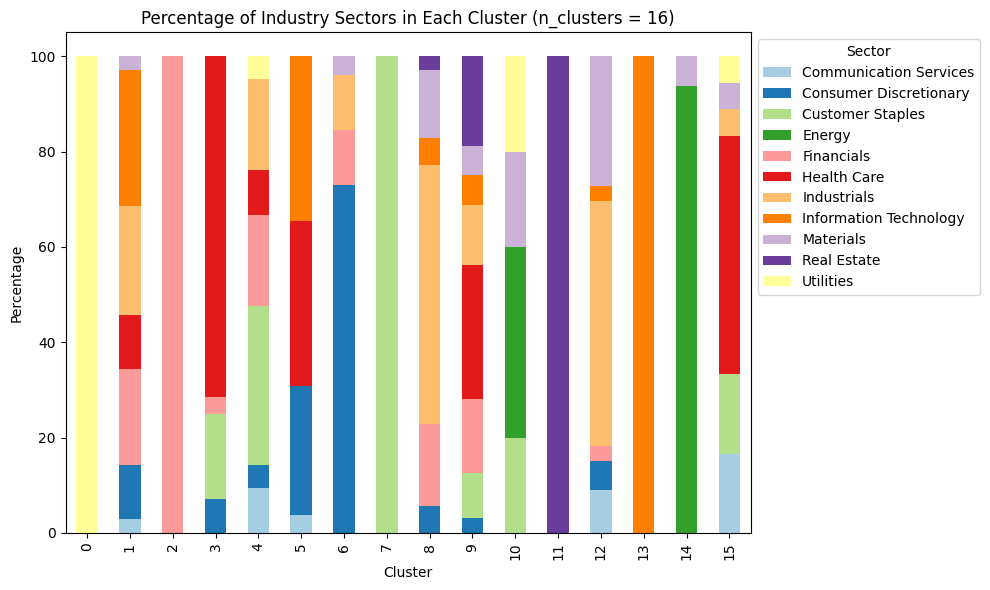

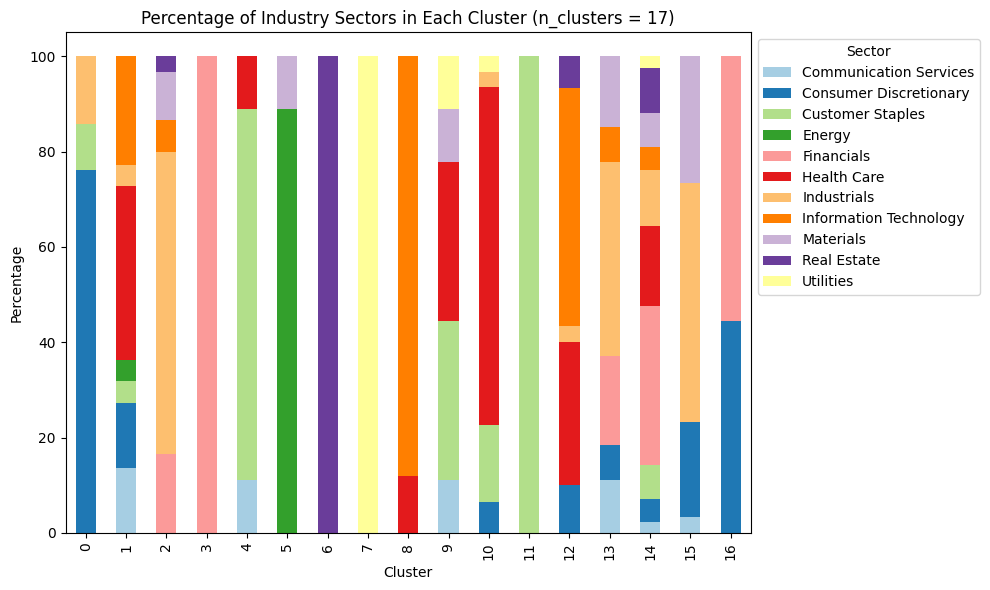

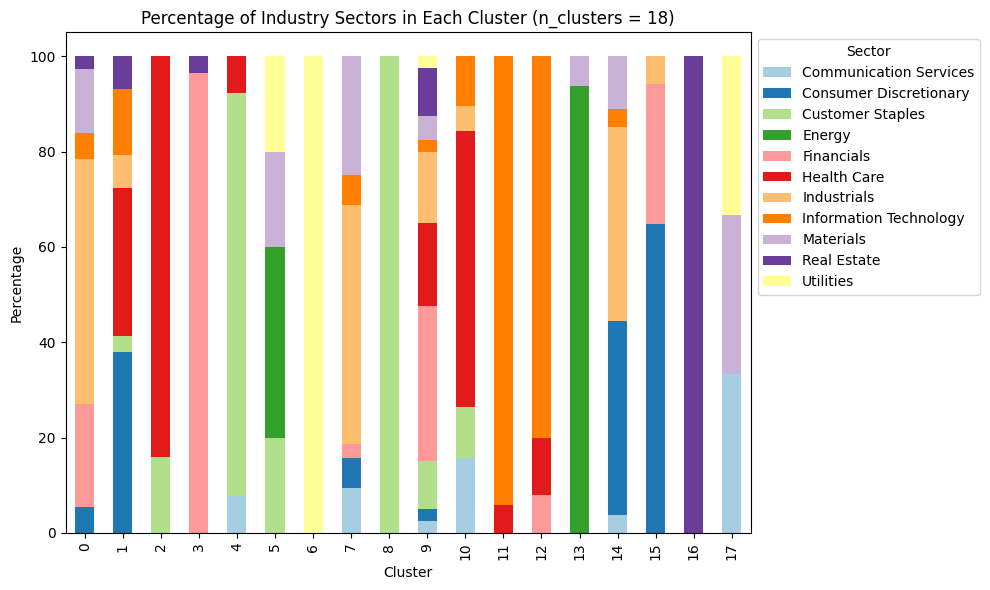

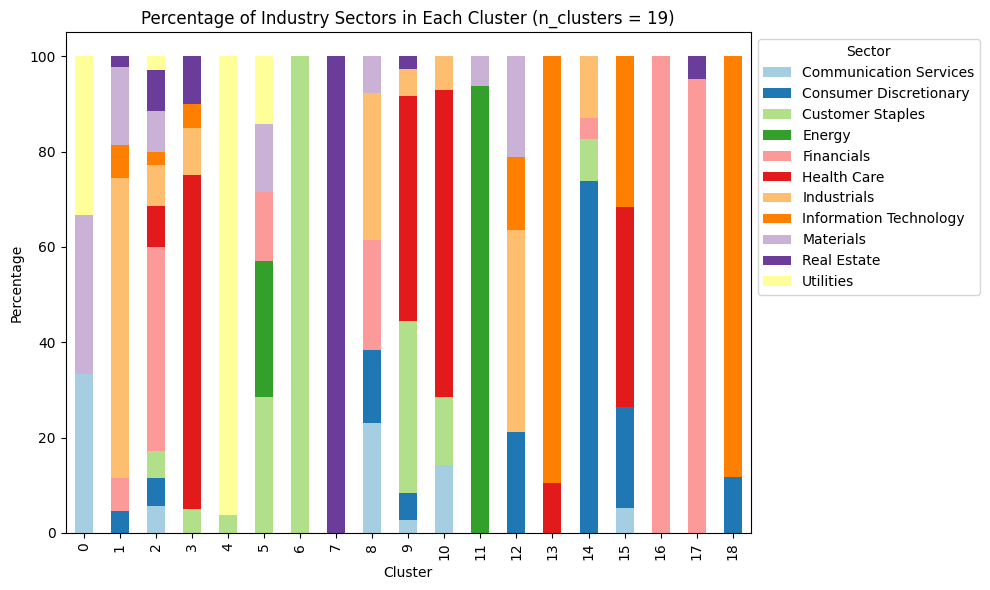

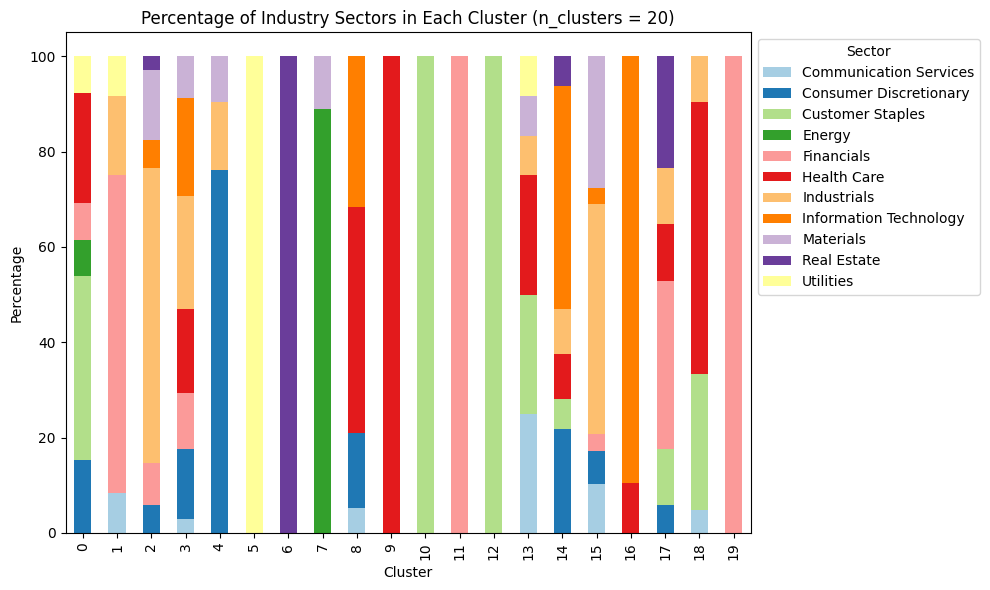

In [81]:
colors = sns.color_palette("Paired", len(industry_sector['Industry Sector'].unique()))

# Stacked bar charts
for n_cluster in n_cluster_options:
    sector_percentage_df = sector_percentage_dfs[n_cluster]

    ax = sector_percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#####**5.1.3 Percentage of cluster in each industry sector**

In [86]:
cluster_percentage_dfs = {}

for n_cluster in n_cluster_options:
    cluster_labels = kmeans_results[n_cluster]
    cluster_counts = pd.DataFrame({'Cluster': cluster_labels, 'Industry Sector': true_labels}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    cluster_percentages = cluster_counts.div(cluster_counts.sum(axis=0), axis=1) * 100
    cluster_percentage_dfs[n_cluster] = cluster_percentages

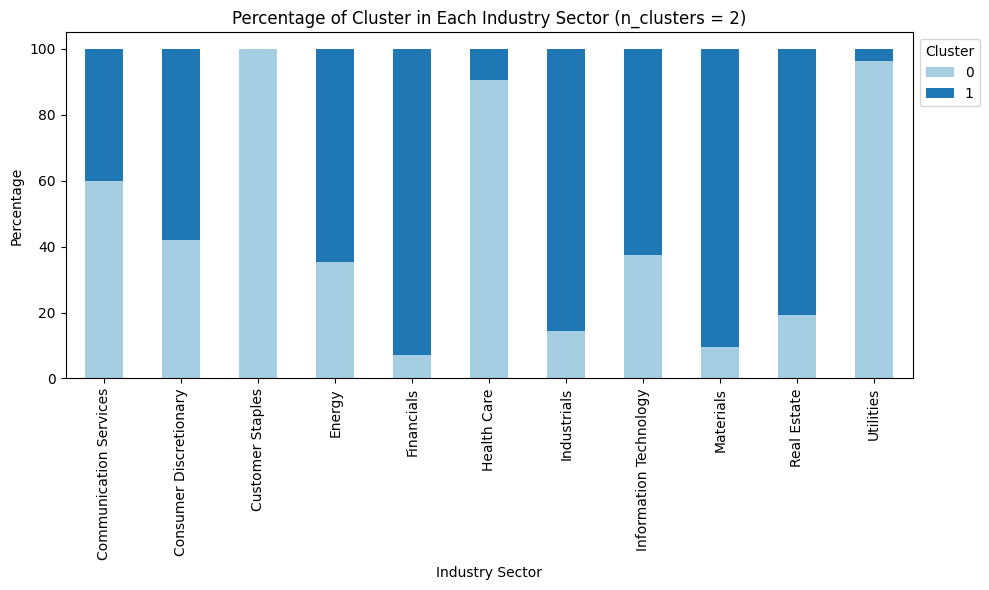

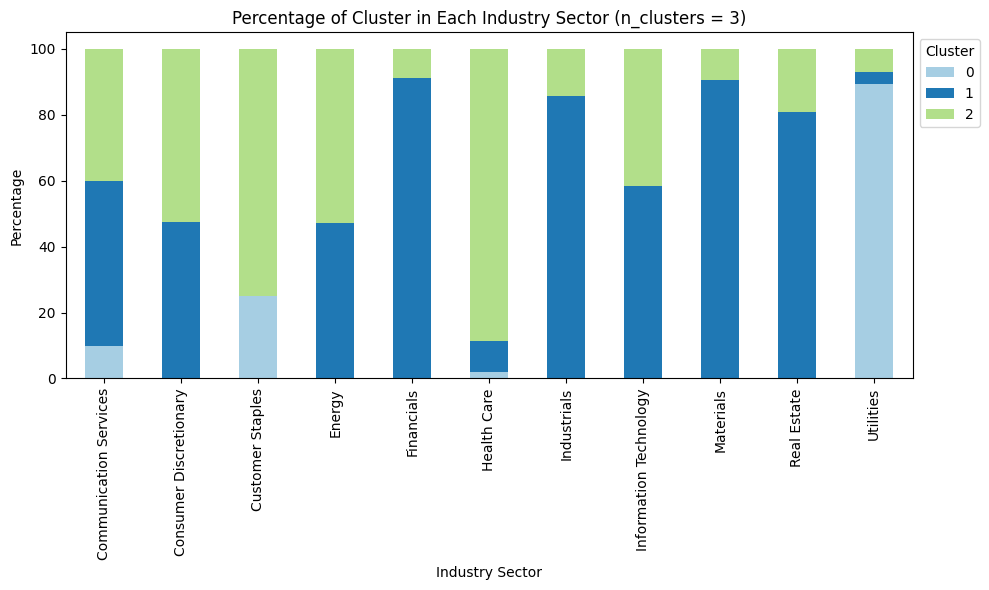

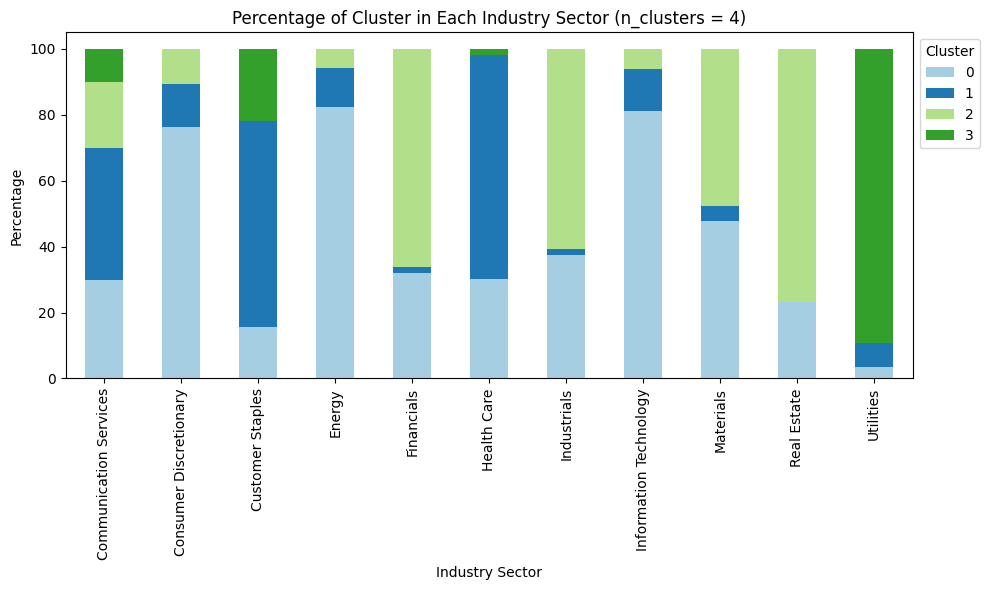

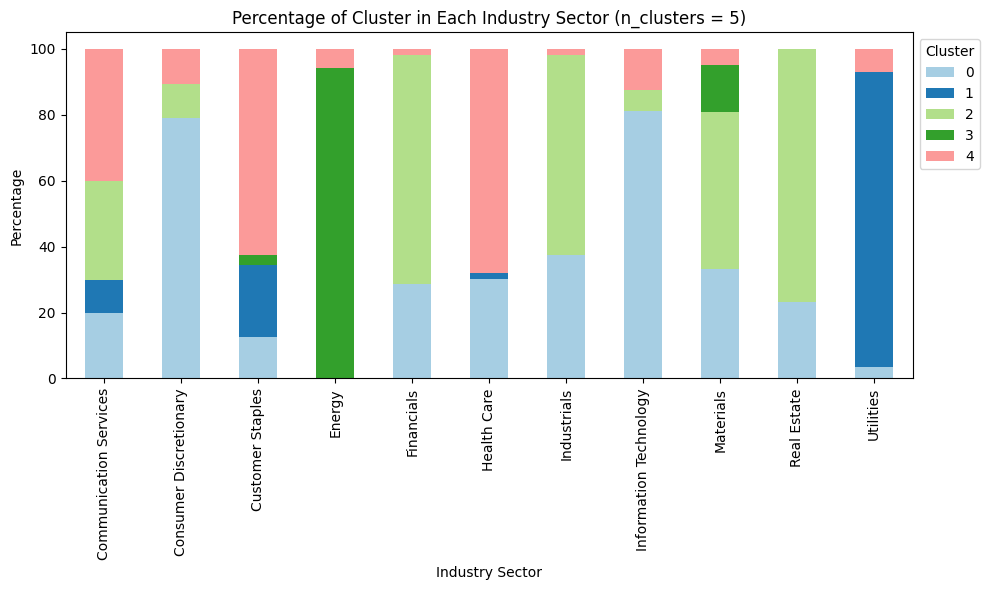

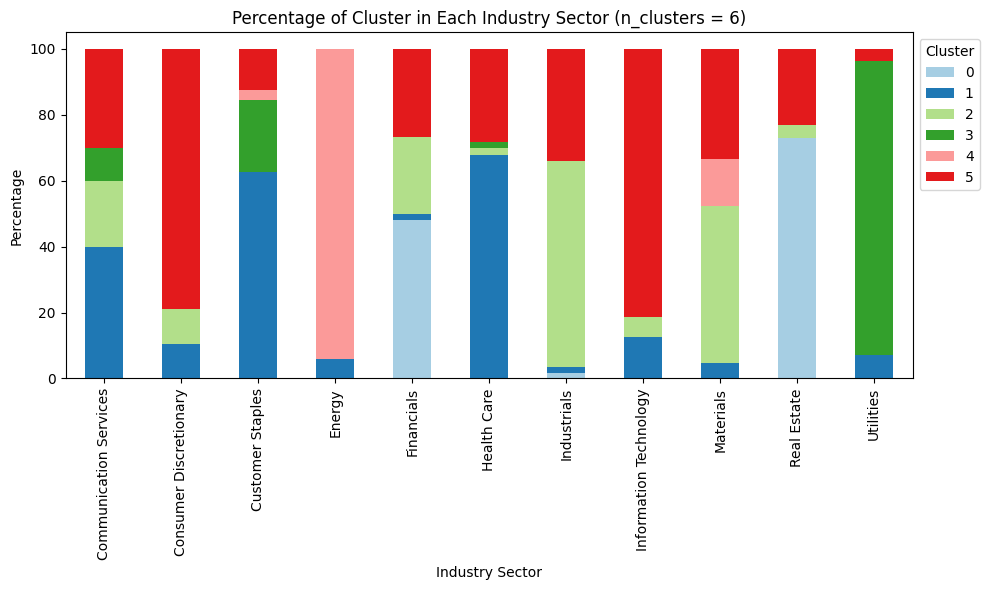

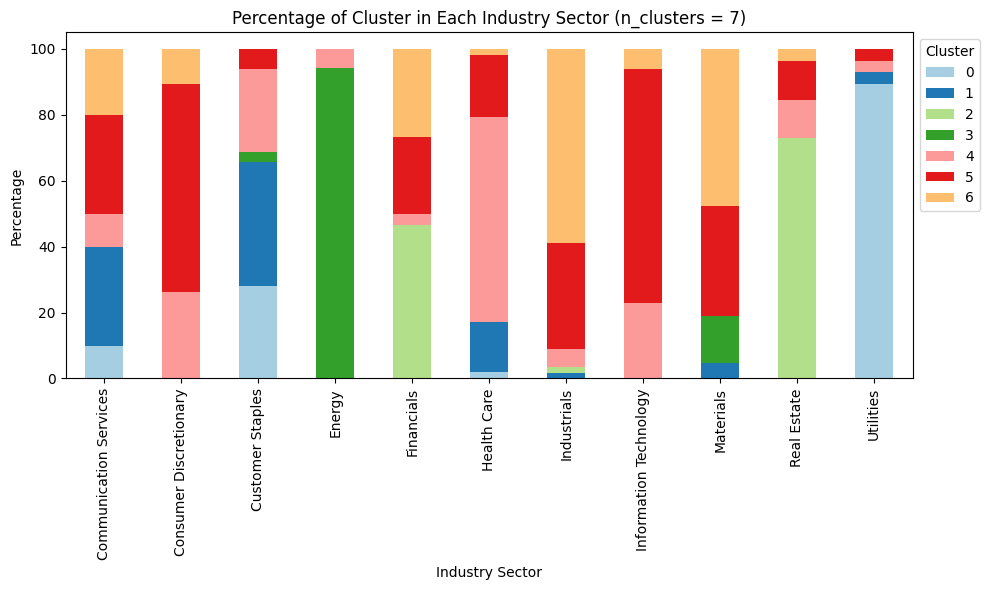

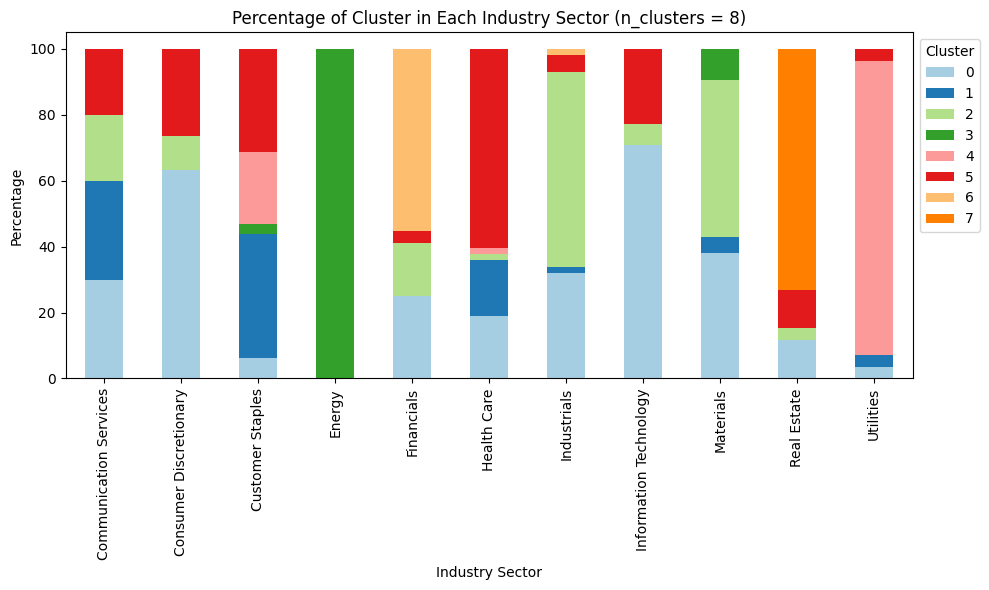

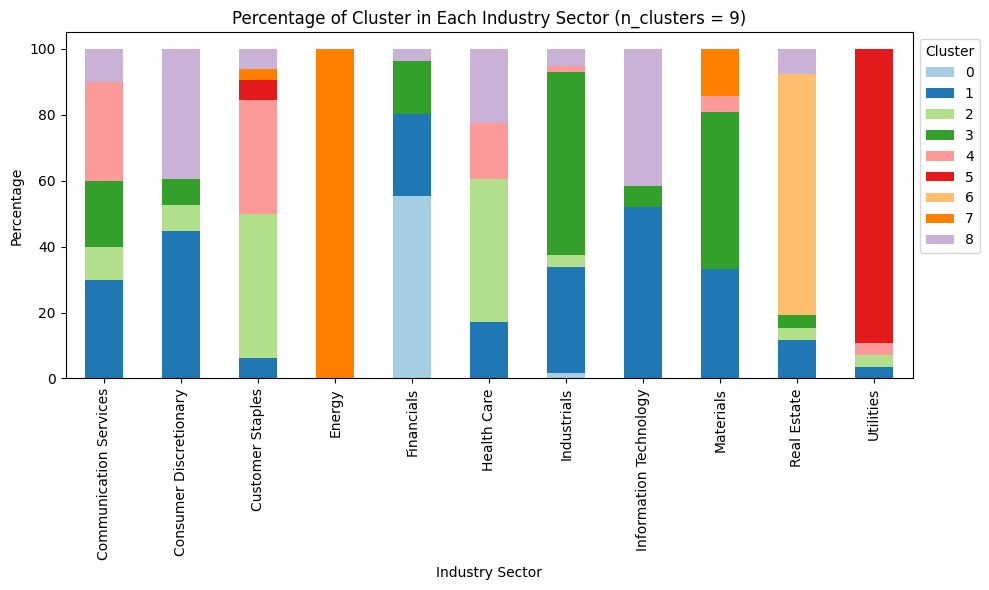

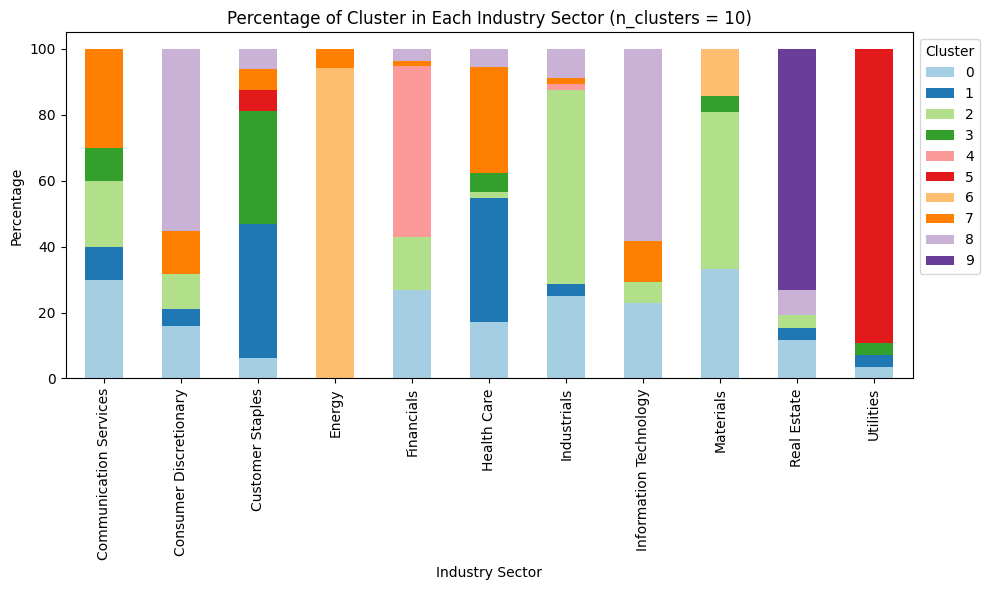

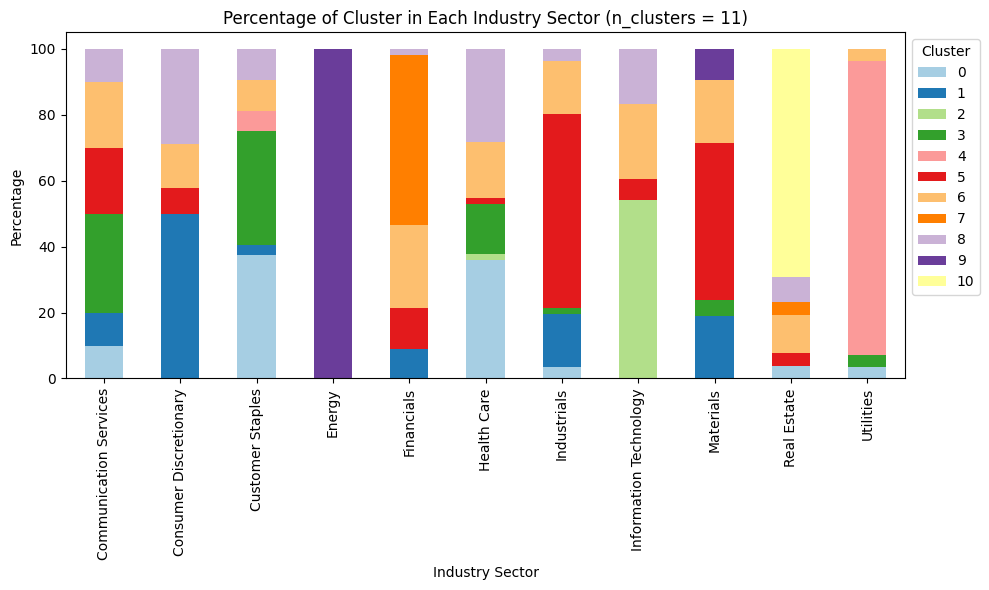

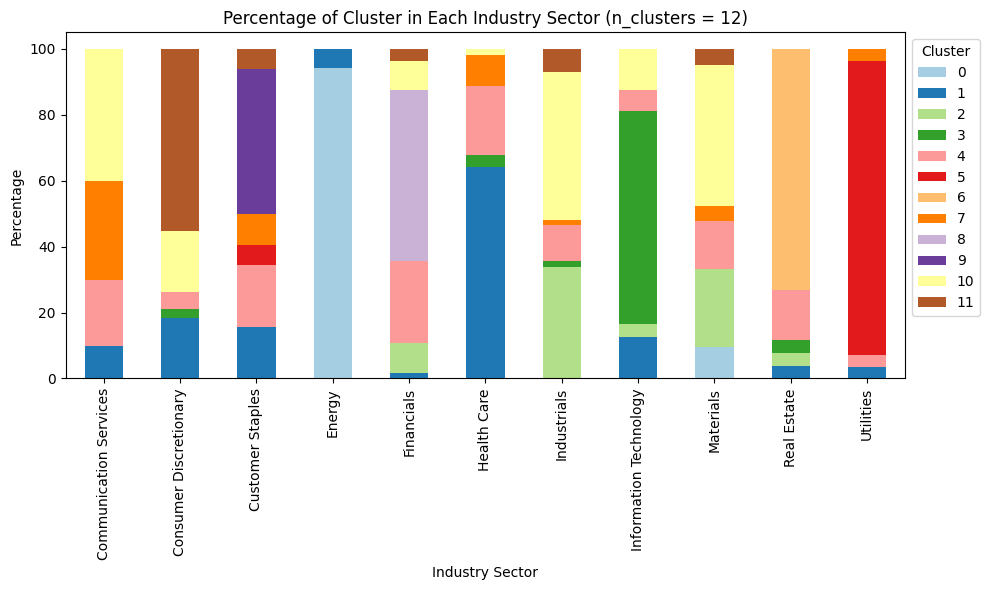

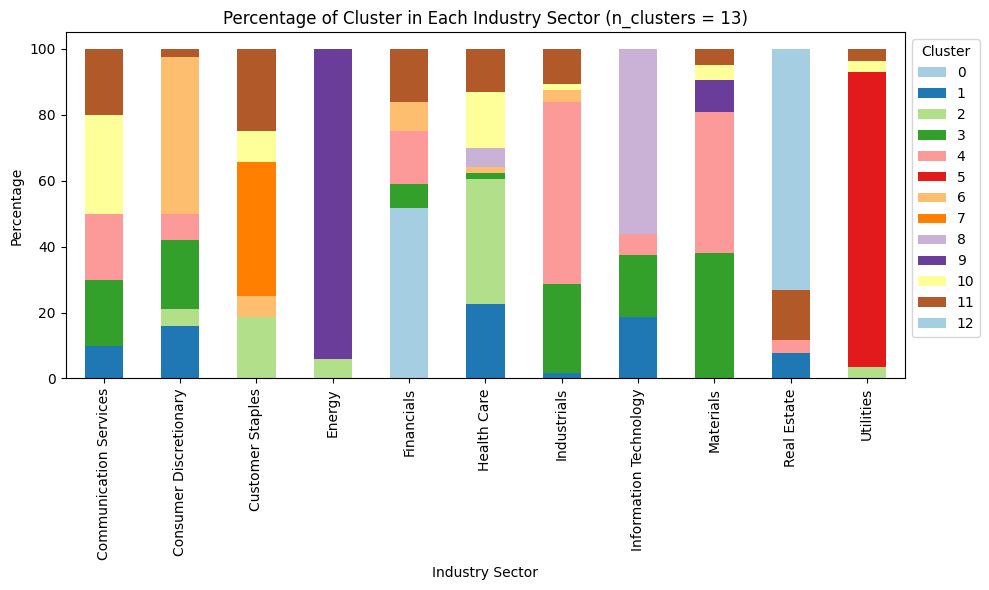

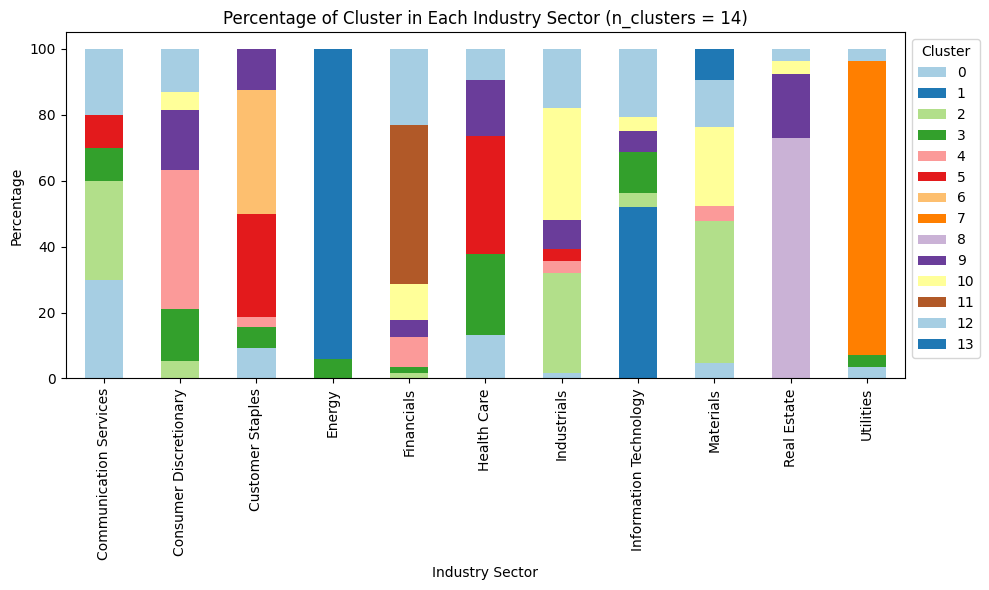

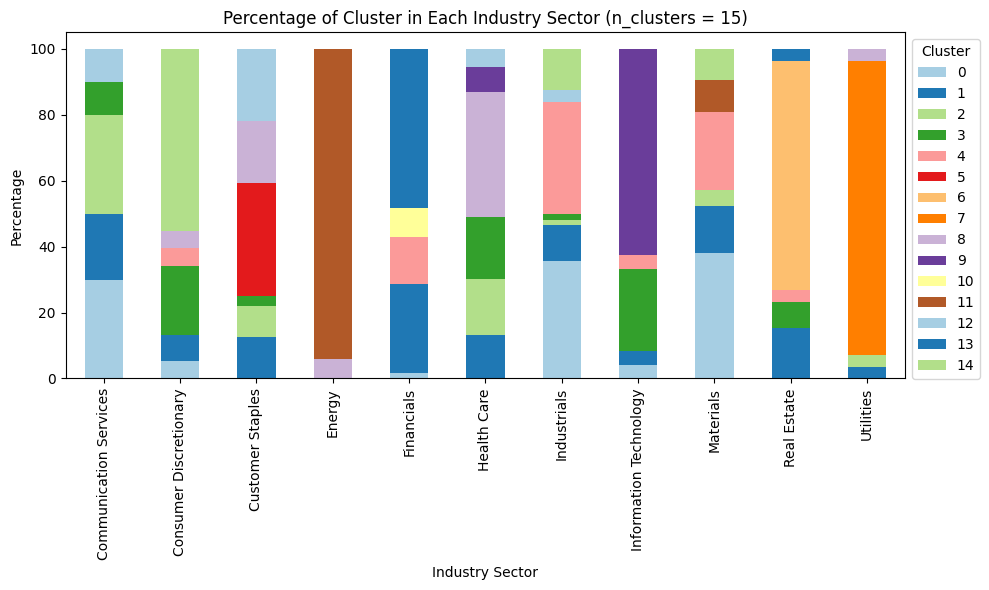

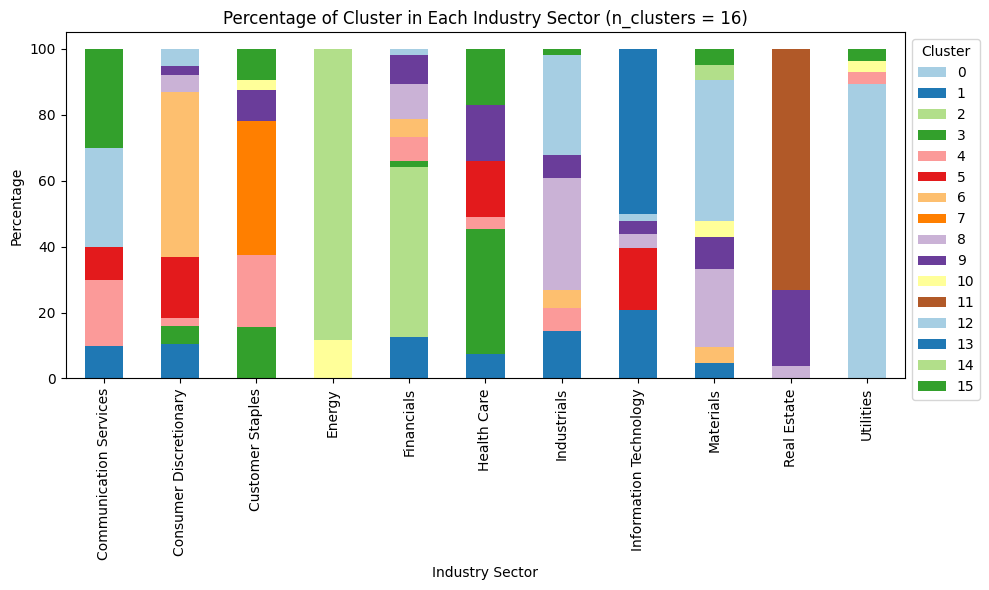

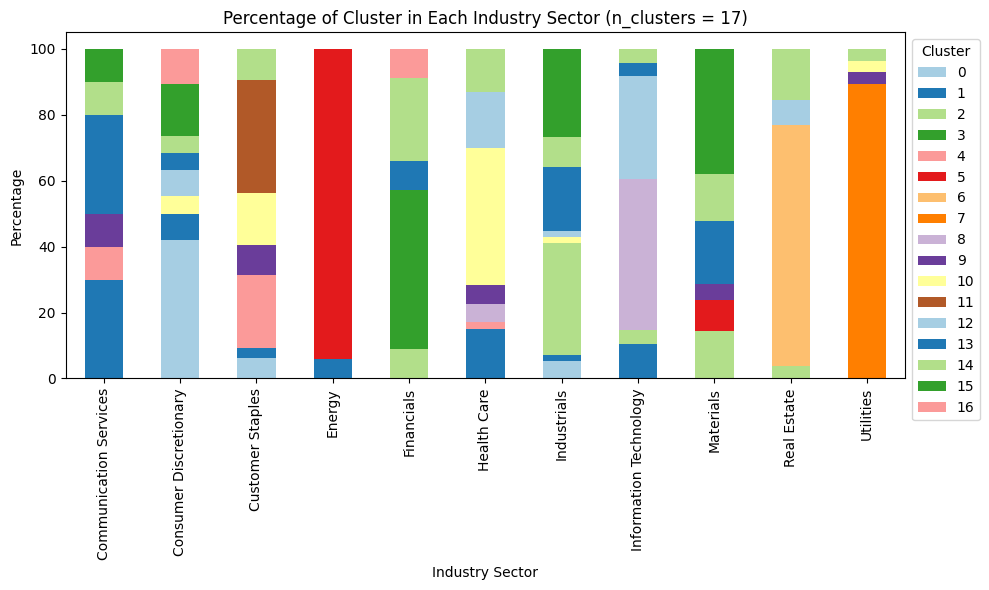

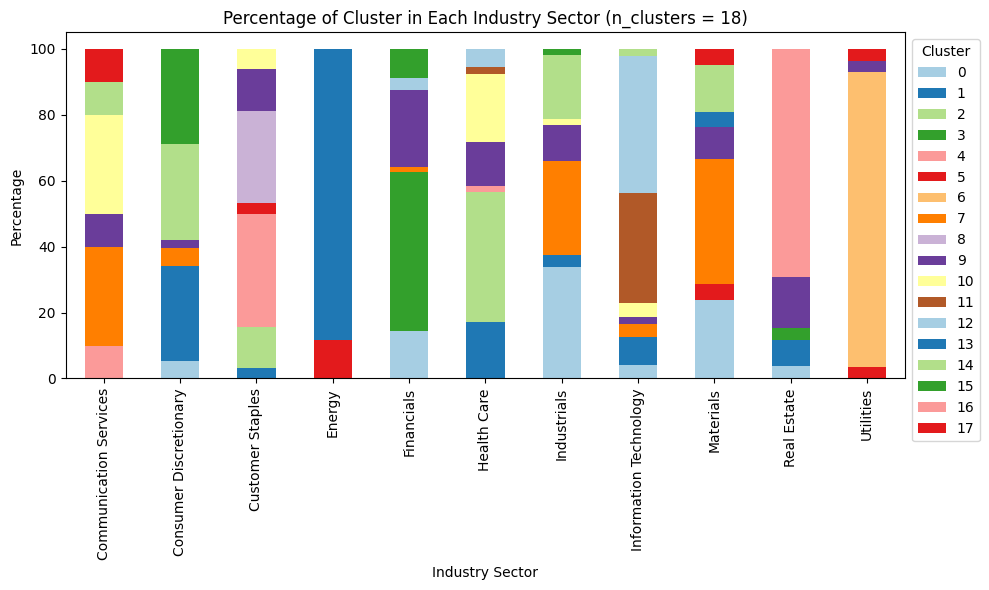

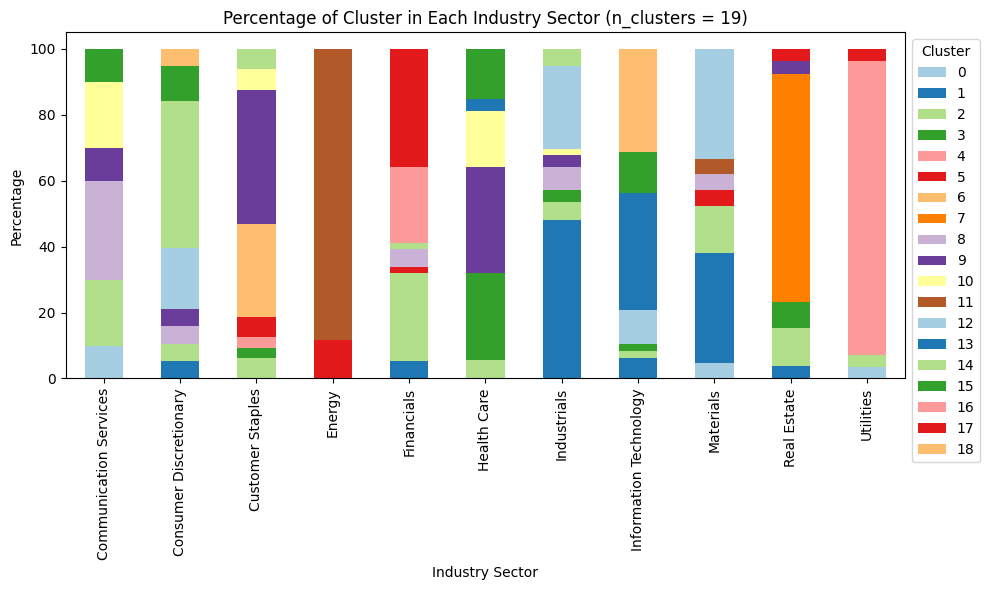

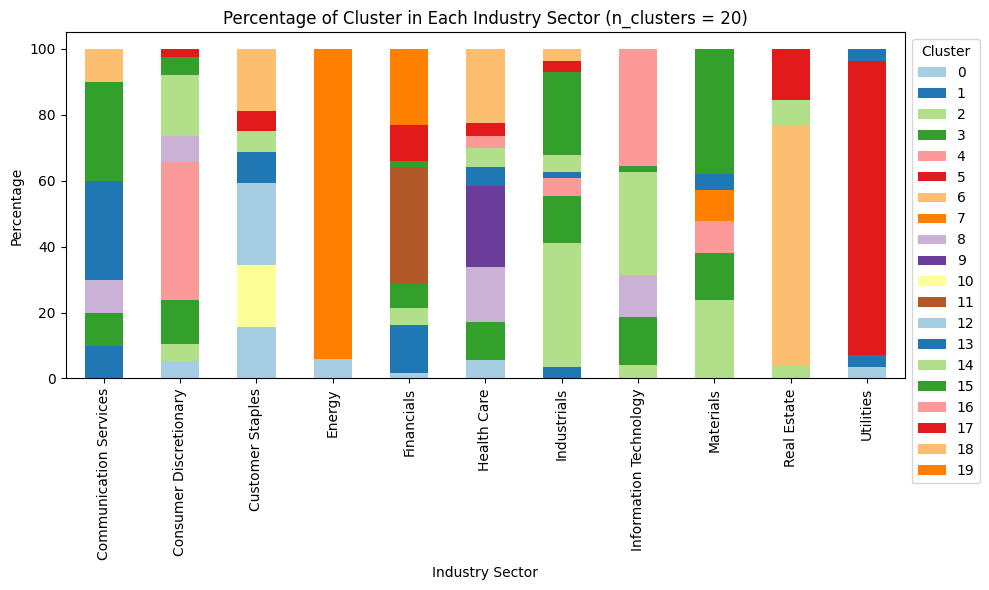

In [88]:
# Stacked bar charts
for n_cluster in n_cluster_options:
    colors = sns.color_palette("Paired", n_cluster)

    cluster_percentage_df = cluster_percentage_dfs[n_cluster]

    ax = cluster_percentage_df.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = {n_cluster})')
    plt.xlabel('Industry Sector')
    plt.ylabel('Percentage')
    plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

####**5.2 Scatterplot**

#####**5.2.1 n_cluster = 3**

In [98]:
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(correlation_matrix)

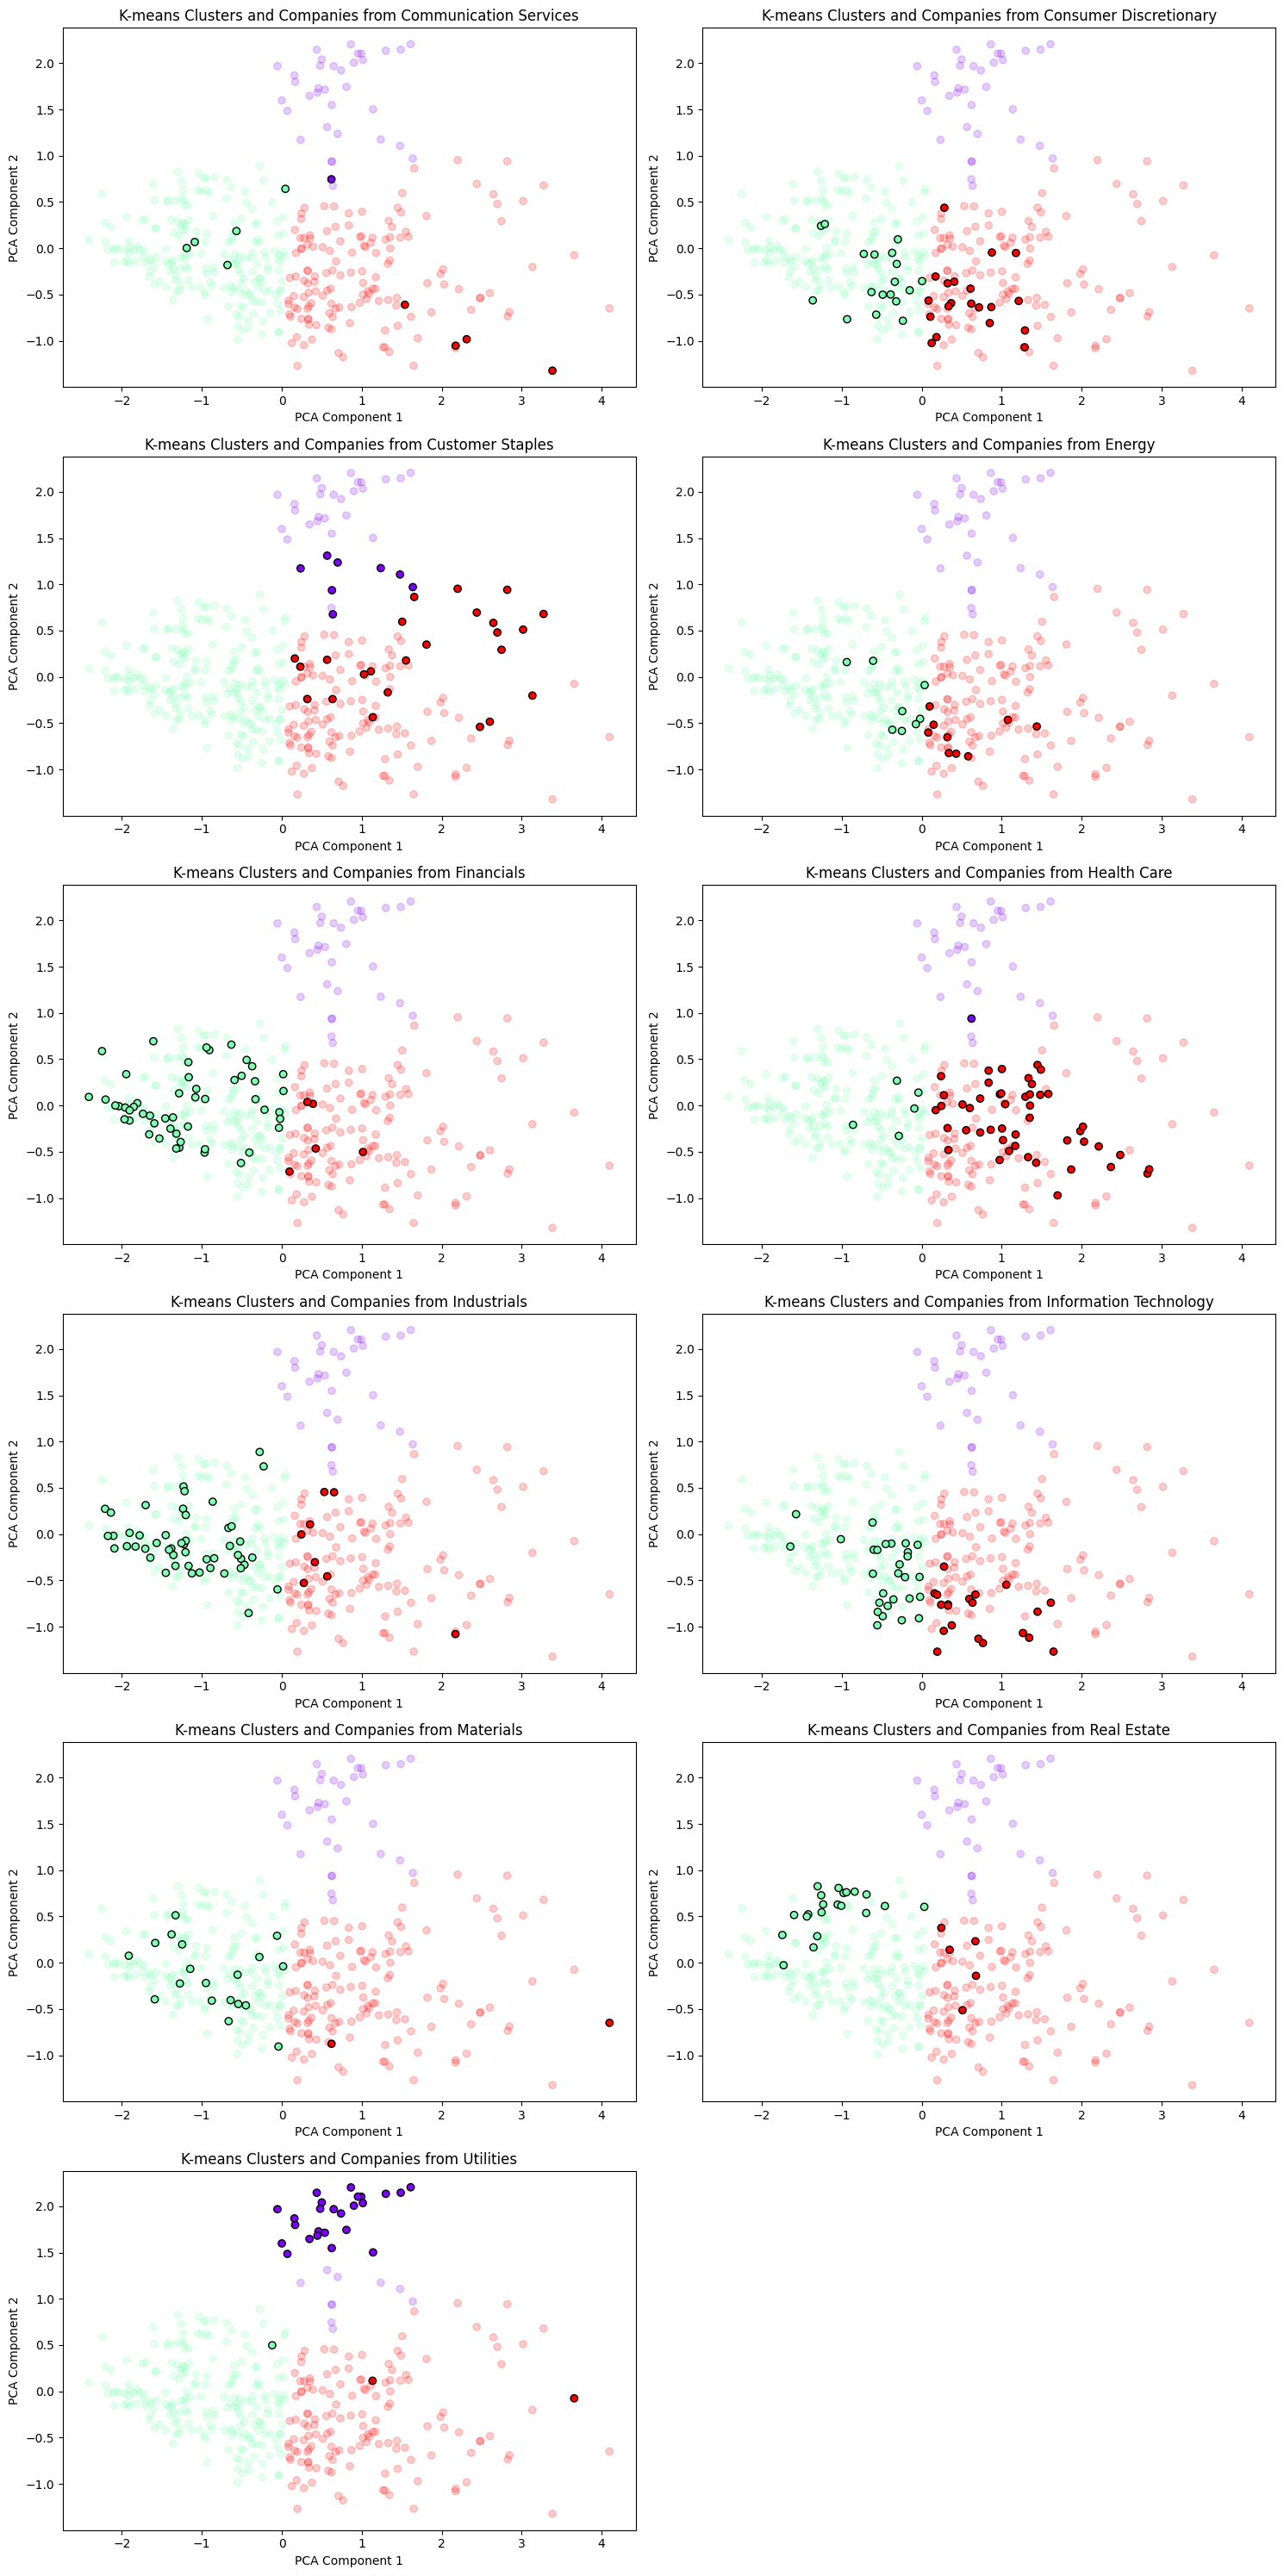

In [99]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html

tickers_category = ['Communication Services', 'Consumer Discretionary', 'Customer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']

figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()
kmeans_labels = kmeans_results[3]

# Create a colormap from the k-means labels
unique_labels_length = len(np.unique(kmeans_labels))
cmap = ListedColormap(plt.cm.rainbow(np.linspace(0, 1, unique_labels_length)))
colors = cmap(kmeans_labels)

for i, ax in enumerate(axis):
    if i >= len(tickers_category):
        ax.axis('off')
        continue

    highlighted_mask = np.zeros(reduced_data.shape[0], dtype=bool)
    ticker_list = industry_sector_ordered[industry_sector_ordered['Industry Sector'] == tickers_category[i]]['index'].to_numpy()

    # Mark the highlighted tickers
    for ticker in ticker_list:
        if ticker in correlation_matrix.columns:
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            highlighted_mask[ticker_index] = True

    # Other tickers with reduced opacity
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, alpha=0.2)

    # Highlighted tickers with full opacity
    ax.scatter(reduced_data[highlighted_mask, 0], reduced_data[highlighted_mask, 1], c=colors[highlighted_mask], edgecolors='black', alpha=1.0)

    ax.set_title(f'K-means Clusters and Companies from {tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

#####**5.2.2 n_cluster = 5**

In [91]:
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(correlation_matrix)

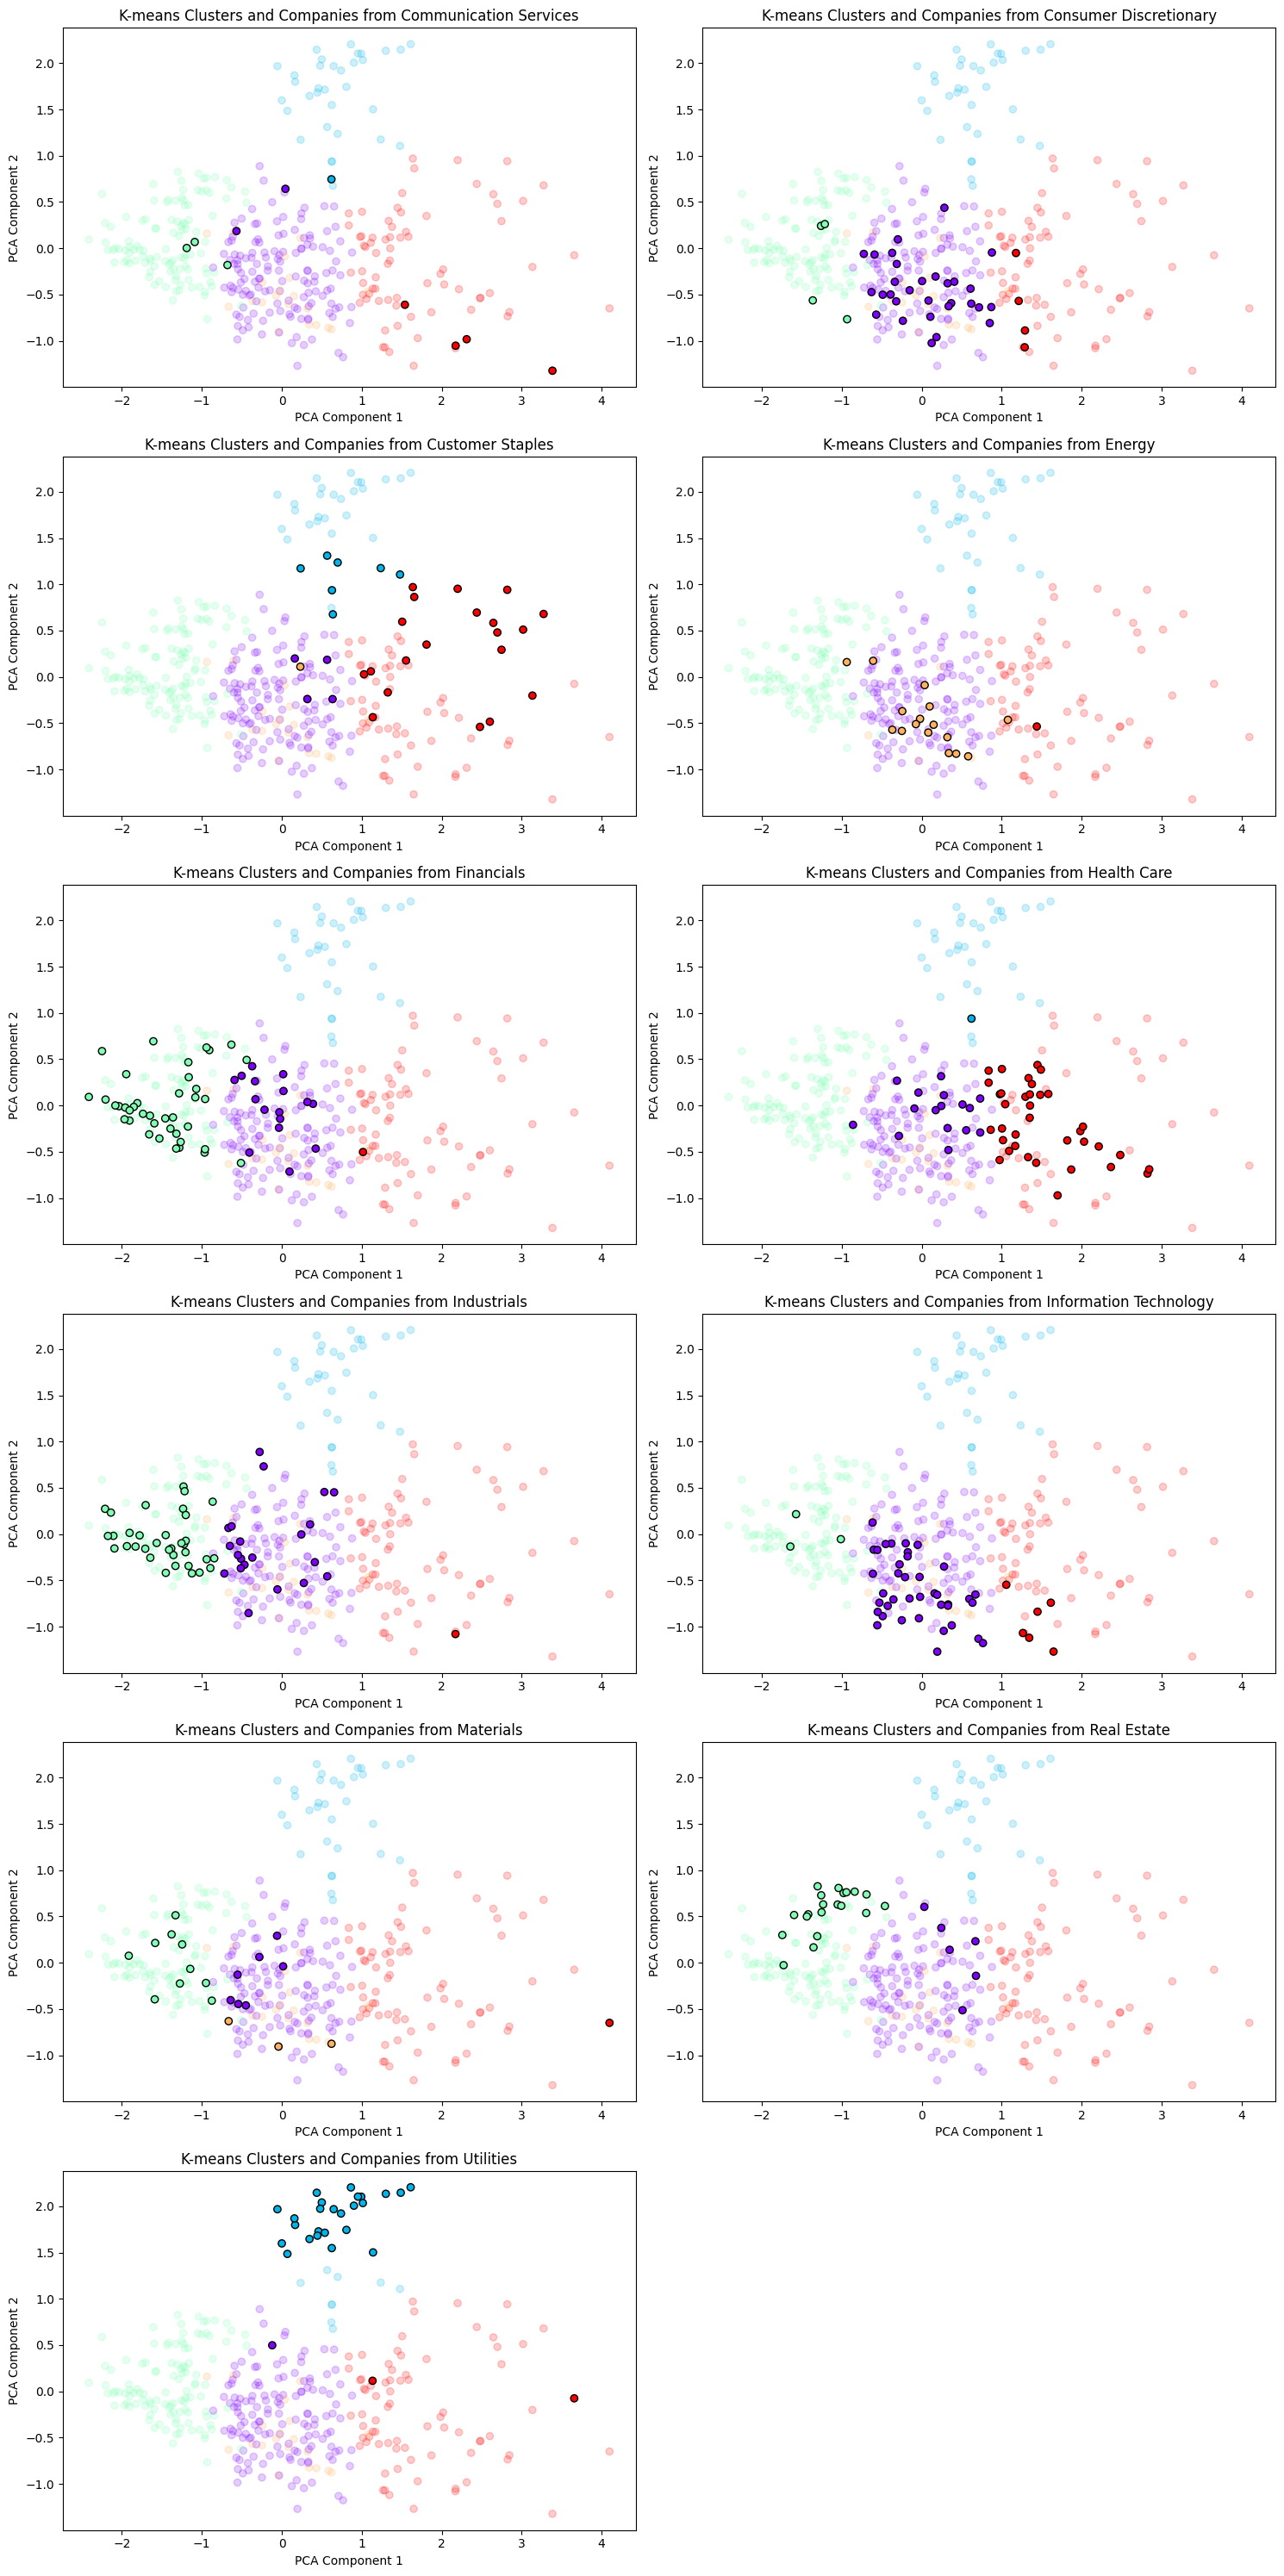

In [97]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html

tickers_category = ['Communication Services', 'Consumer Discretionary', 'Customer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']

figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()
kmeans_labels = kmeans_results[5]

# Create a colormap from the k-means labels
unique_labels_length = len(np.unique(kmeans_labels))
cmap = ListedColormap(plt.cm.rainbow(np.linspace(0, 1, unique_labels_length)))
colors = cmap(kmeans_labels)

for i, ax in enumerate(axis):
    if i >= len(tickers_category):
        ax.axis('off')
        continue

    highlighted_mask = np.zeros(reduced_data.shape[0], dtype=bool)
    ticker_list = industry_sector_ordered[industry_sector_ordered['Industry Sector'] == tickers_category[i]]['index'].to_numpy()

    # Mark the highlighted tickers
    for ticker in ticker_list:
        if ticker in correlation_matrix.columns:
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            highlighted_mask[ticker_index] = True

    # Other tickers with reduced opacity
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, alpha=0.2)

    # Highlighted tickers with full opacity
    ax.scatter(reduced_data[highlighted_mask, 0], reduced_data[highlighted_mask, 1], c=colors[highlighted_mask], edgecolors='black', alpha=1.0)

    ax.set_title(f'K-means Clusters and Companies from {tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

###**6. Perform hierarchical clustering**
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering \

https://jbhender.github.io/Stats506/F18/GP/Group15.html

####**6.1 Try out different n_cluster**

#####**6.1.1 Metrics (inertia, silhouette score, etc.)**

In [107]:
def wss_calculation(K, data):
    WSS = []
    for i in range(1, K):
        cluster = AgglomerativeClustering(n_clusters=i + 1)
        labels = cluster.fit_predict(data)
        wss = []
        for j in range(i + 1):
            # extract each cluster according to its index
            cluster_data = data[labels == j]
            cluster_mean = cluster_data.mean(axis=0)
            distance = np.sum(np.square(cluster_data - cluster_mean))
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

In [108]:
WSS = wss_calculation(20, correlation_matrix)

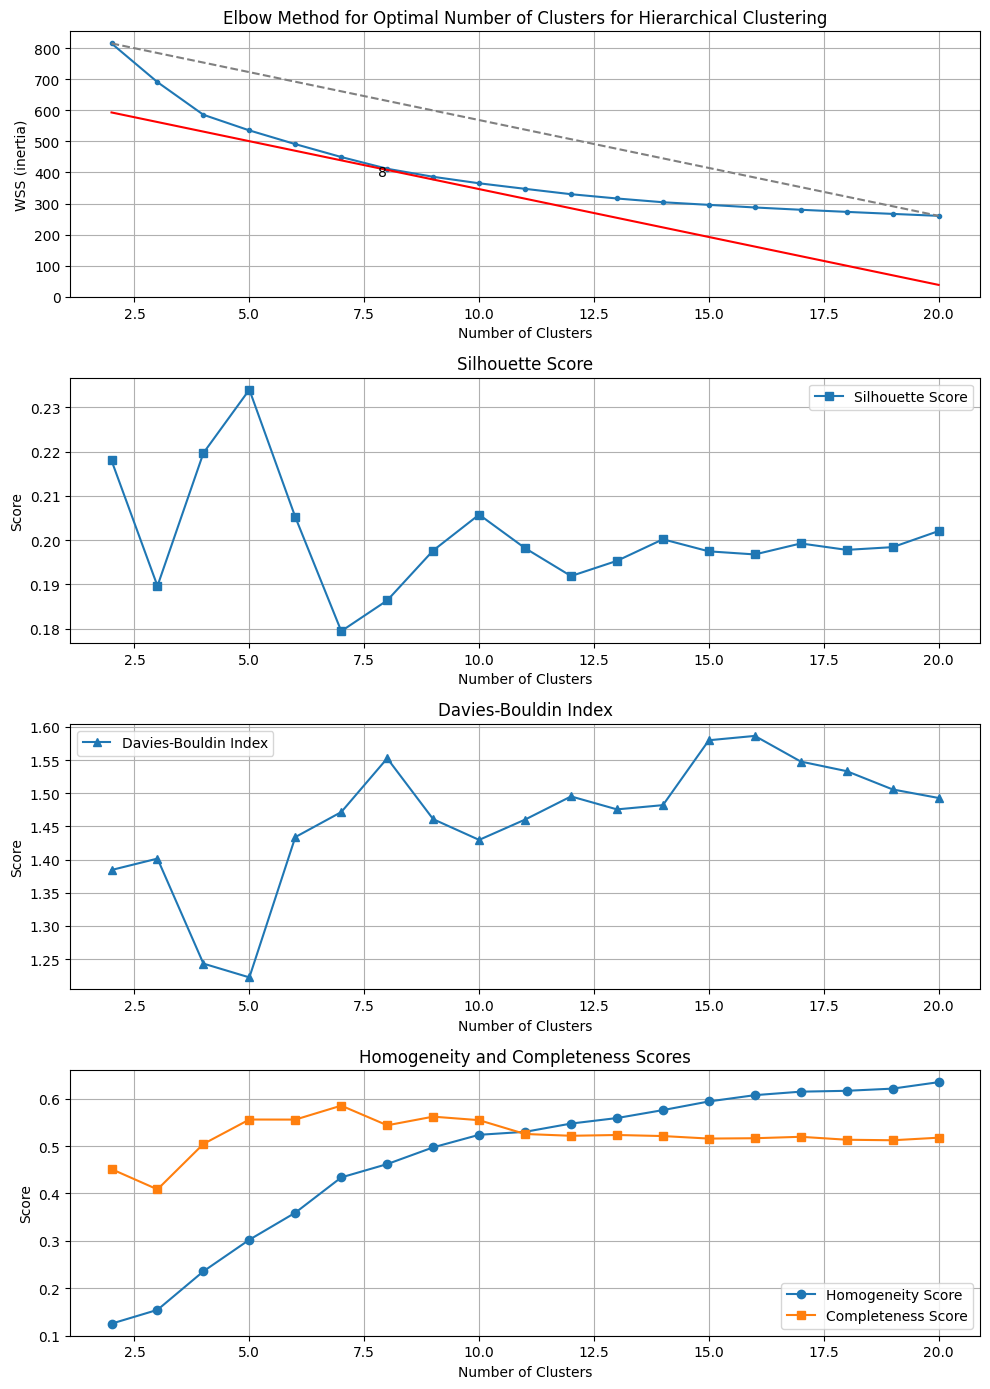

In [116]:
# Test out different values of n_clusters using the elbow method
# Try the numbers between 2 to 20
n_cluster_options = range(2, 21)

silhouette_scores_hierarchical = []
db_scores_hierarchical = []
homogeneity_scores_hierarchical = []
completeness_scores_hierarchical = []
hierarchical_results = {}

for n_cluster in n_cluster_options:
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster)
    hierarchical.fit(correlation_matrix)
    hierarchical_labels = hierarchical.labels_
    hierarchical_results[n_cluster] = hierarchical_labels

    # Record the metrics
    silhouette_scores_hierarchical.append(silhouette_score(correlation_matrix, hierarchical_labels))
    db_scores_hierarchical.append(davies_bouldin_score(correlation_matrix, hierarchical_labels))
    homogeneity_scores_hierarchical.append(homogeneity_score(true_labels, hierarchical_labels))
    completeness_scores_hierarchical.append(completeness_score(true_labels, hierarchical_labels))

start_point = (n_cluster_options[0], WSS[0])
end_point = (n_cluster_options[-1], WSS[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(2, 20)
y_values = slope * x_values + 655

#plot subplots
fig, ax = plt.subplots(4, 1, figsize=(10, 14))

# Plot elbow method (inertia)
ax[0].plot(n_cluster_options, WSS, marker='.')
ax[0].plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
ax[0].plot(x_values, y_values, color='red')
ax[0].text(n_cluster_options[6], inertia_array[6], f'{n_cluster_options[6]}', ha='right', va='bottom')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WSS (inertia)')
ax[0].set_title('Elbow Method for Optimal Number of Clusters for Hierarchical Clustering')
ax[0].grid(True)

# Plot the silhoutte score and davies-bouldin index
ax[1].plot(n_cluster_options, silhouette_scores_hierarchical, marker='s', label='Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Score')
ax[1].set_title('Silhouette Score')
ax[1].legend()
ax[1].grid(True)

ax[2].plot(n_cluster_options, db_scores_hierarchical, marker='^', label='Davies-Bouldin Index')
ax[2].set_xlabel('Number of Clusters')
ax[2].set_ylabel('Score')
ax[2].set_title('Davies-Bouldin Index')
ax[2].legend()
ax[2].grid(True)

ax[3].plot(n_cluster_options, homogeneity_scores_hierarchical, marker='o', label='Homogeneity Score')
ax[3].plot(n_cluster_options, completeness_scores_hierarchical, marker='s', label='Completeness Score')
ax[3].set_xlabel('Number of Clusters')
ax[3].set_ylabel('Score')
ax[3].set_title('Homogeneity and Completeness Scores')
ax[3].legend()
ax[3].grid(True)

plt.tight_layout()
plt.show()

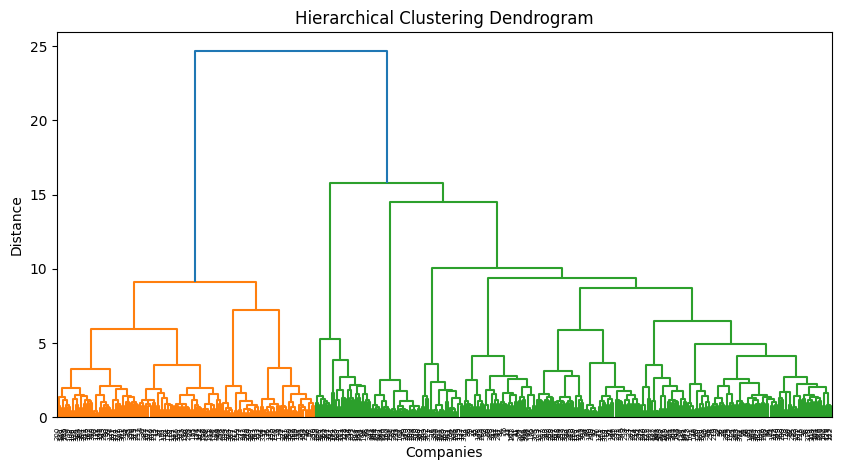

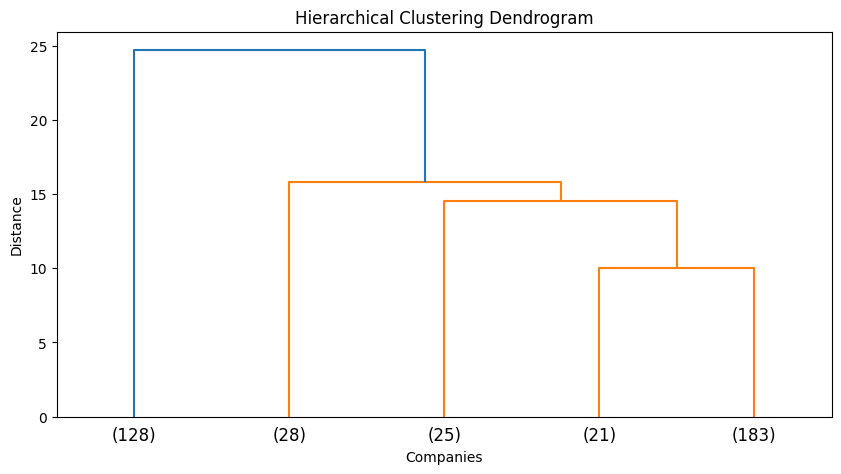

In [117]:
link = linkage(correlation_matrix, method='ward')  #AgglomerativeClustering from scikitlearn uses linkage=ward by default, so use ward here as well

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(link, truncate_mode='lastp', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

#####**6.1.2 Percentage of industry sector in each cluster**

In [118]:
sector_percentage_dfs_hierarchical = {}

for n_cluster in n_cluster_options:
    cluster_labels_hierarchical = hierarchical_results[n_cluster]
    sector_counts_hierarchical = pd.DataFrame({'Cluster': cluster_labels_hierarchical, 'Industry Sector': true_labels}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_hierarchical = sector_counts_hierarchical.div(sector_counts_hierarchical.sum(axis=1), axis=0) * 100
    sector_percentage_dfs_hierarchical[n_cluster] = sector_percentages_hierarchical

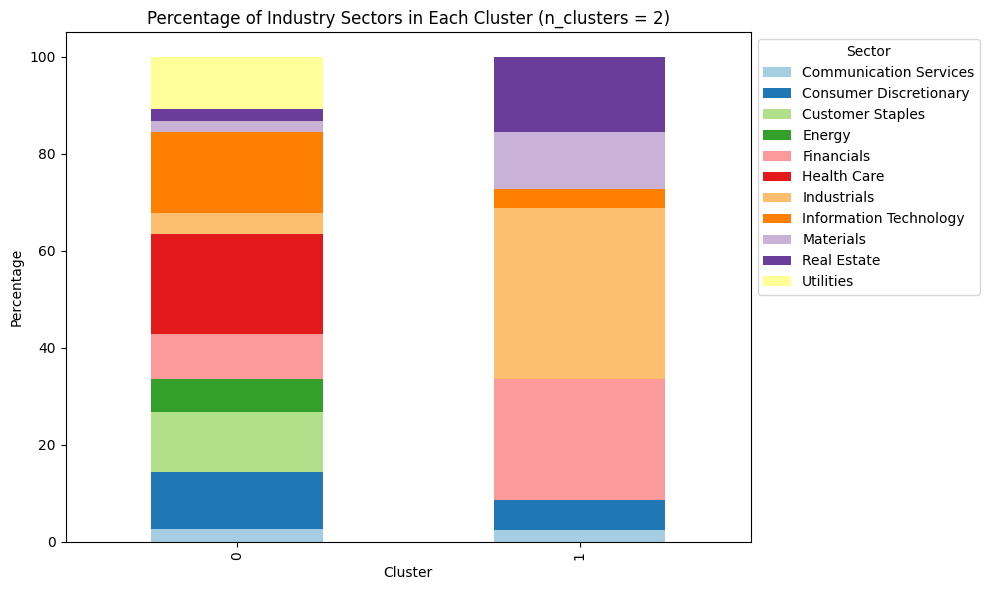

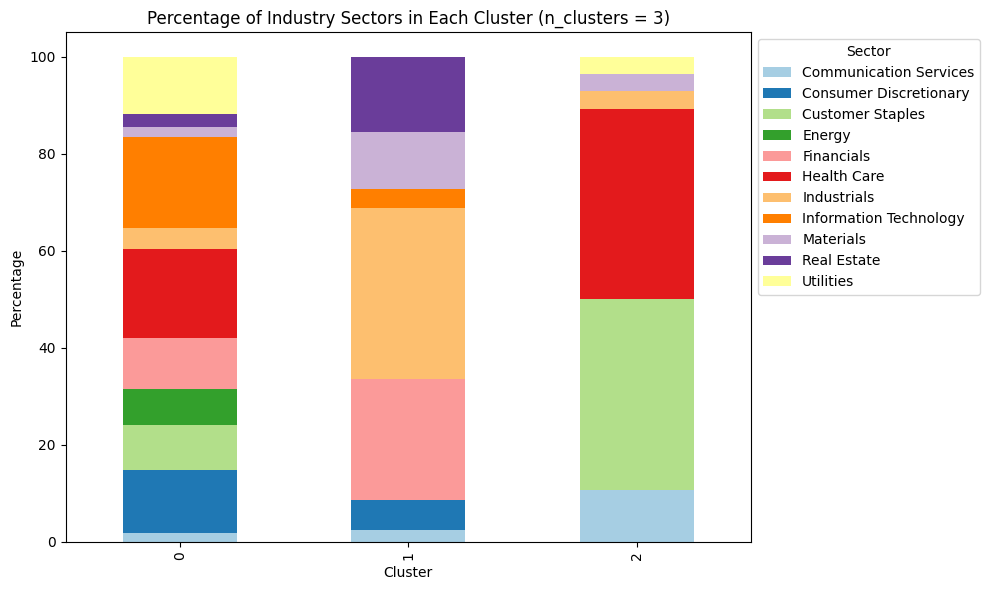

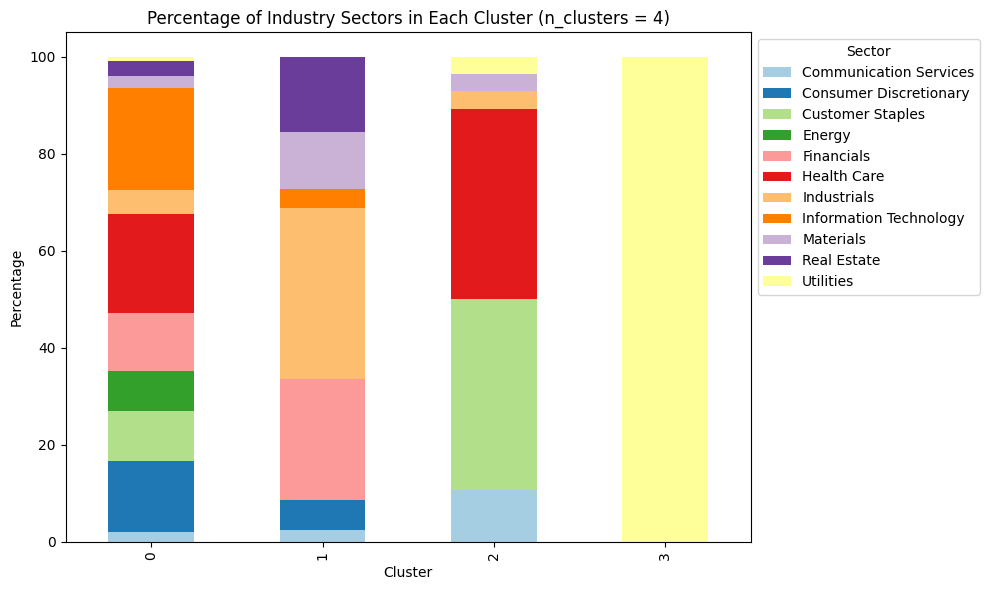

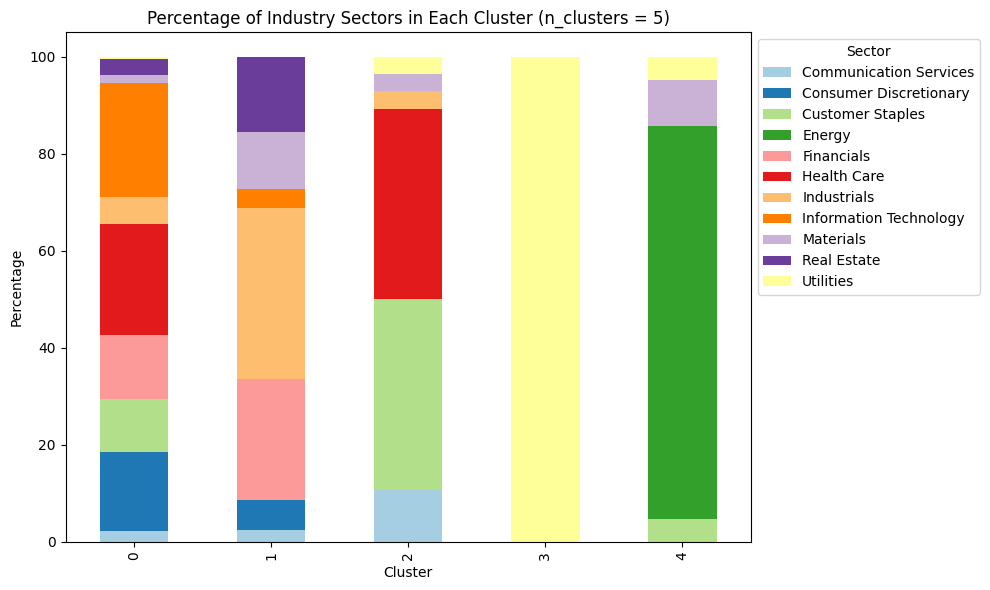

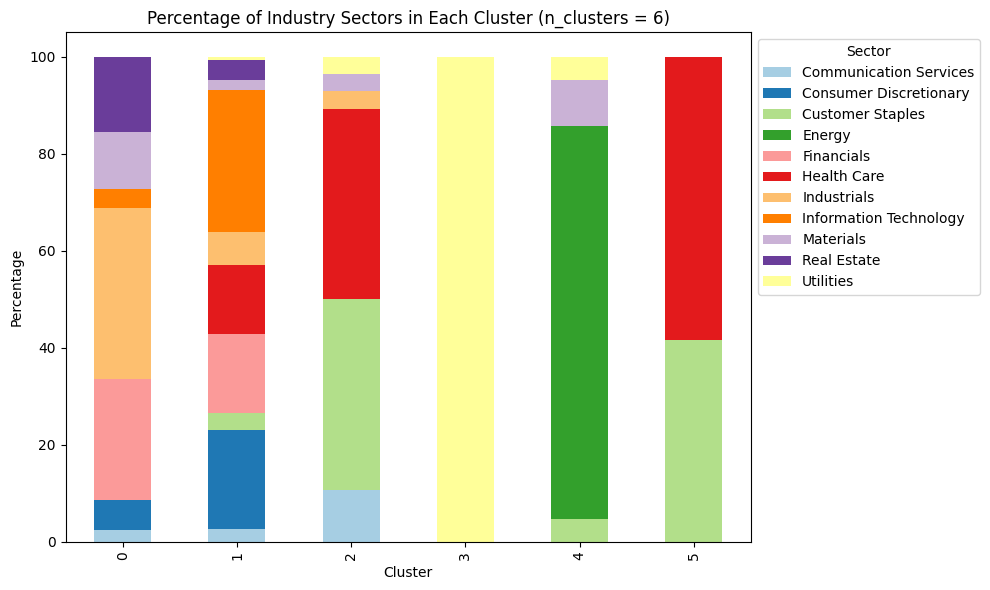

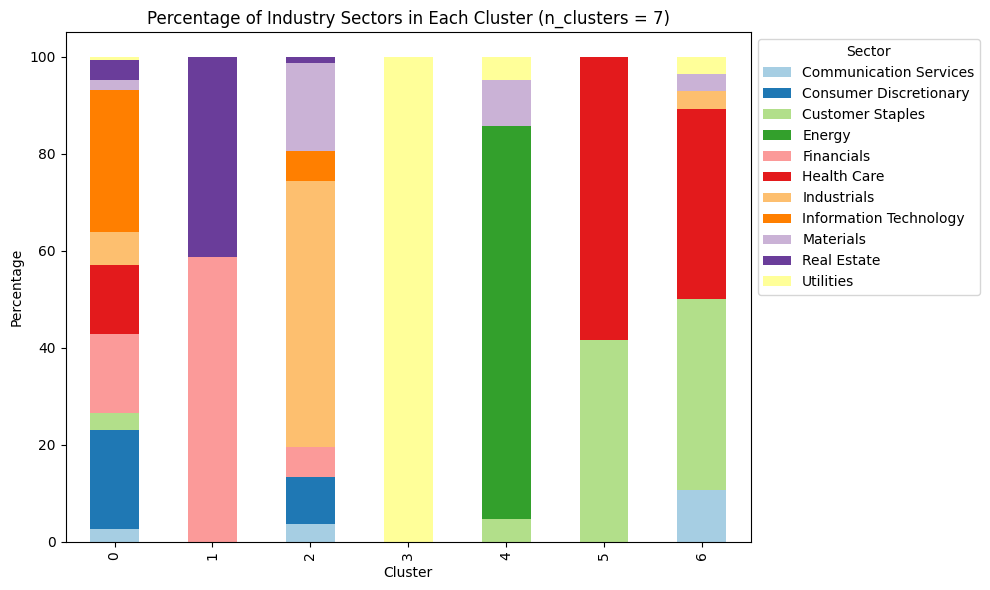

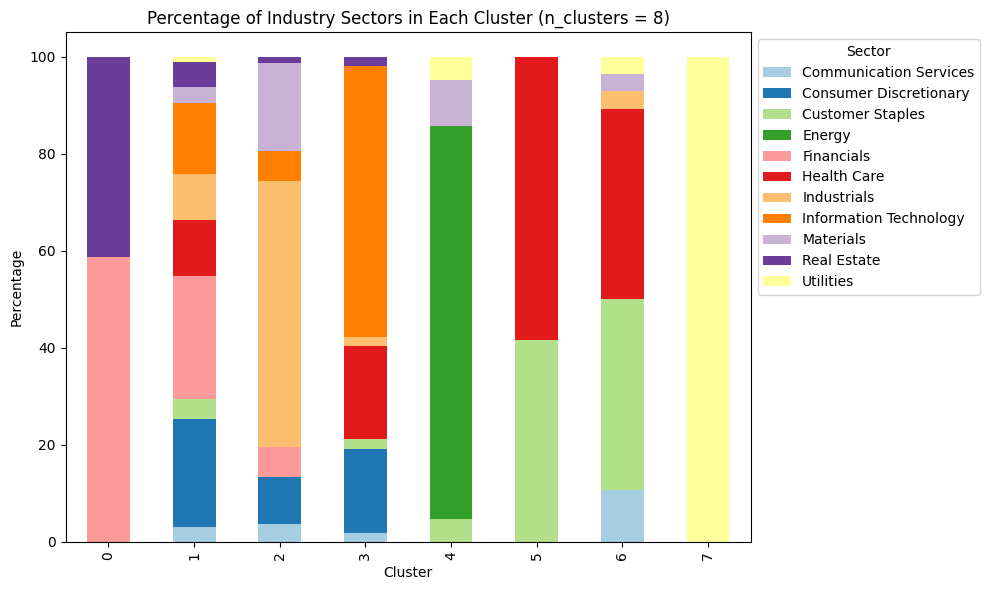

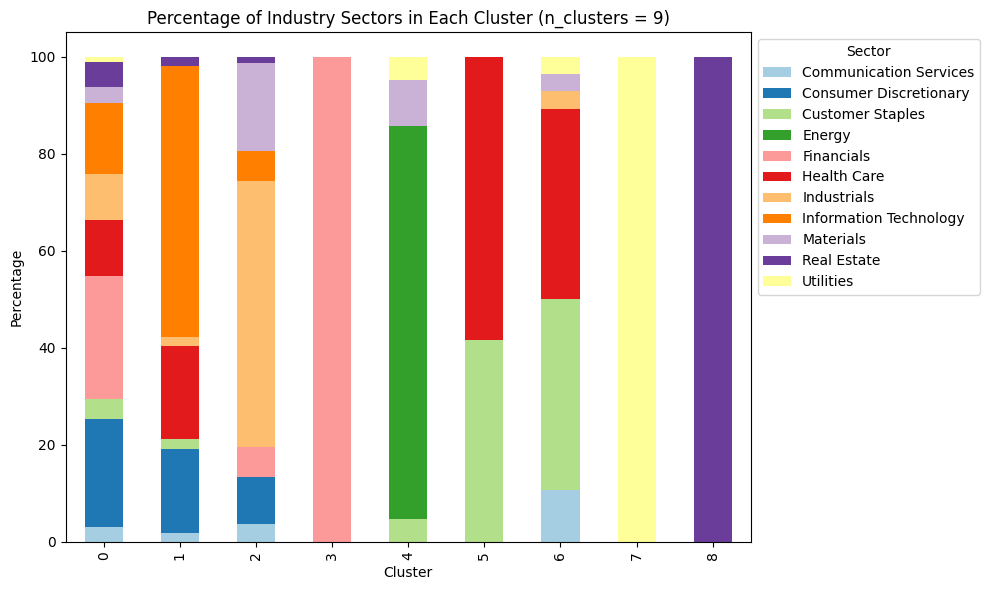

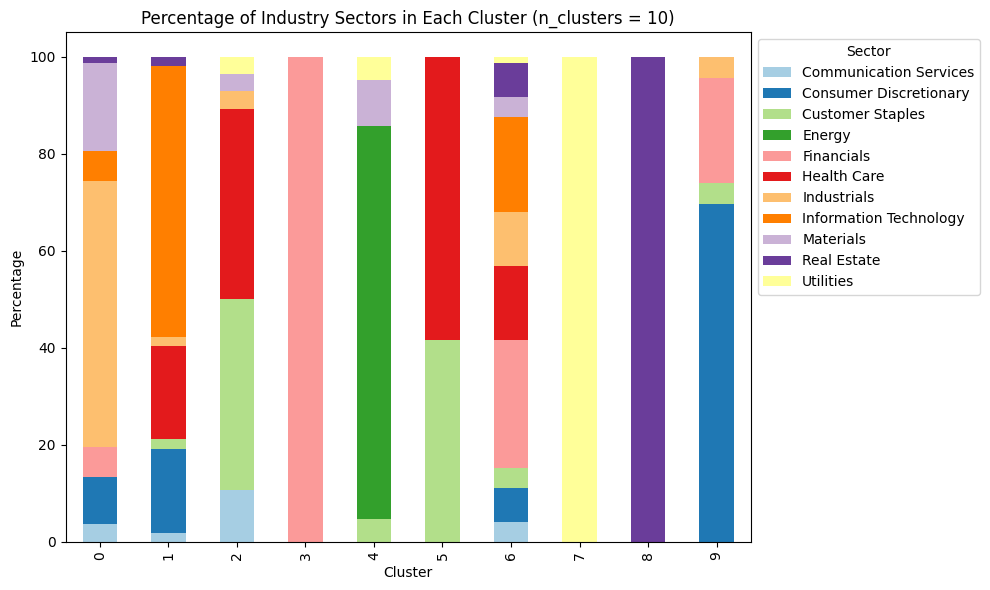

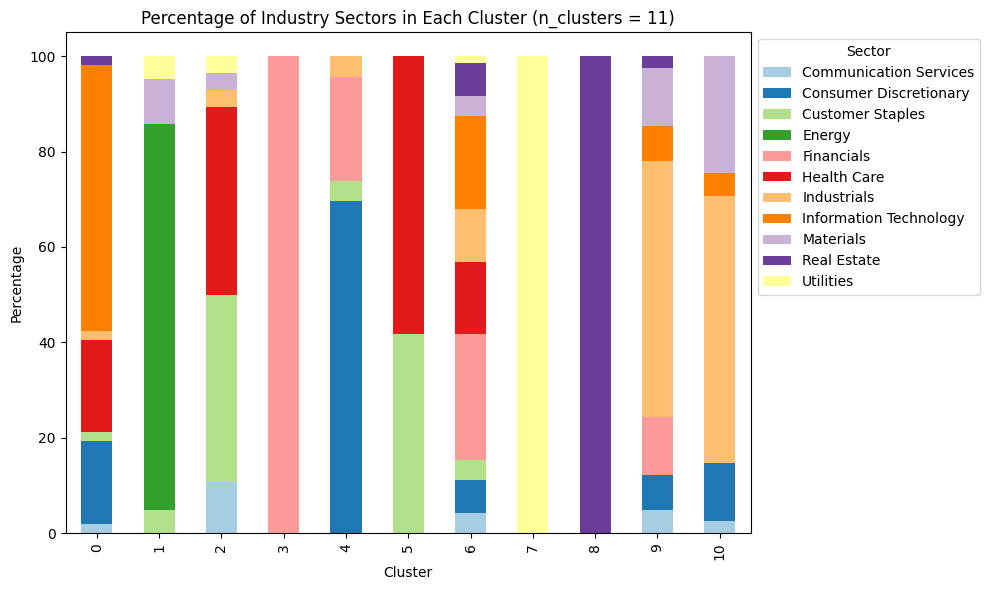

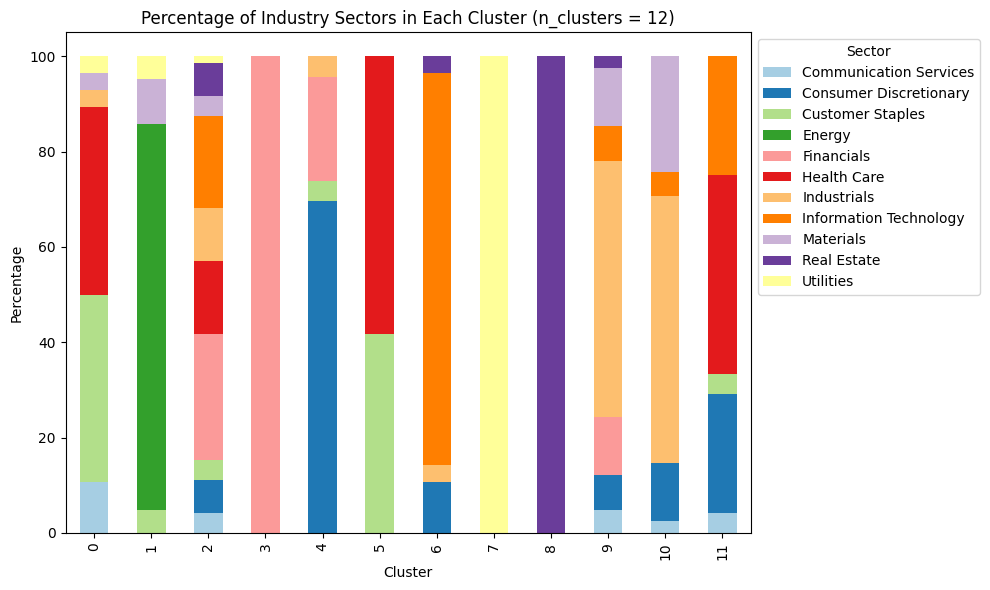

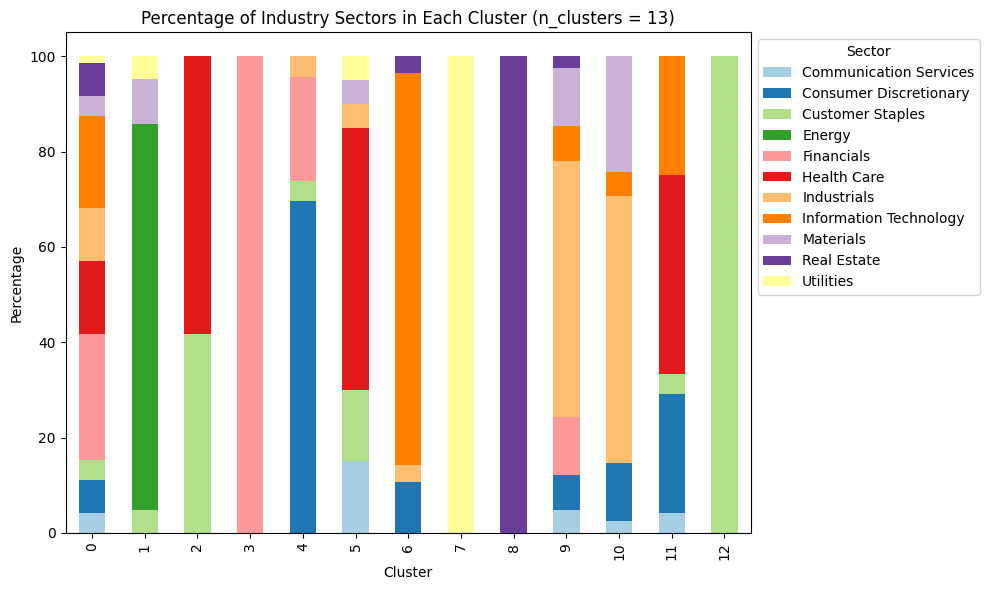

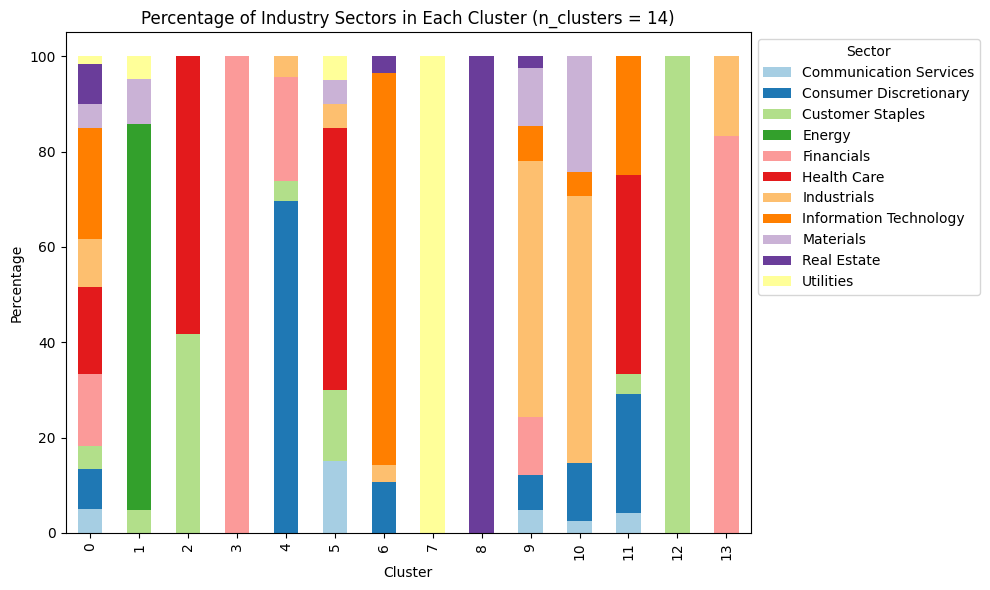

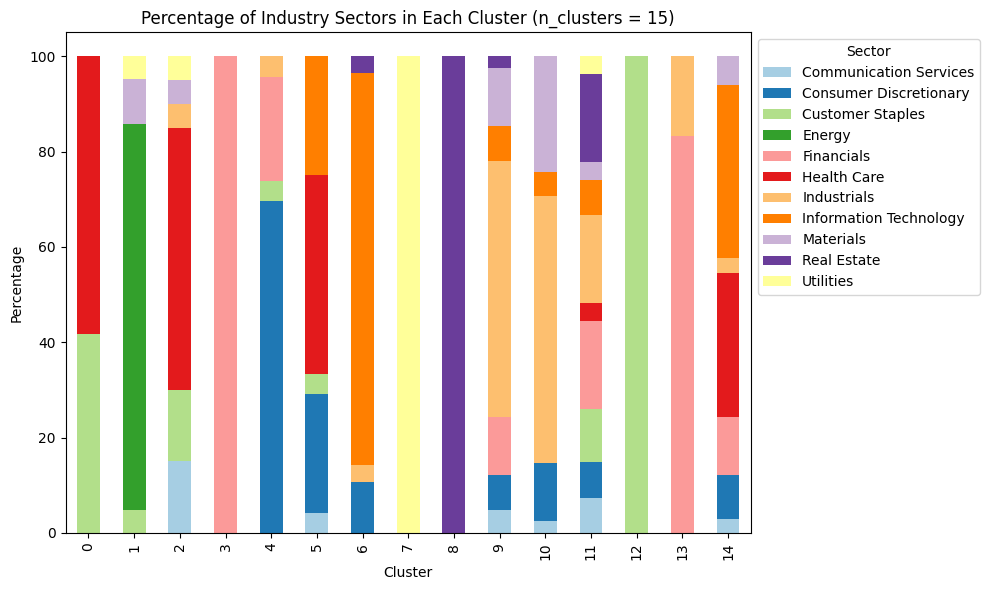

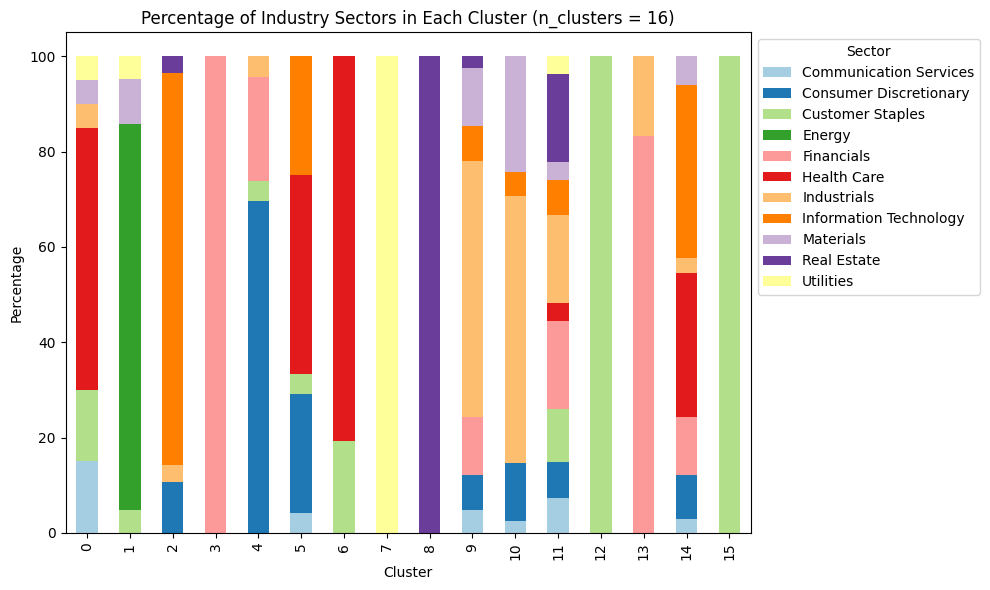

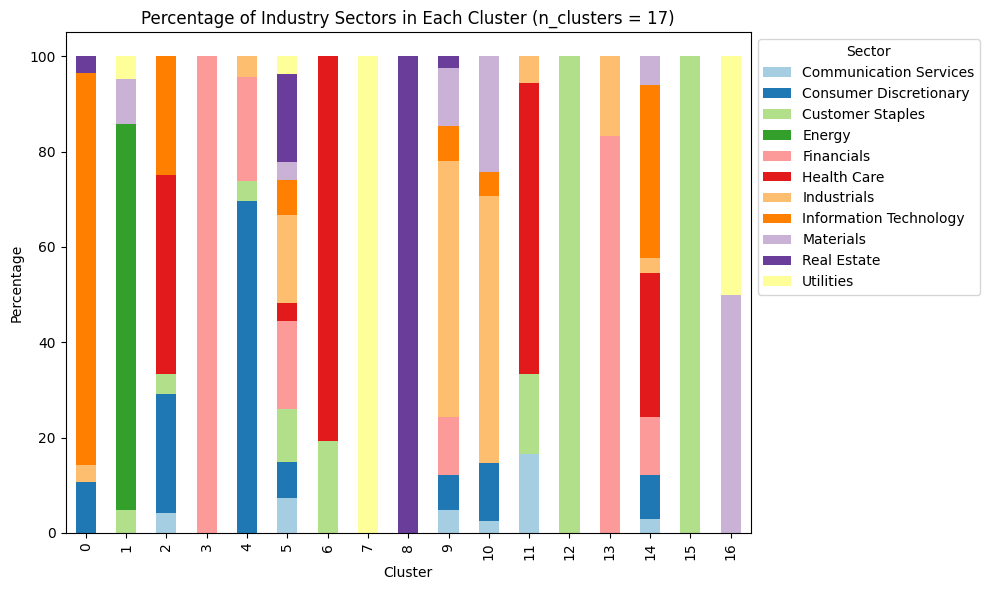

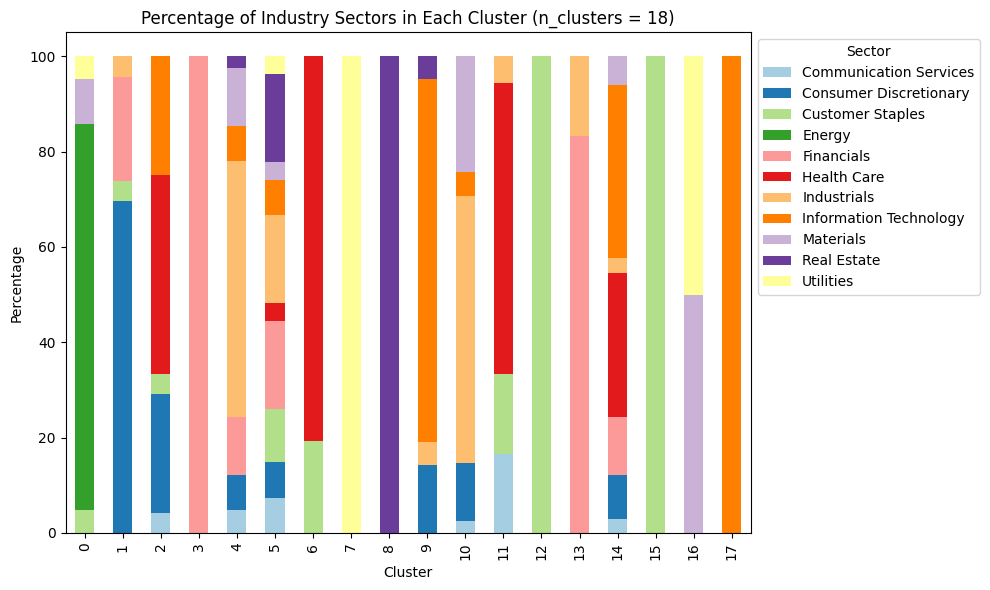

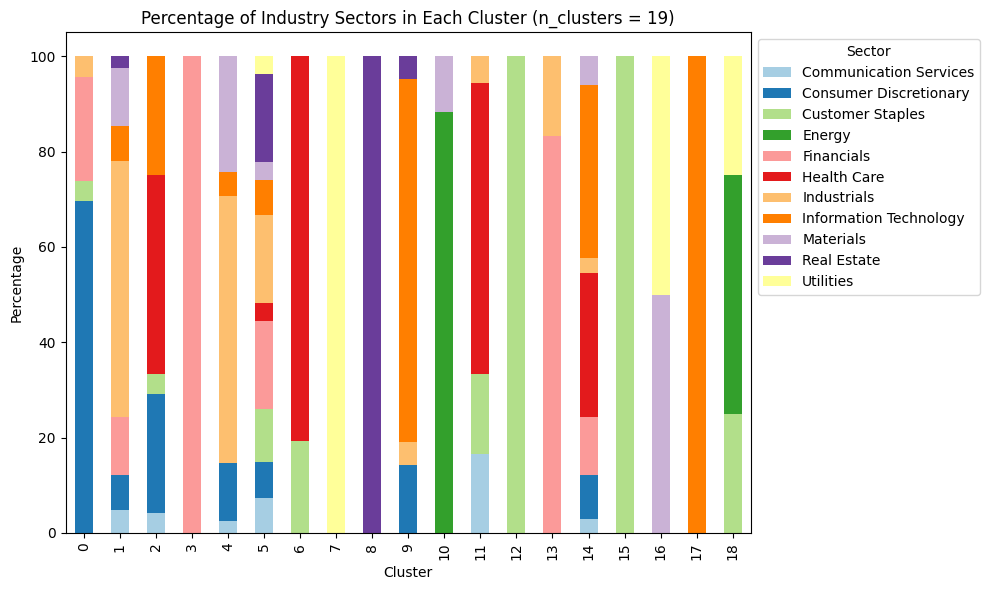

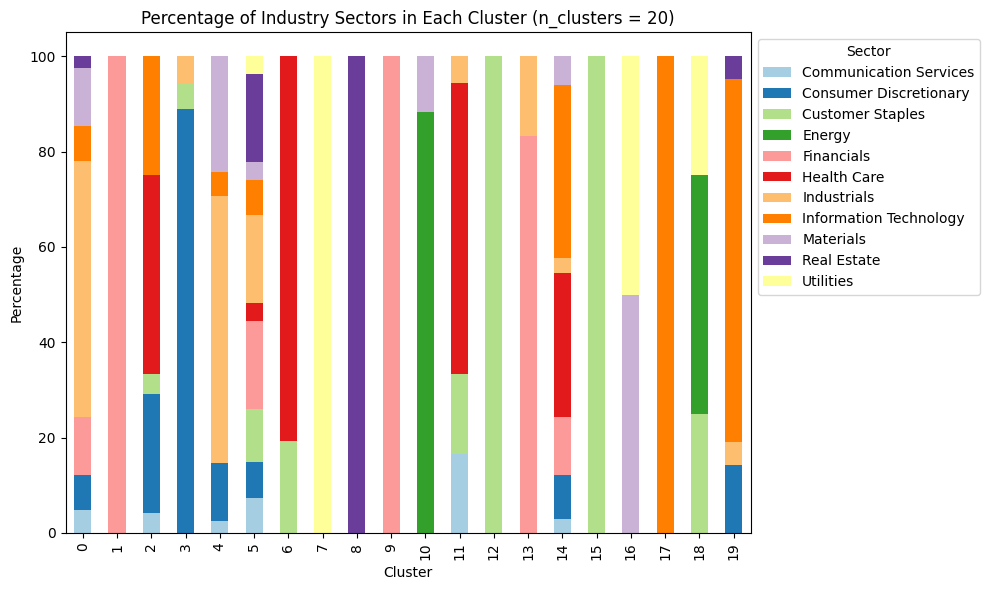

In [119]:
colors = sns.color_palette("Paired", len(industry_sector['Industry Sector'].unique()))

# Stacked bar charts
for n_cluster in n_cluster_options:
    sector_percentage_df_hierarchical = sector_percentage_dfs_hierarchical[n_cluster]

    ax = sector_percentage_df_hierarchical.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#####**6.1.3 Percentage of cluster in each industry sector**

In [120]:
cluster_percentage_dfs_hierarchical = {}

for n_cluster in n_cluster_options:
    cluster_labels_hierarchical = hierarchical_results[n_cluster]
    cluster_counts_hierarchical = pd.DataFrame({'Cluster': cluster_labels_hierarchical, 'Industry Sector': true_labels}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    cluster_percentages_hierarchical = cluster_counts_hierarchical.div(cluster_counts_hierarchical.sum(axis=0), axis=1) * 100
    cluster_percentage_dfs_hierarchical[n_cluster] = cluster_percentages_hierarchical

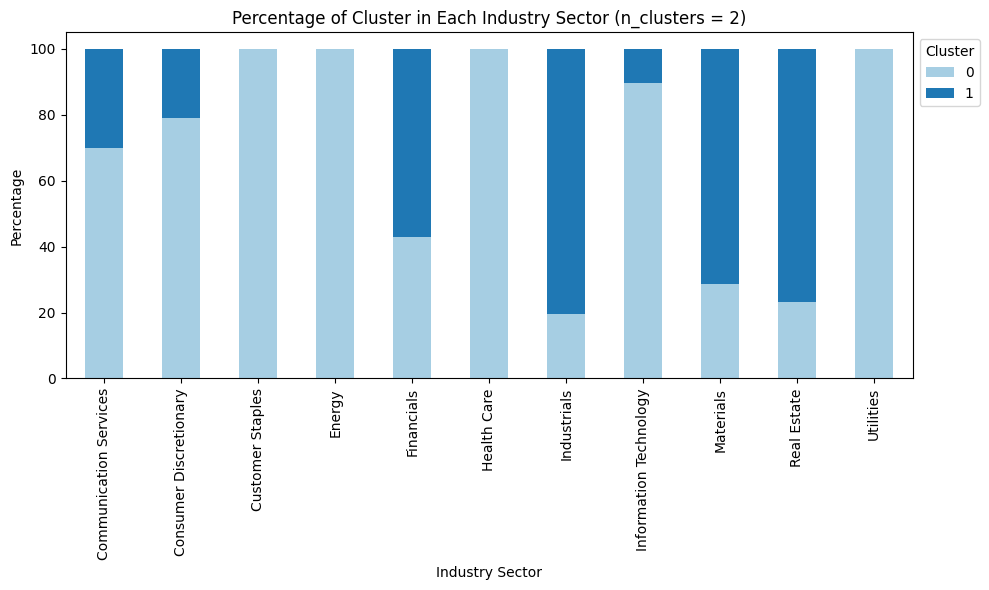

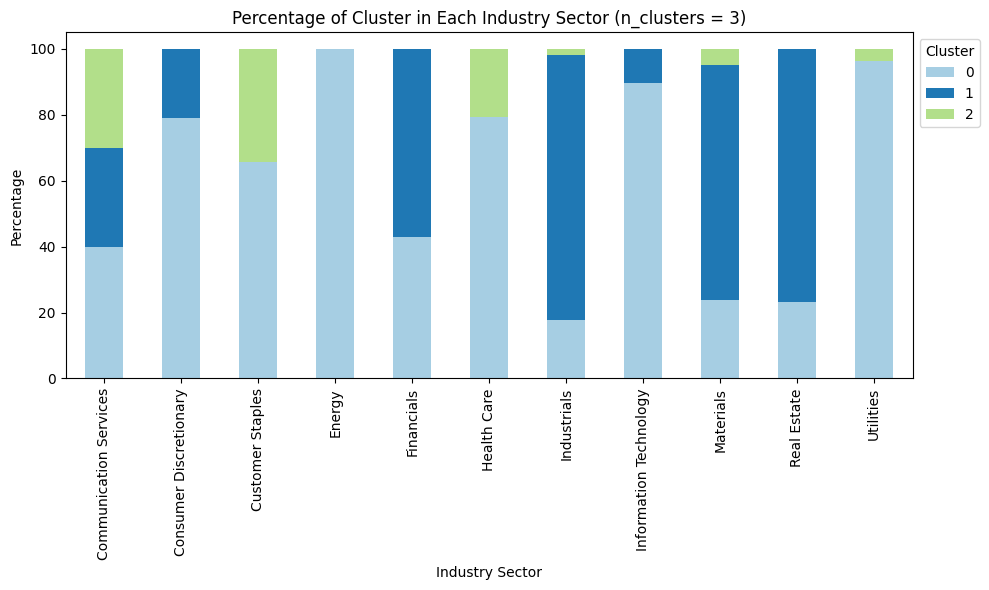

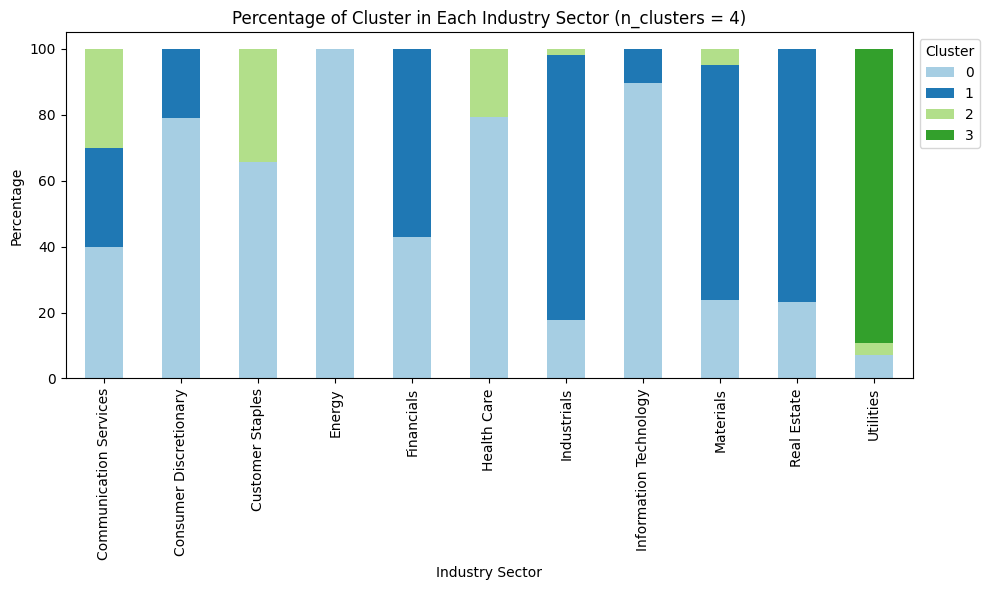

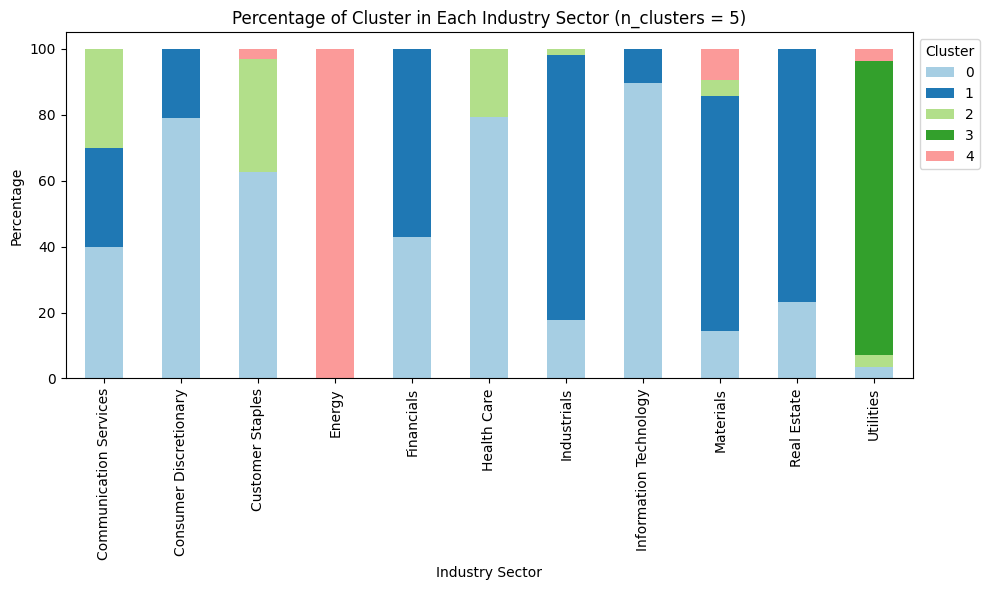

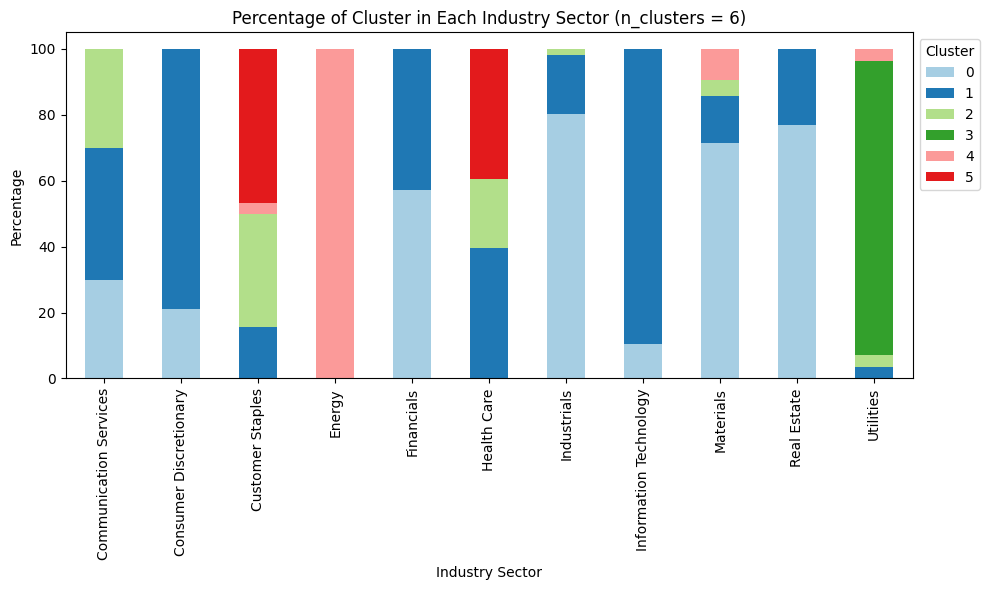

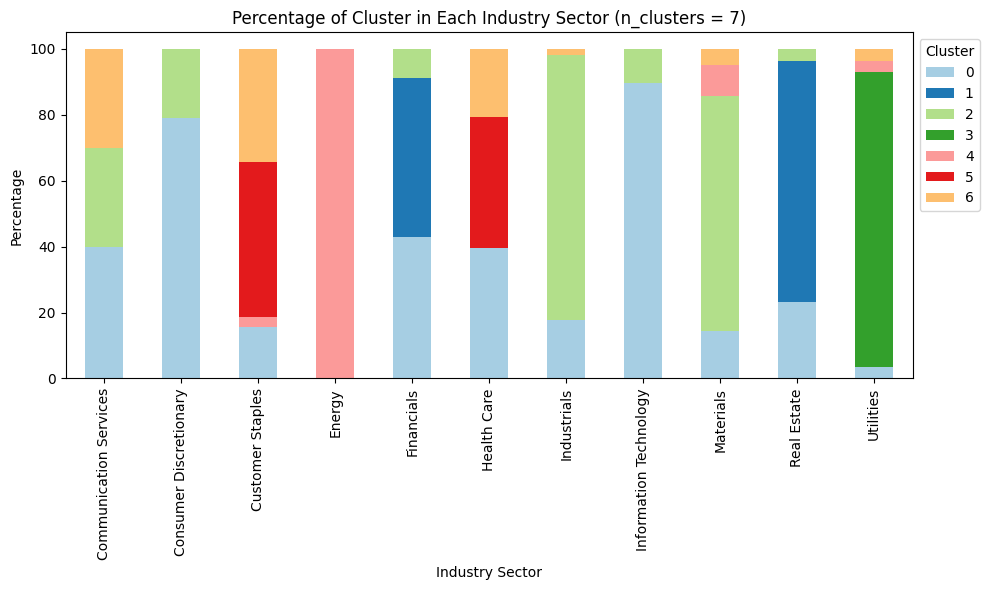

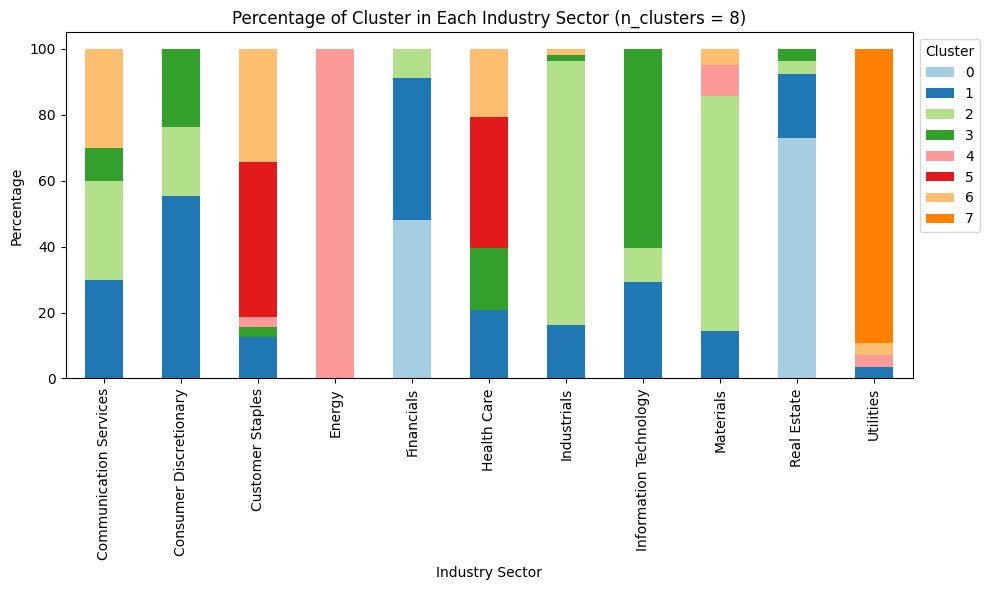

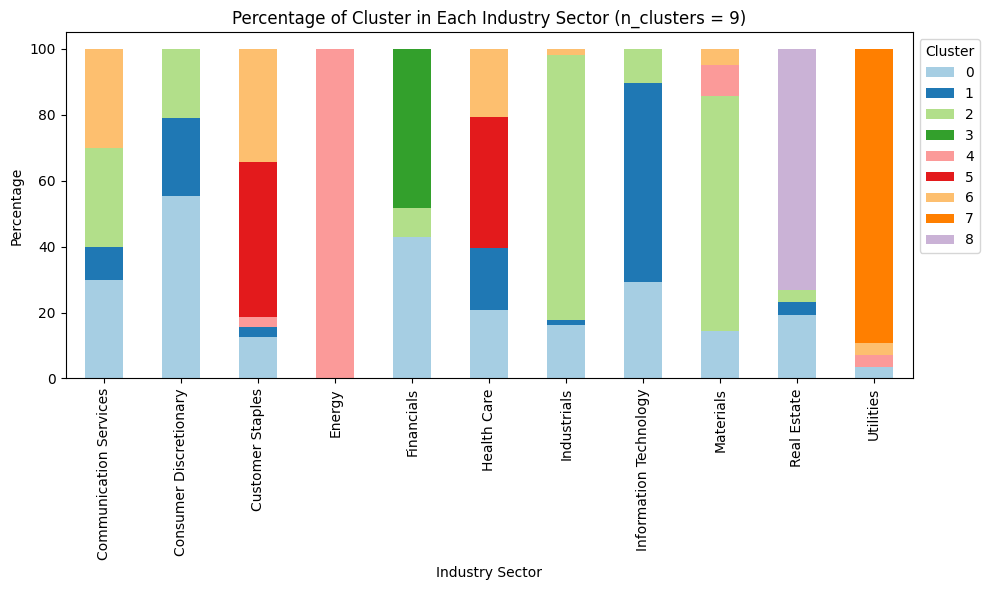

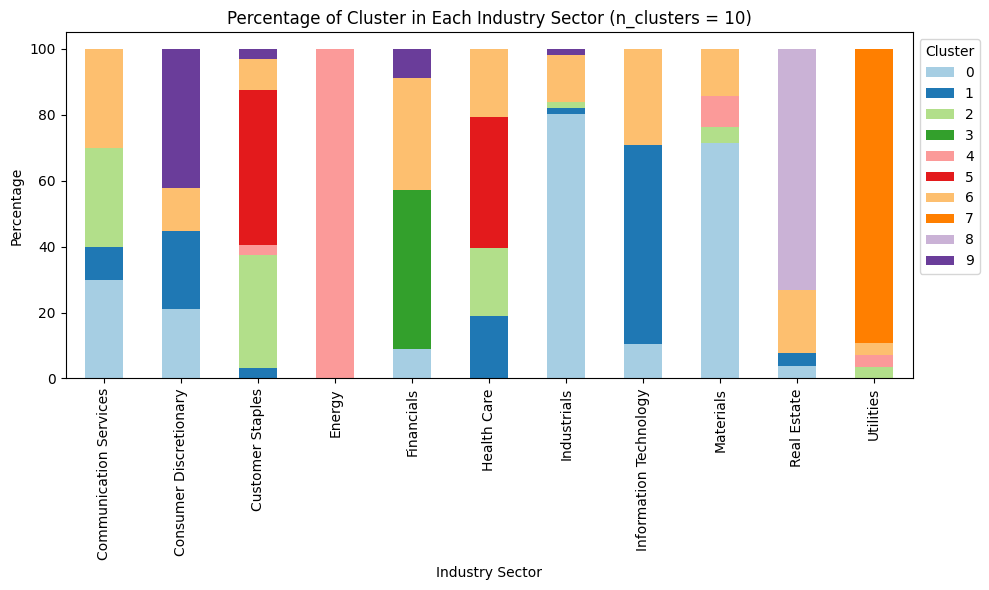

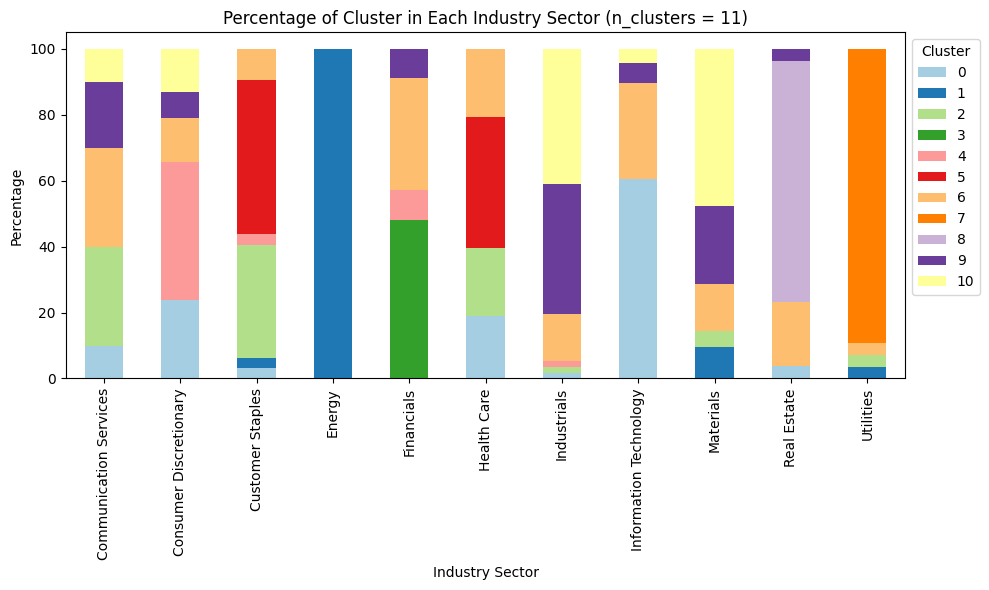

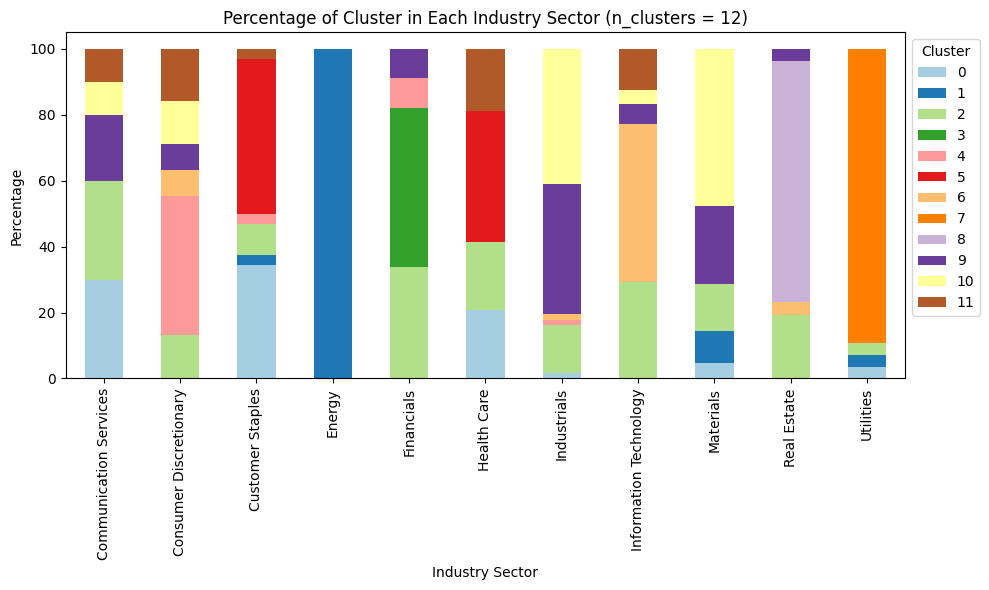

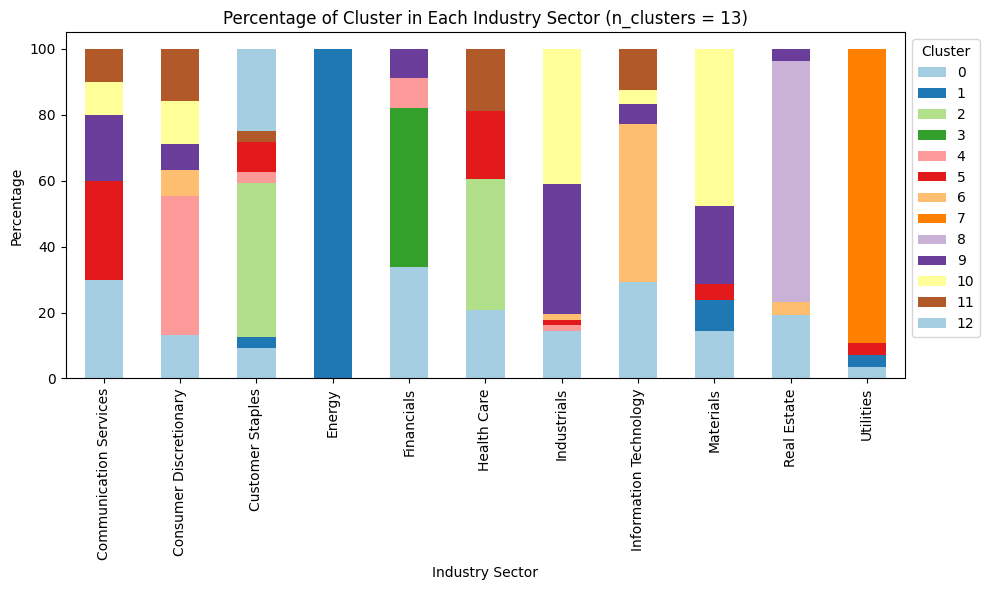

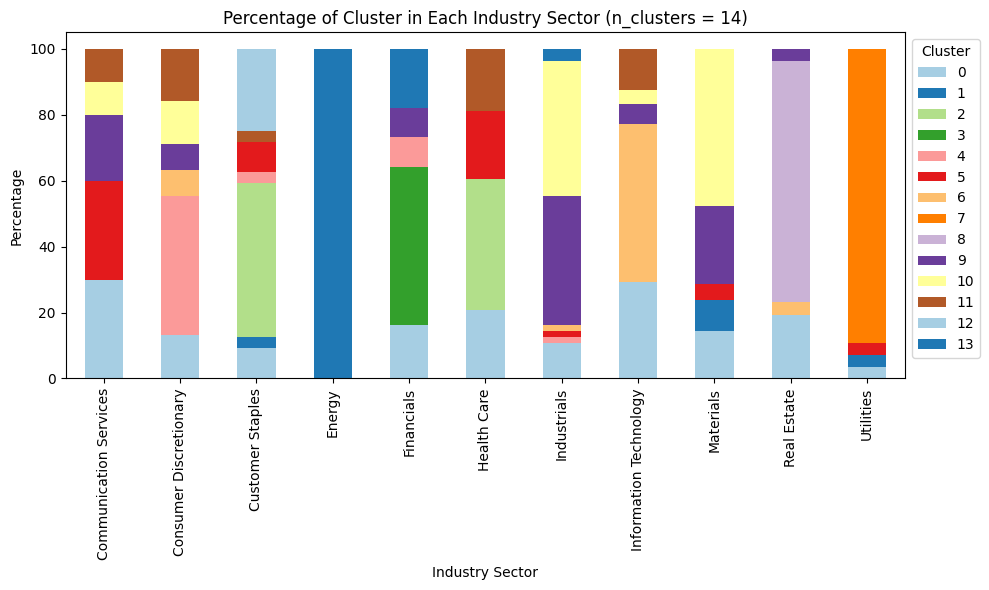

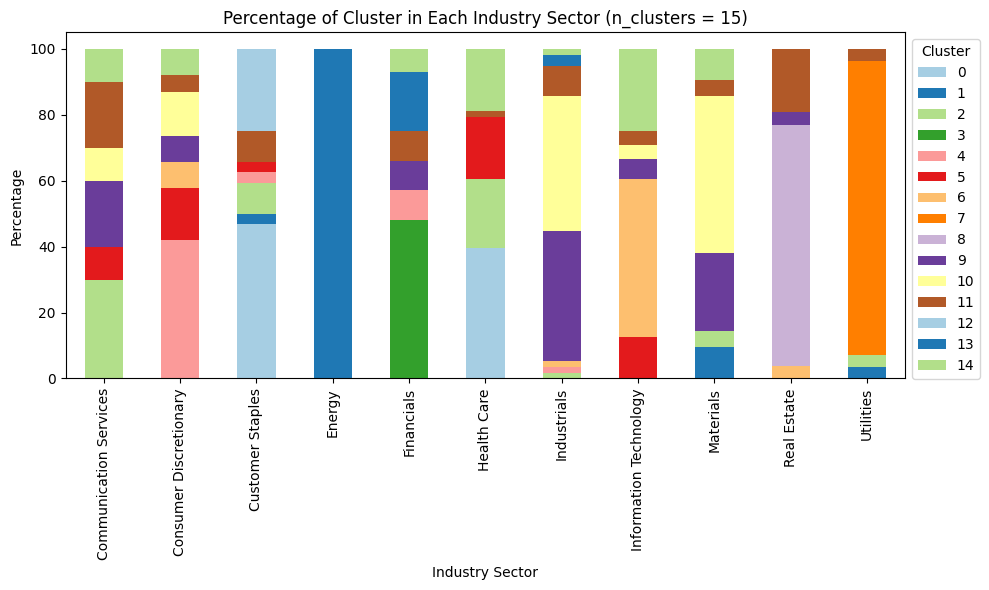

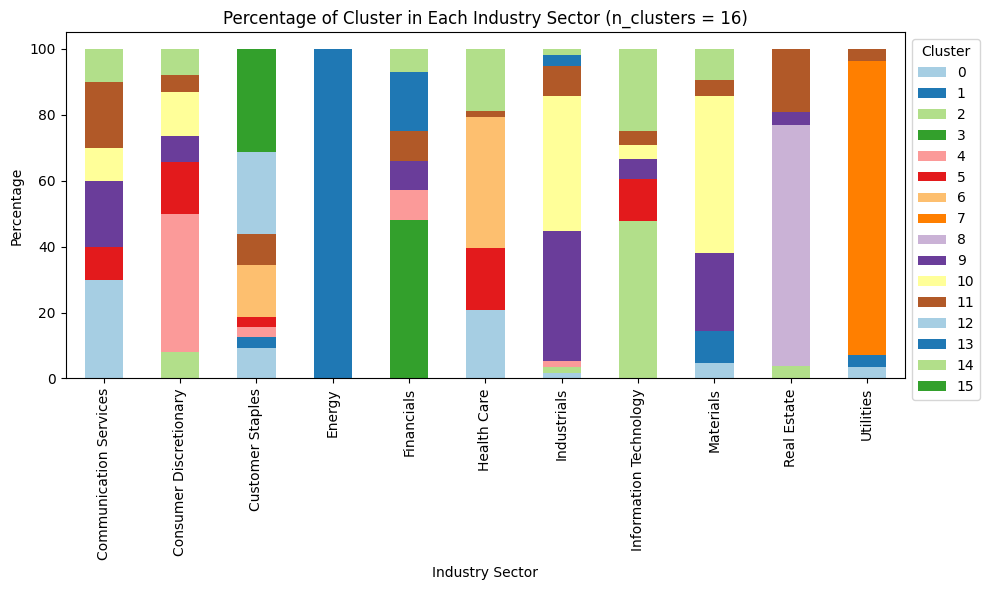

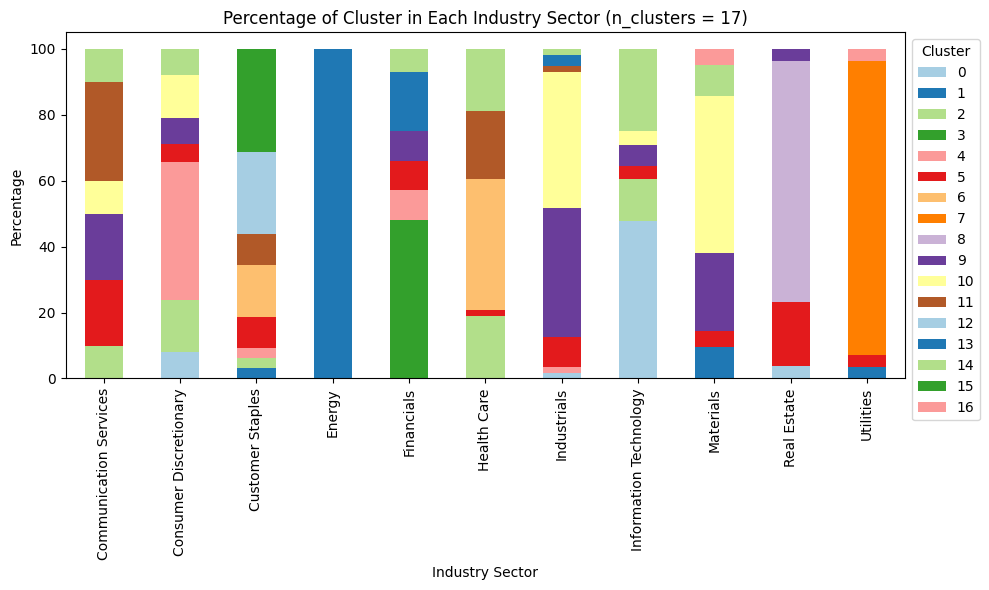

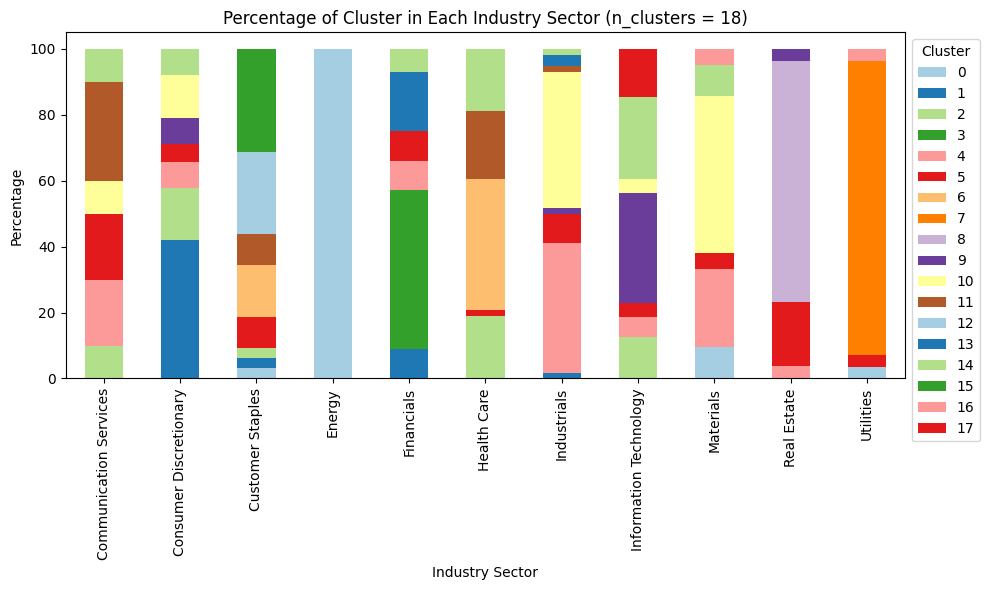

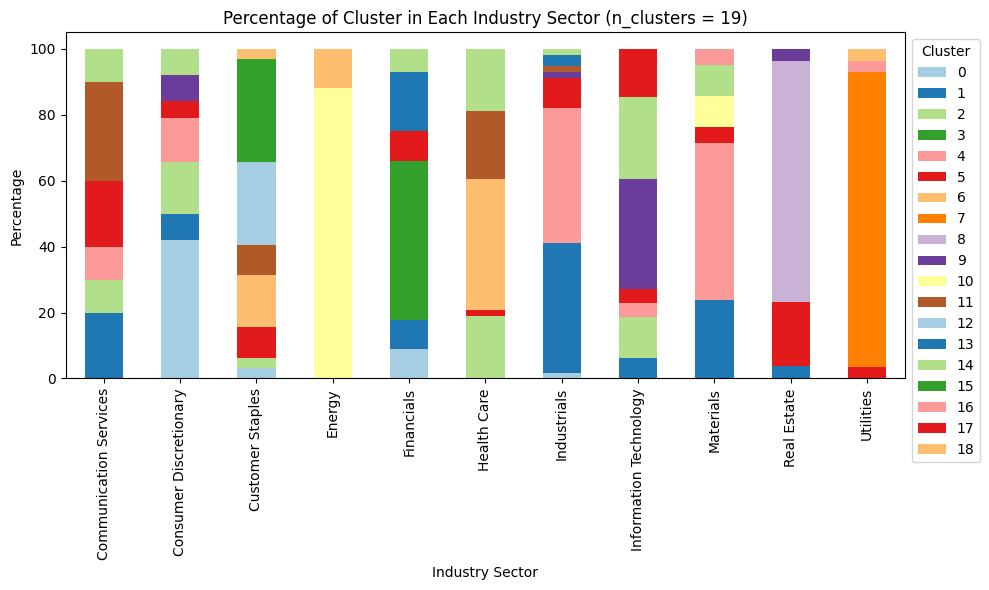

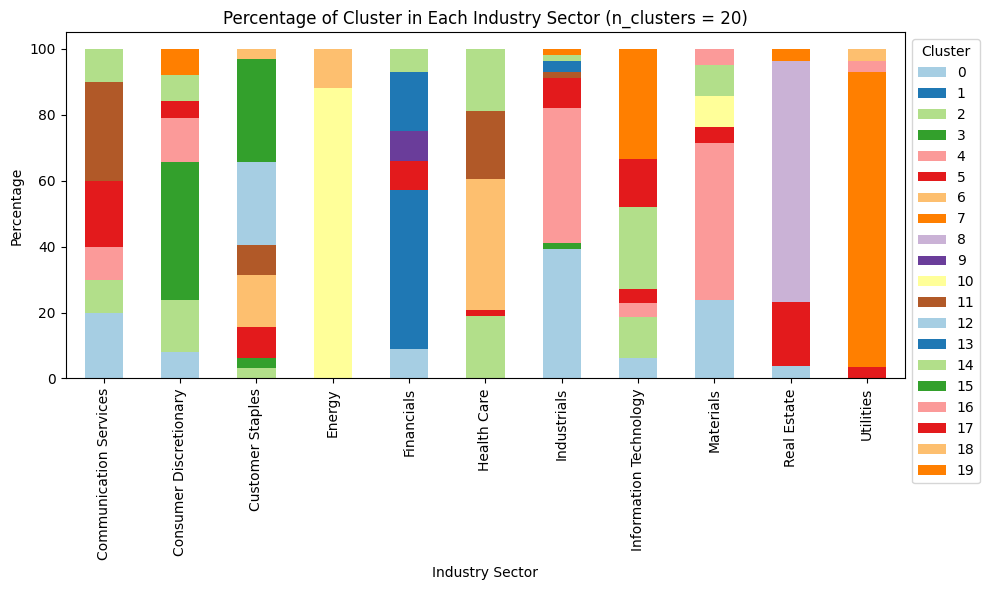

In [121]:
# Stacked bar charts
for n_cluster in n_cluster_options:
    colors = sns.color_palette("Paired", n_cluster)

    cluster_percentage_df_hierarchical = cluster_percentage_dfs_hierarchical[n_cluster]

    ax = cluster_percentage_df_hierarchical.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = {n_cluster})')
    plt.xlabel('Industry Sector')
    plt.ylabel('Percentage')
    plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

####**6.2 Scatterplot**

#####**6.2.1 n_cluster = 5**

In [122]:
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(correlation_matrix)

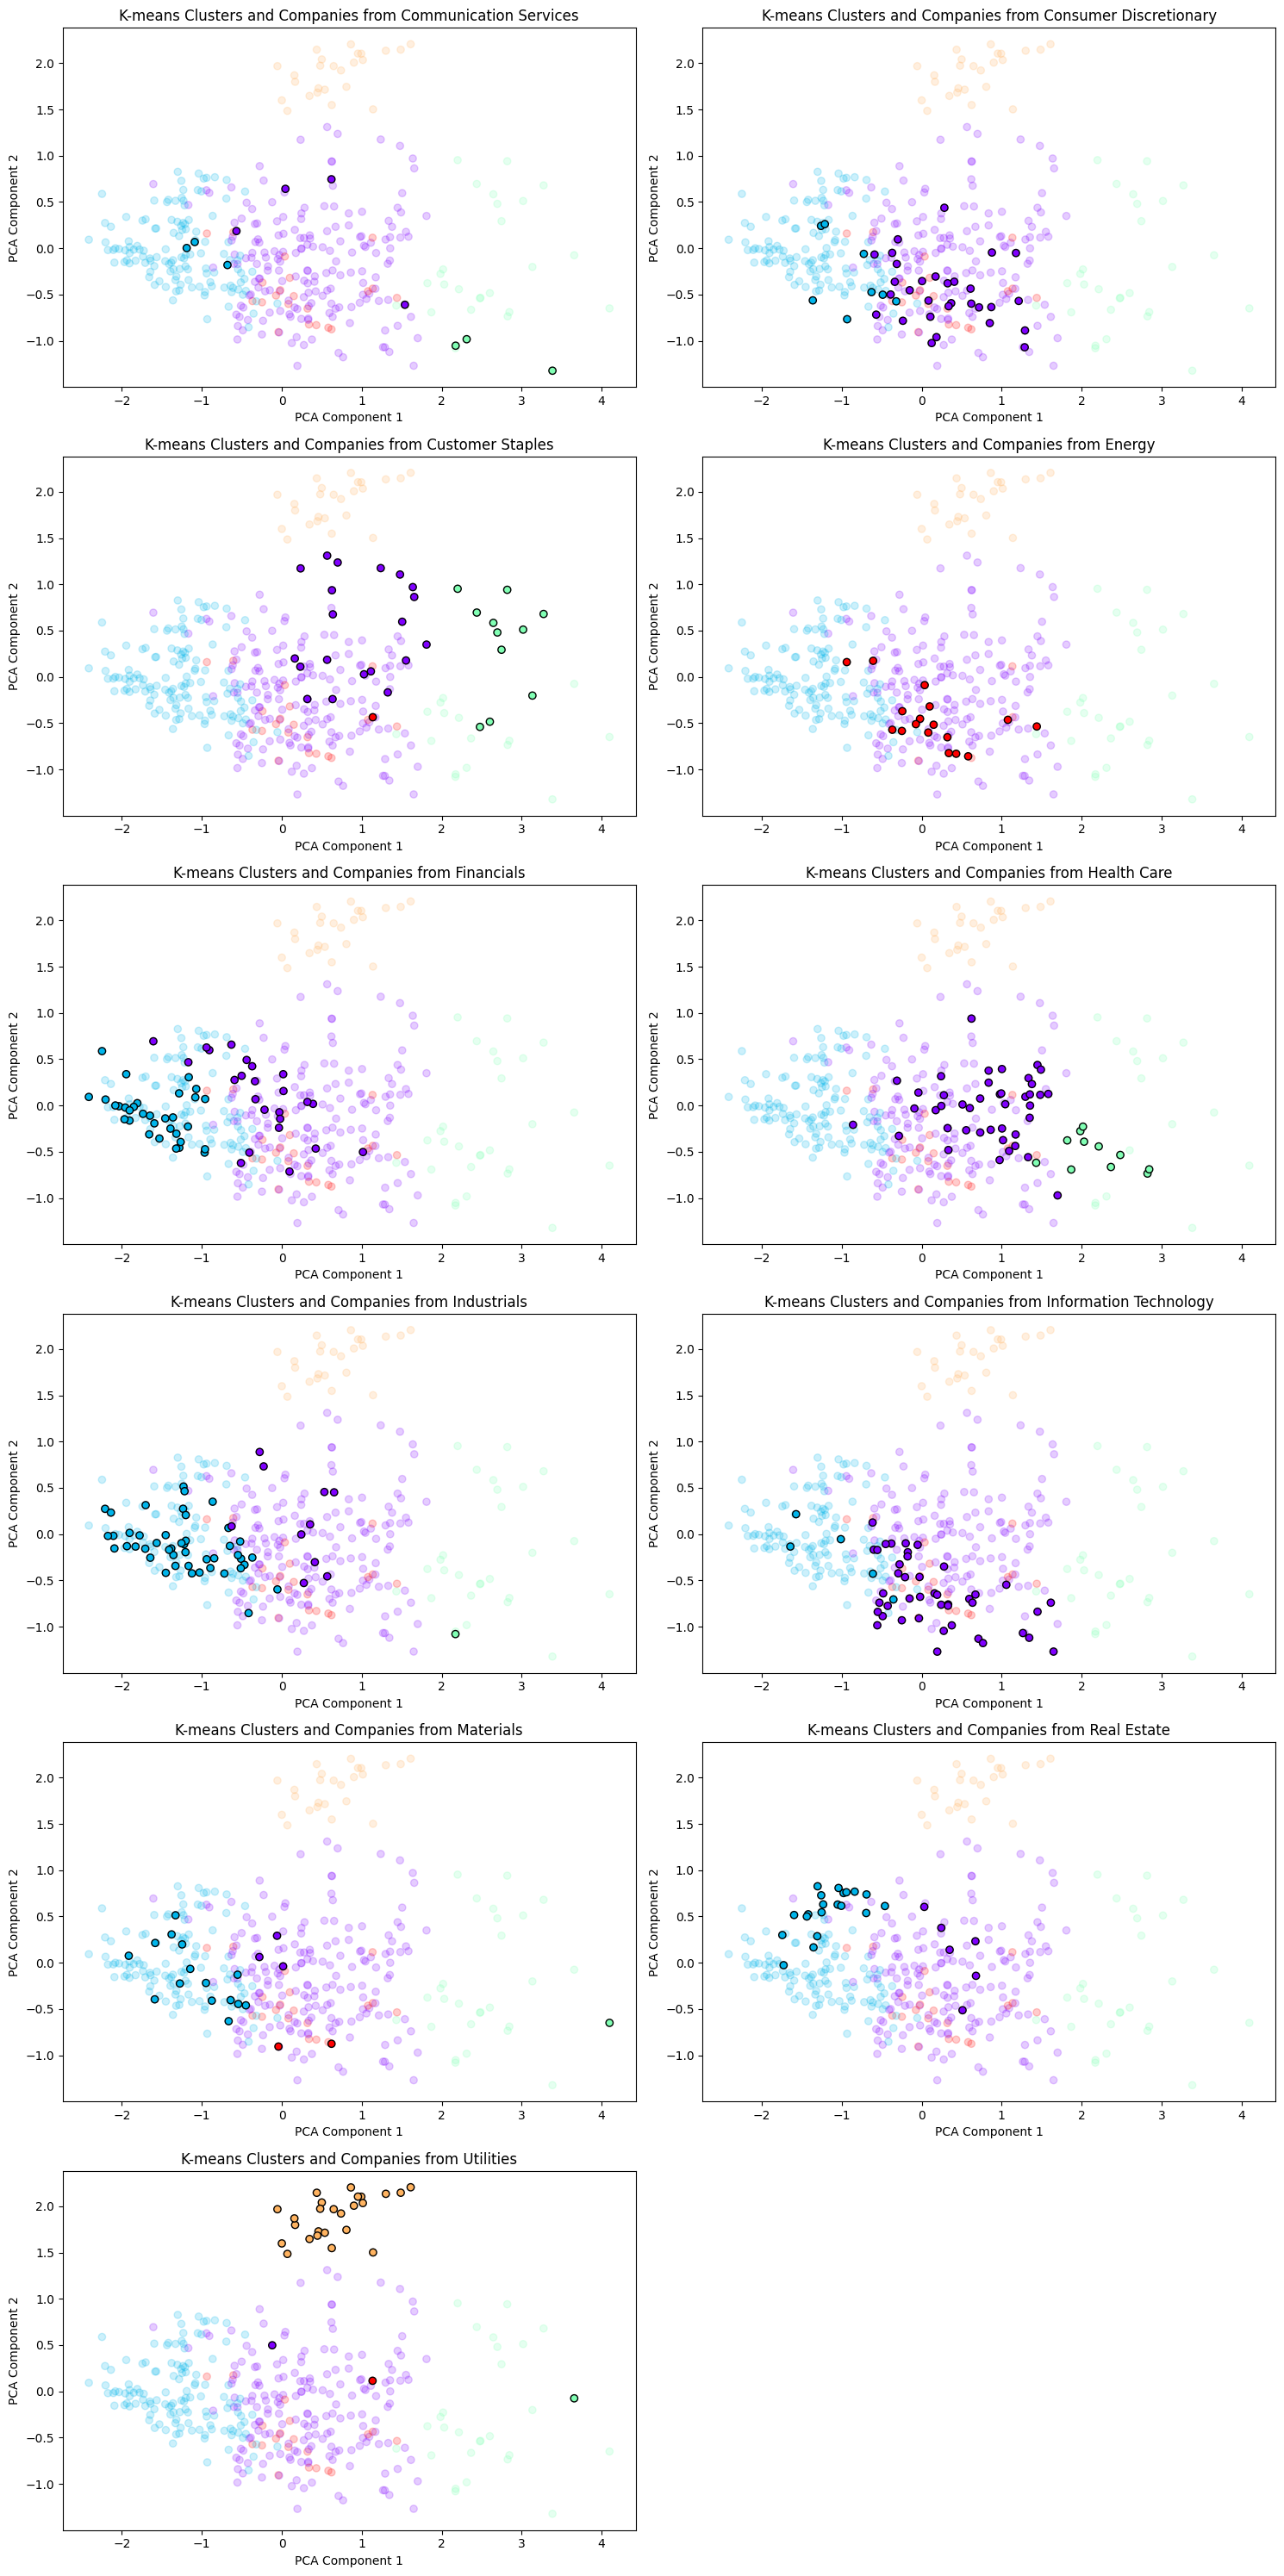

In [123]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html

tickers_category = ['Communication Services', 'Consumer Discretionary', 'Customer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']

figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()
hierarchical_labels = hierarchical_results[5]

# Create a colormap from the k-means labels
unique_labels_length = len(np.unique(hierarchical_labels))
cmap = ListedColormap(plt.cm.rainbow(np.linspace(0, 1, unique_labels_length)))
colors = cmap(hierarchical_labels)

for i, ax in enumerate(axis):
    if i >= len(tickers_category):
        ax.axis('off')
        continue

    highlighted_mask = np.zeros(reduced_data.shape[0], dtype=bool)
    ticker_list = industry_sector_ordered[industry_sector_ordered['Industry Sector'] == tickers_category[i]]['index'].to_numpy()

    # Mark the highlighted tickers
    for ticker in ticker_list:
        if ticker in correlation_matrix.columns:
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            highlighted_mask[ticker_index] = True

    # Other tickers with reduced opacity
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, alpha=0.2)

    # Highlighted tickers with full opacity
    ax.scatter(reduced_data[highlighted_mask, 0], reduced_data[highlighted_mask, 1], c=colors[highlighted_mask], edgecolors='black', alpha=1.0)

    ax.set_title(f'K-means Clusters and Companies from {tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()